In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import math
import copy

In [2]:
import torch
import torch.nn as nn
from torch.utils import data
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision.models as models

In [5]:
device = torch.device("cuda")

## Image to Tensor Conversions

In [57]:
imsize = 1024

def file_to_tensor(file_path):
    image = Image.open(file_path)
    ten_image = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])(image).to(device)
    ten_image.unsqueeze_(0) # adds batch size = 1
    return ten_image

def image_to_tensor(image):
    ten_image = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])(image).to(device)
    ten_image.unsqueeze_(0) # adds batch size = 1
    return ten_image

def tensor_to_image(tensor):
    img = transforms.ToPILImage()(tensor.clone().cpu().squeeze(0))
    return img

In [58]:
set_folder = "Set11"

content = file_to_tensor("UpdatedSets/"+set_folder+"/content.jpg")
style = file_to_tensor("UpdatedSets/"+set_folder+"/style.png")

In [59]:
if content.size() != style.size():
    print("Please execute Processing the Data.ipynb on the dataset")

## Choosing the optimal model

In [24]:
vgg = models.vgg19_bn(pretrained=True).features.to(device).eval()

# Setting Up the Normalisation Layer for VGG

In [10]:
class Normalization(nn.Module):
    def __init__(self):
        super(Normalization, self).__init__()
        self.mean = torch.tensor([0.485, 0.456, 0.406]).to(device).view(-1,1,1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).to(device).view(-1,1,1)
    
    def forward(self, img):
        return (img - self.mean)/self.std

# Setting Up the Content Loss - Simple MSE Loss

In [11]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
    
    def forward(self, img):
        self.loss = F.mse_loss(img, self.target)
        return img

# Setting Up the Style Loss - Using Gram Matrix

In [12]:
def convert_to_gram(img):
    b, f, h, w = img.size()
    reshp_img = img.view(b*f, w*h)
    gram = torch.mm(reshp_img, reshp_img.t()).div(b*f*w*h)
    return gram

In [13]:
class StyleLoss(nn.Module):
    def __init__(self, target):
        super(StyleLoss, self).__init__()
        self.target = convert_to_gram(target).detach()
    
    def forward(self, img):
        self.loss = F.mse_loss(convert_to_gram(img), self.target)
        return img

# Create the new model

In [25]:
content_layers = ['conv_2', 'conv_5']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5', 'conv_7']


def get_new_model(vgg19, content_image, style_image):
    
    global content_layers
    global style_layers
    content_modules = []
    style_modules = []

    vgg = copy.deepcopy(vgg19)
    normalisation = Normalization().to(device)
    model = nn.Sequential(normalisation)
    i = 0

    for layer in vgg:
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_'+str(i)

        elif isinstance(layer, nn.ReLU):
            name = 'relu_'+str(i)

        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_'+str(i)

        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_'+str(i)

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_image).detach()
            content_l = ContentLoss(target)
            model.add_module('content_layer_'+str(i), content_l)
            content_modules.append(content_l)
        
        if name in style_layers:
            target = model(style_image).detach()
            style_l = StyleLoss(target)
            model.add_module('style_layer_'+str(i), style_l)
            style_modules.append(style_l)
        
    for i in range(len(model)-1, 0, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:i+1]
    return model, content_modules, style_modules

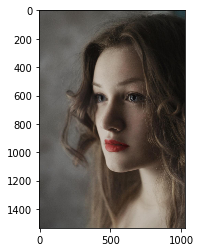

In [74]:
use_content = True
input_img = None

if use_content is True:
    # For using the content image
    input_img = tensor_to_image(content)
else:
    # For using random noise as input
    input_img = tensor_to_image(torch.randn(content.data.size(), device=device))

plt.imshow(input_img)

# Training the model

In [75]:
def style_transfer(vgg, content_img, style_img, input_img, iters=10, style_w=1000000, content_w=1):
    
    input_img = image_to_tensor(input_img)
    model, con_layers, st_layers = get_new_model(vgg, content_img, style_img)
    optimiser = torch.optim.LBFGS([input_img.requires_grad_()], lr=0.01)
    
    for i in range(iters):
        
        def closure():
            input_img.data.clamp_(0, 1)
            model(input_img)
            style_val = 0
            content_val = 0
            
            optimiser.zero_grad()

            for sc in st_layers:
                style_val += sc.loss
            for cc in con_layers:
                content_val += cc.loss

            net_loss = style_w*style_val + content_w*content_val
            net_loss.backward()
            print('Iteration {}: '.format(i+1), 'Style Loss = {:4f} '.format(style_val),
              'Content Loss = {:4f} '.format(content_val))
            return net_loss
            
        optimiser.step(closure)

    input_img.data.clamp_(0, 1)
    final_img = tensor_to_image(input_img)
    plt.imshow(final_img)
    return final_img

Iteration 1:  Style Loss = 0.000016  Content Loss = 0.000000 
Iteration 1:  Style Loss = 0.000016  Content Loss = 0.000000 
Iteration 2:  Style Loss = 0.000016  Content Loss = 0.000000 
Iteration 2:  Style Loss = 0.000016  Content Loss = 0.000000 
Iteration 2:  Style Loss = 0.000016  Content Loss = 0.000009 
Iteration 2:  Style Loss = 0.000016  Content Loss = 0.000134 
Iteration 2:  Style Loss = 0.000016  Content Loss = 0.000546 
Iteration 2:  Style Loss = 0.000016  Content Loss = 0.001412 
Iteration 2:  Style Loss = 0.000015  Content Loss = 0.003052 
Iteration 2:  Style Loss = 0.000015  Content Loss = 0.006108 
Iteration 2:  Style Loss = 0.000014  Content Loss = 0.011213 
Iteration 2:  Style Loss = 0.000013  Content Loss = 0.017791 
Iteration 2:  Style Loss = 0.000013  Content Loss = 0.024287 
Iteration 2:  Style Loss = 0.000012  Content Loss = 0.029990 
Iteration 2:  Style Loss = 0.000012  Content Loss = 0.035353 
Iteration 2:  Style Loss = 0.000012  Content Loss = 0.040718 
Iteratio

Iteration 8:  Style Loss = 0.000002  Content Loss = 0.207239 
Iteration 8:  Style Loss = 0.000002  Content Loss = 0.207508 
Iteration 8:  Style Loss = 0.000002  Content Loss = 0.207772 
Iteration 8:  Style Loss = 0.000002  Content Loss = 0.208029 
Iteration 8:  Style Loss = 0.000002  Content Loss = 0.208276 
Iteration 8:  Style Loss = 0.000002  Content Loss = 0.208518 
Iteration 8:  Style Loss = 0.000002  Content Loss = 0.208754 
Iteration 8:  Style Loss = 0.000002  Content Loss = 0.208982 
Iteration 8:  Style Loss = 0.000002  Content Loss = 0.209204 
Iteration 9:  Style Loss = 0.000002  Content Loss = 0.209420 
Iteration 9:  Style Loss = 0.000002  Content Loss = 0.209629 
Iteration 9:  Style Loss = 0.000002  Content Loss = 0.209831 
Iteration 9:  Style Loss = 0.000002  Content Loss = 0.210028 
Iteration 9:  Style Loss = 0.000002  Content Loss = 0.210219 
Iteration 9:  Style Loss = 0.000002  Content Loss = 0.210404 
Iteration 9:  Style Loss = 0.000002  Content Loss = 0.210582 
Iteratio

Iteration 15:  Style Loss = 0.000001  Content Loss = 0.205496 
Iteration 15:  Style Loss = 0.000001  Content Loss = 0.205303 
Iteration 15:  Style Loss = 0.000001  Content Loss = 0.205110 
Iteration 15:  Style Loss = 0.000001  Content Loss = 0.204916 
Iteration 15:  Style Loss = 0.000001  Content Loss = 0.204722 
Iteration 15:  Style Loss = 0.000001  Content Loss = 0.204527 
Iteration 15:  Style Loss = 0.000001  Content Loss = 0.204333 
Iteration 15:  Style Loss = 0.000001  Content Loss = 0.204138 
Iteration 15:  Style Loss = 0.000001  Content Loss = 0.203944 
Iteration 15:  Style Loss = 0.000001  Content Loss = 0.203750 
Iteration 15:  Style Loss = 0.000001  Content Loss = 0.203556 
Iteration 15:  Style Loss = 0.000001  Content Loss = 0.203361 
Iteration 15:  Style Loss = 0.000001  Content Loss = 0.203168 
Iteration 15:  Style Loss = 0.000001  Content Loss = 0.202975 
Iteration 15:  Style Loss = 0.000001  Content Loss = 0.202782 
Iteration 15:  Style Loss = 0.000001  Content Loss = 0.

Iteration 21:  Style Loss = 0.000000  Content Loss = 0.186776 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.186727 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.186678 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.186631 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.186585 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.186539 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.186494 
Iteration 22:  Style Loss = 0.000000  Content Loss = 0.186450 
Iteration 22:  Style Loss = 0.000000  Content Loss = 0.186408 
Iteration 22:  Style Loss = 0.000000  Content Loss = 0.186366 
Iteration 22:  Style Loss = 0.000000  Content Loss = 0.186324 
Iteration 22:  Style Loss = 0.000000  Content Loss = 0.186284 
Iteration 22:  Style Loss = 0.000000  Content Loss = 0.186244 
Iteration 22:  Style Loss = 0.000000  Content Loss = 0.186204 
Iteration 22:  Style Loss = 0.000000  Content Loss = 0.186165 
Iteration 22:  Style Loss = 0.000000  Content Loss = 0.

Iteration 28:  Style Loss = 0.000000  Content Loss = 0.185287 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.185326 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.185364 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.185401 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.185442 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.185487 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.185525 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.185564 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.185614 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.185661 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.185696 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.185742 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.185802 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.185841 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.185880 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.

Iteration 34:  Style Loss = 0.000000  Content Loss = 0.191144 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.191169 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.191200 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.191236 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.191262 
Iteration 35:  Style Loss = 0.000000  Content Loss = 0.191288 
Iteration 35:  Style Loss = 0.000000  Content Loss = 0.191323 
Iteration 35:  Style Loss = 0.000000  Content Loss = 0.191353 
Iteration 35:  Style Loss = 0.000000  Content Loss = 0.191377 
Iteration 35:  Style Loss = 0.000000  Content Loss = 0.191406 
Iteration 35:  Style Loss = 0.000000  Content Loss = 0.191439 
Iteration 35:  Style Loss = 0.000000  Content Loss = 0.191464 
Iteration 35:  Style Loss = 0.000000  Content Loss = 0.191489 
Iteration 35:  Style Loss = 0.000000  Content Loss = 0.191521 
Iteration 35:  Style Loss = 0.000000  Content Loss = 0.191550 
Iteration 35:  Style Loss = 0.000000  Content Loss = 0.

Iteration 41:  Style Loss = 0.000000  Content Loss = 0.193501 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.193510 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.193519 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.193528 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.193536 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.193545 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.193553 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.193561 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.193569 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.193577 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.193585 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.193593 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.193601 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.193609 
Iteration 42:  Style Loss = 0.000000  Content Loss = 0.193617 
Iteration 42:  Style Loss = 0.000000  Content Loss = 0.

Iteration 47:  Style Loss = 0.000000  Content Loss = 0.193993 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.193992 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.193991 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.193991 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.193990 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.193989 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.193988 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.193987 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.193986 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.193985 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.193984 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.193982 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.193981 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.193980 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.193978 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.

Iteration 54:  Style Loss = 0.000000  Content Loss = 0.193415 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.193407 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.193399 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.193391 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.193383 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.193375 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.193367 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.193358 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.193350 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.193342 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.193334 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.193325 
Iteration 55:  Style Loss = 0.000000  Content Loss = 0.193317 
Iteration 55:  Style Loss = 0.000000  Content Loss = 0.193309 
Iteration 55:  Style Loss = 0.000000  Content Loss = 0.193300 
Iteration 55:  Style Loss = 0.000000  Content Loss = 0.

Iteration 60:  Style Loss = 0.000000  Content Loss = 0.192118 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.192106 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.192094 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.192083 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.192073 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.192061 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.192050 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.192039 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.192027 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.192016 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.192005 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.191994 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.191982 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.191971 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.191960 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.

Iteration 67:  Style Loss = 0.000000  Content Loss = 0.190771 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.190759 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.190747 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.190735 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.190723 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.190711 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.190698 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.190686 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.190673 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.190660 
Iteration 68:  Style Loss = 0.000000  Content Loss = 0.190647 
Iteration 68:  Style Loss = 0.000000  Content Loss = 0.190634 
Iteration 68:  Style Loss = 0.000000  Content Loss = 0.190621 
Iteration 68:  Style Loss = 0.000000  Content Loss = 0.190608 
Iteration 68:  Style Loss = 0.000000  Content Loss = 0.190594 
Iteration 68:  Style Loss = 0.000000  Content Loss = 0.

Iteration 74:  Style Loss = 0.000000  Content Loss = 0.188742 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.188729 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.188716 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.188703 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.188690 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.188677 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.188664 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.188651 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.188638 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.188626 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.188613 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.188601 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.188588 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.188575 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.188563 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.

Iteration 80:  Style Loss = 0.000000  Content Loss = 0.187910 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.187909 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.187908 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.187907 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.187906 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.187905 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.187904 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.187903 
Iteration 81:  Style Loss = 0.000000  Content Loss = 0.187902 
Iteration 81:  Style Loss = 0.000000  Content Loss = 0.187901 
Iteration 81:  Style Loss = 0.000000  Content Loss = 0.187901 
Iteration 81:  Style Loss = 0.000000  Content Loss = 0.187900 
Iteration 81:  Style Loss = 0.000000  Content Loss = 0.187899 
Iteration 81:  Style Loss = 0.000000  Content Loss = 0.187898 
Iteration 81:  Style Loss = 0.000000  Content Loss = 0.187898 
Iteration 81:  Style Loss = 0.000000  Content Loss = 0.

Iteration 87:  Style Loss = 0.000000  Content Loss = 0.187906 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.187906 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.187906 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.187906 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.187906 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.187906 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.187906 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.187906 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.187906 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.187906 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.187906 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.187906 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.187906 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.187906 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.187906 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.

Iteration 93:  Style Loss = 0.000000  Content Loss = 0.187775 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.187773 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.187770 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.187767 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.187764 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.187762 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.187759 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.187756 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.187753 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.187750 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.187747 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.187744 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.187740 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.187737 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.187734 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.

Iteration 100:  Style Loss = 0.000000  Content Loss = 0.187087 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.187082 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.187072 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.187063 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.187059 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.187053 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.187033 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.187023 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.187020 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.187009 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.186998 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.186993 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.186989 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.186983 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.186975 
Iteration 100:  Style Loss = 0.000000  C

Iteration 106:  Style Loss = 0.000000  Content Loss = 0.186168 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.186161 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.186155 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.186149 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.186143 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.186136 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.186130 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.186124 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.186118 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.186111 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.186105 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.186099 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.186093 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.186086 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.186080 
Iteration 107:  Style Loss = 0.000000  C

Iteration 113:  Style Loss = 0.000000  Content Loss = 0.185338 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.185330 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.185323 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.185316 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.185308 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.185301 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.185293 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.185286 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.185278 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.185271 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.185263 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.185255 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.185248 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.185240 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.185232 
Iteration 113:  Style Loss = 0.000000  C

Iteration 119:  Style Loss = 0.000000  Content Loss = 0.184300 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.184292 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.184285 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.184278 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.184271 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.184264 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.184257 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.184250 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.184244 
Iteration 120:  Style Loss = 0.000000  Content Loss = 0.184237 
Iteration 120:  Style Loss = 0.000000  Content Loss = 0.184230 
Iteration 120:  Style Loss = 0.000000  Content Loss = 0.184223 
Iteration 120:  Style Loss = 0.000000  Content Loss = 0.184217 
Iteration 120:  Style Loss = 0.000000  Content Loss = 0.184210 
Iteration 120:  Style Loss = 0.000000  Content Loss = 0.184204 
Iteration 120:  Style Loss = 0.000000  C

Iteration 126:  Style Loss = 0.000000  Content Loss = 0.183703 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.183700 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.183697 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.183694 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.183691 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.183688 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.183685 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.183682 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.183679 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.183676 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.183674 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.183671 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.183668 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.183665 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.183662 
Iteration 126:  Style Loss = 0.000000  C

Iteration 132:  Style Loss = 0.000000  Content Loss = 0.183308 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.183304 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.183301 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.183297 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.183294 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.183290 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.183287 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.183283 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.183280 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.183277 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.183273 
Iteration 133:  Style Loss = 0.000000  Content Loss = 0.183270 
Iteration 133:  Style Loss = 0.000000  Content Loss = 0.183267 
Iteration 133:  Style Loss = 0.000000  Content Loss = 0.183263 
Iteration 133:  Style Loss = 0.000000  Content Loss = 0.183260 
Iteration 133:  Style Loss = 0.000000  C

Iteration 138:  Style Loss = 0.000000  Content Loss = 0.182984 
Iteration 138:  Style Loss = 0.000000  Content Loss = 0.182983 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.182981 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.182980 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.182978 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.182977 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.182975 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.182974 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.182973 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.182971 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.182970 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.182968 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.182967 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.182966 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.182964 
Iteration 139:  Style Loss = 0.000000  C

Iteration 145:  Style Loss = 0.000000  Content Loss = 0.182820 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.182819 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.182817 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.182816 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.182814 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.182812 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.182811 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.182809 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.182807 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.182806 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.182804 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.182802 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.182801 
Iteration 146:  Style Loss = 0.000000  Content Loss = 0.182799 
Iteration 146:  Style Loss = 0.000000  Content Loss = 0.182797 
Iteration 146:  Style Loss = 0.000000  C

Iteration 151:  Style Loss = 0.000000  Content Loss = 0.182306 
Iteration 151:  Style Loss = 0.000000  Content Loss = 0.182300 
Iteration 151:  Style Loss = 0.000000  Content Loss = 0.182294 
Iteration 151:  Style Loss = 0.000000  Content Loss = 0.182288 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.182282 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.182276 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.182270 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.182264 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.182259 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.182253 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.182247 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.182242 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.182236 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.182230 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.182224 
Iteration 152:  Style Loss = 0.000000  C

Iteration 158:  Style Loss = 0.000000  Content Loss = 0.181782 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.181780 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.181777 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.181775 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.181772 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.181770 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.181768 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.181765 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.181763 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.181761 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.181758 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.181756 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.181754 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.181751 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.181749 
Iteration 159:  Style Loss = 0.000000  C

Iteration 164:  Style Loss = 0.000000  Content Loss = 0.181499 
Iteration 164:  Style Loss = 0.000000  Content Loss = 0.181496 
Iteration 164:  Style Loss = 0.000000  Content Loss = 0.181493 
Iteration 164:  Style Loss = 0.000000  Content Loss = 0.181490 
Iteration 164:  Style Loss = 0.000000  Content Loss = 0.181487 
Iteration 164:  Style Loss = 0.000000  Content Loss = 0.181484 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.181481 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.181478 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.181475 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.181472 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.181469 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.181466 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.181462 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.181459 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.181456 
Iteration 165:  Style Loss = 0.000000  C

Iteration 171:  Style Loss = 0.000000  Content Loss = 0.180695 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.180691 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.180687 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.180683 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.180679 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.180675 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.180671 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.180667 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.180663 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.180660 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.180656 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.180652 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.180649 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.180645 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.180642 
Iteration 171:  Style Loss = 0.000000  C

Iteration 177:  Style Loss = 0.000000  Content Loss = 0.180448 
Iteration 177:  Style Loss = 0.000000  Content Loss = 0.180447 
Iteration 177:  Style Loss = 0.000000  Content Loss = 0.180447 
Iteration 177:  Style Loss = 0.000000  Content Loss = 0.180446 
Iteration 177:  Style Loss = 0.000000  Content Loss = 0.180445 
Iteration 177:  Style Loss = 0.000000  Content Loss = 0.180444 
Iteration 177:  Style Loss = 0.000000  Content Loss = 0.180443 
Iteration 177:  Style Loss = 0.000000  Content Loss = 0.180443 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.180442 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.180441 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.180440 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.180440 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.180439 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.180438 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.180437 
Iteration 178:  Style Loss = 0.000000  C

Iteration 184:  Style Loss = 0.000000  Content Loss = 0.180347 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.180345 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.180344 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.180343 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.180341 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.180340 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.180338 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.180337 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.180335 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.180334 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.180332 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.180330 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.180329 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.180327 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.180326 
Iteration 184:  Style Loss = 0.000000  C

Iteration 190:  Style Loss = 0.000000  Content Loss = 0.180121 
Iteration 190:  Style Loss = 0.000000  Content Loss = 0.180119 
Iteration 190:  Style Loss = 0.000000  Content Loss = 0.180118 
Iteration 190:  Style Loss = 0.000000  Content Loss = 0.180116 
Iteration 190:  Style Loss = 0.000000  Content Loss = 0.180115 
Iteration 190:  Style Loss = 0.000000  Content Loss = 0.180113 
Iteration 190:  Style Loss = 0.000000  Content Loss = 0.180112 
Iteration 190:  Style Loss = 0.000000  Content Loss = 0.180110 
Iteration 190:  Style Loss = 0.000000  Content Loss = 0.180109 
Iteration 190:  Style Loss = 0.000000  Content Loss = 0.180107 
Iteration 191:  Style Loss = 0.000000  Content Loss = 0.180105 
Iteration 191:  Style Loss = 0.000000  Content Loss = 0.180104 
Iteration 191:  Style Loss = 0.000000  Content Loss = 0.180102 
Iteration 191:  Style Loss = 0.000000  Content Loss = 0.180101 
Iteration 191:  Style Loss = 0.000000  Content Loss = 0.180099 
Iteration 191:  Style Loss = 0.000000  C

Iteration 196:  Style Loss = 0.000000  Content Loss = 0.179909 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.179907 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.179905 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.179902 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.179900 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.179898 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.179896 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.179893 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.179891 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.179889 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.179886 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.179884 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.179882 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.179879 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.179877 
Iteration 197:  Style Loss = 0.000000  C

Iteration 203:  Style Loss = 0.000000  Content Loss = 0.179274 
Iteration 203:  Style Loss = 0.000000  Content Loss = 0.179268 
Iteration 203:  Style Loss = 0.000000  Content Loss = 0.179261 
Iteration 203:  Style Loss = 0.000000  Content Loss = 0.179255 
Iteration 203:  Style Loss = 0.000000  Content Loss = 0.179249 
Iteration 203:  Style Loss = 0.000000  Content Loss = 0.179243 
Iteration 203:  Style Loss = 0.000000  Content Loss = 0.179237 
Iteration 203:  Style Loss = 0.000000  Content Loss = 0.179231 
Iteration 203:  Style Loss = 0.000000  Content Loss = 0.179225 
Iteration 203:  Style Loss = 0.000000  Content Loss = 0.179219 
Iteration 203:  Style Loss = 0.000000  Content Loss = 0.179213 
Iteration 203:  Style Loss = 0.000000  Content Loss = 0.179207 
Iteration 204:  Style Loss = 0.000000  Content Loss = 0.179201 
Iteration 204:  Style Loss = 0.000000  Content Loss = 0.179195 
Iteration 204:  Style Loss = 0.000000  Content Loss = 0.179190 
Iteration 204:  Style Loss = 0.000000  C

Iteration 209:  Style Loss = 0.000000  Content Loss = 0.178784 
Iteration 209:  Style Loss = 0.000000  Content Loss = 0.178782 
Iteration 209:  Style Loss = 0.000000  Content Loss = 0.178781 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.178779 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.178777 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.178775 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.178773 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.178771 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.178769 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.178768 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.178766 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.178764 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.178762 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.178760 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.178759 
Iteration 210:  Style Loss = 0.000000  C

Iteration 216:  Style Loss = 0.000000  Content Loss = 0.178604 
Iteration 216:  Style Loss = 0.000000  Content Loss = 0.178603 
Iteration 216:  Style Loss = 0.000000  Content Loss = 0.178602 
Iteration 216:  Style Loss = 0.000000  Content Loss = 0.178600 
Iteration 216:  Style Loss = 0.000000  Content Loss = 0.178599 
Iteration 216:  Style Loss = 0.000000  Content Loss = 0.178598 
Iteration 216:  Style Loss = 0.000000  Content Loss = 0.178596 
Iteration 216:  Style Loss = 0.000000  Content Loss = 0.178595 
Iteration 216:  Style Loss = 0.000000  Content Loss = 0.178594 
Iteration 216:  Style Loss = 0.000000  Content Loss = 0.178592 
Iteration 216:  Style Loss = 0.000000  Content Loss = 0.178591 
Iteration 216:  Style Loss = 0.000000  Content Loss = 0.178589 
Iteration 216:  Style Loss = 0.000000  Content Loss = 0.178588 
Iteration 216:  Style Loss = 0.000000  Content Loss = 0.178587 
Iteration 217:  Style Loss = 0.000000  Content Loss = 0.178585 
Iteration 217:  Style Loss = 0.000000  C

Iteration 222:  Style Loss = 0.000000  Content Loss = 0.178300 
Iteration 222:  Style Loss = 0.000000  Content Loss = 0.178299 
Iteration 222:  Style Loss = 0.000000  Content Loss = 0.178298 
Iteration 222:  Style Loss = 0.000000  Content Loss = 0.178297 
Iteration 222:  Style Loss = 0.000000  Content Loss = 0.178296 
Iteration 223:  Style Loss = 0.000000  Content Loss = 0.178296 
Iteration 223:  Style Loss = 0.000000  Content Loss = 0.178295 
Iteration 223:  Style Loss = 0.000000  Content Loss = 0.178294 
Iteration 223:  Style Loss = 0.000000  Content Loss = 0.178293 
Iteration 223:  Style Loss = 0.000000  Content Loss = 0.178292 
Iteration 223:  Style Loss = 0.000000  Content Loss = 0.178291 
Iteration 223:  Style Loss = 0.000000  Content Loss = 0.178291 
Iteration 223:  Style Loss = 0.000000  Content Loss = 0.178290 
Iteration 223:  Style Loss = 0.000000  Content Loss = 0.178289 
Iteration 223:  Style Loss = 0.000000  Content Loss = 0.178288 
Iteration 223:  Style Loss = 0.000000  C

Iteration 229:  Style Loss = 0.000000  Content Loss = 0.178233 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.178232 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.178231 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.178231 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.178230 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.178230 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.178229 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.178229 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.178228 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.178228 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.178227 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.178226 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.178226 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.178225 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.178225 
Iteration 229:  Style Loss = 0.000000  C

Iteration 235:  Style Loss = 0.000000  Content Loss = 0.178038 
Iteration 235:  Style Loss = 0.000000  Content Loss = 0.178034 
Iteration 235:  Style Loss = 0.000000  Content Loss = 0.178031 
Iteration 235:  Style Loss = 0.000000  Content Loss = 0.178027 
Iteration 235:  Style Loss = 0.000000  Content Loss = 0.178024 
Iteration 235:  Style Loss = 0.000000  Content Loss = 0.178021 
Iteration 235:  Style Loss = 0.000000  Content Loss = 0.178017 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.178014 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.178010 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.178007 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.178003 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.178000 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.177996 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.177993 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.177989 
Iteration 236:  Style Loss = 0.000000  C

Iteration 242:  Style Loss = 0.000000  Content Loss = 0.177635 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.177633 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.177631 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.177629 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.177627 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.177624 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.177622 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.177620 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.177618 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.177616 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.177614 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.177612 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.177610 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.177608 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.177606 
Iteration 242:  Style Loss = 0.000000  C

Iteration 248:  Style Loss = 0.000000  Content Loss = 0.177434 
Iteration 248:  Style Loss = 0.000000  Content Loss = 0.177432 
Iteration 248:  Style Loss = 0.000000  Content Loss = 0.177431 
Iteration 248:  Style Loss = 0.000000  Content Loss = 0.177430 
Iteration 248:  Style Loss = 0.000000  Content Loss = 0.177428 
Iteration 248:  Style Loss = 0.000000  Content Loss = 0.177427 
Iteration 248:  Style Loss = 0.000000  Content Loss = 0.177426 
Iteration 248:  Style Loss = 0.000000  Content Loss = 0.177424 
Iteration 248:  Style Loss = 0.000000  Content Loss = 0.177423 
Iteration 249:  Style Loss = 0.000000  Content Loss = 0.177422 
Iteration 249:  Style Loss = 0.000000  Content Loss = 0.177421 
Iteration 249:  Style Loss = 0.000000  Content Loss = 0.177419 
Iteration 249:  Style Loss = 0.000000  Content Loss = 0.177418 
Iteration 249:  Style Loss = 0.000000  Content Loss = 0.177417 
Iteration 249:  Style Loss = 0.000000  Content Loss = 0.177415 
Iteration 249:  Style Loss = 0.000000  C

Iteration 255:  Style Loss = 0.000000  Content Loss = 0.177082 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.177076 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.177070 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.177064 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.177059 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.177053 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.177047 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.177042 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.177037 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.177032 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.177026 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.177021 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.177016 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.177011 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.177006 
Iteration 255:  Style Loss = 0.000000  C

Iteration 261:  Style Loss = 0.000000  Content Loss = 0.176783 
Iteration 261:  Style Loss = 0.000000  Content Loss = 0.176782 
Iteration 261:  Style Loss = 0.000000  Content Loss = 0.176781 
Iteration 261:  Style Loss = 0.000000  Content Loss = 0.176781 
Iteration 261:  Style Loss = 0.000000  Content Loss = 0.176780 
Iteration 261:  Style Loss = 0.000000  Content Loss = 0.176779 
Iteration 261:  Style Loss = 0.000000  Content Loss = 0.176779 
Iteration 261:  Style Loss = 0.000000  Content Loss = 0.176778 
Iteration 261:  Style Loss = 0.000000  Content Loss = 0.176777 
Iteration 261:  Style Loss = 0.000000  Content Loss = 0.176777 
Iteration 261:  Style Loss = 0.000000  Content Loss = 0.176776 
Iteration 262:  Style Loss = 0.000000  Content Loss = 0.176775 
Iteration 262:  Style Loss = 0.000000  Content Loss = 0.176775 
Iteration 262:  Style Loss = 0.000000  Content Loss = 0.176774 
Iteration 262:  Style Loss = 0.000000  Content Loss = 0.176773 
Iteration 262:  Style Loss = 0.000000  C

Iteration 267:  Style Loss = 0.000000  Content Loss = 0.176707 
Iteration 267:  Style Loss = 0.000000  Content Loss = 0.176707 
Iteration 268:  Style Loss = 0.000000  Content Loss = 0.176706 
Iteration 268:  Style Loss = 0.000000  Content Loss = 0.176705 
Iteration 268:  Style Loss = 0.000000  Content Loss = 0.176704 
Iteration 268:  Style Loss = 0.000000  Content Loss = 0.176703 
Iteration 268:  Style Loss = 0.000000  Content Loss = 0.176702 
Iteration 268:  Style Loss = 0.000000  Content Loss = 0.176701 
Iteration 268:  Style Loss = 0.000000  Content Loss = 0.176701 
Iteration 268:  Style Loss = 0.000000  Content Loss = 0.176700 
Iteration 268:  Style Loss = 0.000000  Content Loss = 0.176699 
Iteration 268:  Style Loss = 0.000000  Content Loss = 0.176698 
Iteration 268:  Style Loss = 0.000000  Content Loss = 0.176697 
Iteration 268:  Style Loss = 0.000000  Content Loss = 0.176696 
Iteration 268:  Style Loss = 0.000000  Content Loss = 0.176695 
Iteration 268:  Style Loss = 0.000000  C

Iteration 274:  Style Loss = 0.000000  Content Loss = 0.176533 
Iteration 274:  Style Loss = 0.000000  Content Loss = 0.176531 
Iteration 274:  Style Loss = 0.000000  Content Loss = 0.176530 
Iteration 274:  Style Loss = 0.000000  Content Loss = 0.176528 
Iteration 274:  Style Loss = 0.000000  Content Loss = 0.176527 
Iteration 274:  Style Loss = 0.000000  Content Loss = 0.176526 
Iteration 274:  Style Loss = 0.000000  Content Loss = 0.176524 
Iteration 274:  Style Loss = 0.000000  Content Loss = 0.176523 
Iteration 274:  Style Loss = 0.000000  Content Loss = 0.176521 
Iteration 274:  Style Loss = 0.000000  Content Loss = 0.176520 
Iteration 274:  Style Loss = 0.000000  Content Loss = 0.176518 
Iteration 274:  Style Loss = 0.000000  Content Loss = 0.176517 
Iteration 274:  Style Loss = 0.000000  Content Loss = 0.176516 
Iteration 275:  Style Loss = 0.000000  Content Loss = 0.176514 
Iteration 275:  Style Loss = 0.000000  Content Loss = 0.176513 
Iteration 275:  Style Loss = 0.000000  C

Iteration 280:  Style Loss = 0.000000  Content Loss = 0.176371 
Iteration 280:  Style Loss = 0.000000  Content Loss = 0.176369 
Iteration 280:  Style Loss = 0.000000  Content Loss = 0.176368 
Iteration 280:  Style Loss = 0.000000  Content Loss = 0.176367 
Iteration 281:  Style Loss = 0.000000  Content Loss = 0.176366 
Iteration 281:  Style Loss = 0.000000  Content Loss = 0.176364 
Iteration 281:  Style Loss = 0.000000  Content Loss = 0.176363 
Iteration 281:  Style Loss = 0.000000  Content Loss = 0.176362 
Iteration 281:  Style Loss = 0.000000  Content Loss = 0.176361 
Iteration 281:  Style Loss = 0.000000  Content Loss = 0.176360 
Iteration 281:  Style Loss = 0.000000  Content Loss = 0.176358 
Iteration 281:  Style Loss = 0.000000  Content Loss = 0.176357 
Iteration 281:  Style Loss = 0.000000  Content Loss = 0.176356 
Iteration 281:  Style Loss = 0.000000  Content Loss = 0.176354 
Iteration 281:  Style Loss = 0.000000  Content Loss = 0.176353 
Iteration 281:  Style Loss = 0.000000  C

Iteration 287:  Style Loss = 0.000000  Content Loss = 0.176082 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.176078 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.176074 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.176069 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.176064 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.176060 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.176055 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.176051 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.176046 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.176042 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.176037 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.176033 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.176028 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.176023 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.176019 
Iteration 288:  Style Loss = 0.000000  C

Iteration 293:  Style Loss = 0.000000  Content Loss = 0.175676 
Iteration 293:  Style Loss = 0.000000  Content Loss = 0.175675 
Iteration 293:  Style Loss = 0.000000  Content Loss = 0.175674 
Iteration 293:  Style Loss = 0.000000  Content Loss = 0.175672 
Iteration 293:  Style Loss = 0.000000  Content Loss = 0.175671 
Iteration 293:  Style Loss = 0.000000  Content Loss = 0.175669 
Iteration 294:  Style Loss = 0.000000  Content Loss = 0.175668 
Iteration 294:  Style Loss = 0.000000  Content Loss = 0.175666 
Iteration 294:  Style Loss = 0.000000  Content Loss = 0.175665 
Iteration 294:  Style Loss = 0.000000  Content Loss = 0.175664 
Iteration 294:  Style Loss = 0.000000  Content Loss = 0.175662 
Iteration 294:  Style Loss = 0.000000  Content Loss = 0.175661 
Iteration 294:  Style Loss = 0.000000  Content Loss = 0.175660 
Iteration 294:  Style Loss = 0.000000  Content Loss = 0.175658 
Iteration 294:  Style Loss = 0.000000  Content Loss = 0.175657 
Iteration 294:  Style Loss = 0.000000  C

Iteration 300:  Style Loss = 0.000000  Content Loss = 0.175562 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.175561 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.175561 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.175560 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.175559 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.175559 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.175558 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.175557 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.175557 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.175556 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.175556 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.175555 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.175554 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.175554 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.175553 
Iteration 300:  Style Loss = 0.000000  C

Iteration 306:  Style Loss = 0.000000  Content Loss = 0.175468 
Iteration 306:  Style Loss = 0.000000  Content Loss = 0.175467 
Iteration 306:  Style Loss = 0.000000  Content Loss = 0.175466 
Iteration 306:  Style Loss = 0.000000  Content Loss = 0.175465 
Iteration 306:  Style Loss = 0.000000  Content Loss = 0.175464 
Iteration 306:  Style Loss = 0.000000  Content Loss = 0.175463 
Iteration 306:  Style Loss = 0.000000  Content Loss = 0.175463 
Iteration 306:  Style Loss = 0.000000  Content Loss = 0.175462 
Iteration 307:  Style Loss = 0.000000  Content Loss = 0.175461 
Iteration 307:  Style Loss = 0.000000  Content Loss = 0.175460 
Iteration 307:  Style Loss = 0.000000  Content Loss = 0.175459 
Iteration 307:  Style Loss = 0.000000  Content Loss = 0.175458 
Iteration 307:  Style Loss = 0.000000  Content Loss = 0.175457 
Iteration 307:  Style Loss = 0.000000  Content Loss = 0.175456 
Iteration 307:  Style Loss = 0.000000  Content Loss = 0.175456 
Iteration 307:  Style Loss = 0.000000  C

Iteration 313:  Style Loss = 0.000000  Content Loss = 0.175341 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.175340 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.175339 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.175338 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.175336 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.175335 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.175334 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.175333 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.175332 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.175330 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.175329 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.175328 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.175326 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.175325 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.175324 
Iteration 313:  Style Loss = 0.000000  C

Iteration 319:  Style Loss = 0.000000  Content Loss = 0.175068 
Iteration 319:  Style Loss = 0.000000  Content Loss = 0.175065 
Iteration 319:  Style Loss = 0.000000  Content Loss = 0.175061 
Iteration 319:  Style Loss = 0.000000  Content Loss = 0.175058 
Iteration 319:  Style Loss = 0.000000  Content Loss = 0.175055 
Iteration 319:  Style Loss = 0.000000  Content Loss = 0.175051 
Iteration 319:  Style Loss = 0.000000  Content Loss = 0.175048 
Iteration 319:  Style Loss = 0.000000  Content Loss = 0.175045 
Iteration 319:  Style Loss = 0.000000  Content Loss = 0.175041 
Iteration 319:  Style Loss = 0.000000  Content Loss = 0.175038 
Iteration 320:  Style Loss = 0.000000  Content Loss = 0.175034 
Iteration 320:  Style Loss = 0.000000  Content Loss = 0.175031 
Iteration 320:  Style Loss = 0.000000  Content Loss = 0.175028 
Iteration 320:  Style Loss = 0.000000  Content Loss = 0.175024 
Iteration 320:  Style Loss = 0.000000  Content Loss = 0.175021 
Iteration 320:  Style Loss = 0.000000  C

Iteration 325:  Style Loss = 0.000000  Content Loss = 0.174708 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.174706 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.174704 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.174702 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.174701 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.174699 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.174697 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.174695 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.174694 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.174692 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.174690 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.174689 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.174687 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.174685 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.174684 
Iteration 326:  Style Loss = 0.000000  C

Iteration 332:  Style Loss = 0.000000  Content Loss = 0.174562 
Iteration 332:  Style Loss = 0.000000  Content Loss = 0.174562 
Iteration 332:  Style Loss = 0.000000  Content Loss = 0.174561 
Iteration 332:  Style Loss = 0.000000  Content Loss = 0.174561 
Iteration 332:  Style Loss = 0.000000  Content Loss = 0.174560 
Iteration 332:  Style Loss = 0.000000  Content Loss = 0.174560 
Iteration 332:  Style Loss = 0.000000  Content Loss = 0.174559 
Iteration 332:  Style Loss = 0.000000  Content Loss = 0.174558 
Iteration 332:  Style Loss = 0.000000  Content Loss = 0.174558 
Iteration 332:  Style Loss = 0.000000  Content Loss = 0.174557 
Iteration 332:  Style Loss = 0.000000  Content Loss = 0.174557 
Iteration 332:  Style Loss = 0.000000  Content Loss = 0.174557 
Iteration 333:  Style Loss = 0.000000  Content Loss = 0.174556 
Iteration 333:  Style Loss = 0.000000  Content Loss = 0.174556 
Iteration 333:  Style Loss = 0.000000  Content Loss = 0.174555 
Iteration 333:  Style Loss = 0.000000  C

Iteration 338:  Style Loss = 0.000000  Content Loss = 0.174538 
Iteration 338:  Style Loss = 0.000000  Content Loss = 0.174538 
Iteration 338:  Style Loss = 0.000000  Content Loss = 0.174538 
Iteration 339:  Style Loss = 0.000000  Content Loss = 0.174538 
Iteration 339:  Style Loss = 0.000000  Content Loss = 0.174538 
Iteration 339:  Style Loss = 0.000000  Content Loss = 0.174538 
Iteration 339:  Style Loss = 0.000000  Content Loss = 0.174538 
Iteration 339:  Style Loss = 0.000000  Content Loss = 0.174537 
Iteration 339:  Style Loss = 0.000000  Content Loss = 0.174537 
Iteration 339:  Style Loss = 0.000000  Content Loss = 0.174537 
Iteration 339:  Style Loss = 0.000000  Content Loss = 0.174537 
Iteration 339:  Style Loss = 0.000000  Content Loss = 0.174537 
Iteration 339:  Style Loss = 0.000000  Content Loss = 0.174537 
Iteration 339:  Style Loss = 0.000000  Content Loss = 0.174536 
Iteration 339:  Style Loss = 0.000000  Content Loss = 0.174536 
Iteration 339:  Style Loss = 0.000000  C

Iteration 345:  Style Loss = 0.000000  Content Loss = 0.174452 
Iteration 345:  Style Loss = 0.000000  Content Loss = 0.174451 
Iteration 345:  Style Loss = 0.000000  Content Loss = 0.174449 
Iteration 345:  Style Loss = 0.000000  Content Loss = 0.174447 
Iteration 345:  Style Loss = 0.000000  Content Loss = 0.174446 
Iteration 345:  Style Loss = 0.000000  Content Loss = 0.174444 
Iteration 345:  Style Loss = 0.000000  Content Loss = 0.174442 
Iteration 345:  Style Loss = 0.000000  Content Loss = 0.174441 
Iteration 345:  Style Loss = 0.000000  Content Loss = 0.174439 
Iteration 345:  Style Loss = 0.000000  Content Loss = 0.174437 
Iteration 345:  Style Loss = 0.000000  Content Loss = 0.174436 
Iteration 345:  Style Loss = 0.000000  Content Loss = 0.174434 
Iteration 345:  Style Loss = 0.000000  Content Loss = 0.174432 
Iteration 345:  Style Loss = 0.000000  Content Loss = 0.174430 
Iteration 346:  Style Loss = 0.000000  Content Loss = 0.174429 
Iteration 346:  Style Loss = 0.000000  C

Iteration 351:  Style Loss = 0.000000  Content Loss = 0.174086 
Iteration 351:  Style Loss = 0.000000  Content Loss = 0.174082 
Iteration 351:  Style Loss = 0.000000  Content Loss = 0.174079 
Iteration 351:  Style Loss = 0.000000  Content Loss = 0.174075 
Iteration 351:  Style Loss = 0.000000  Content Loss = 0.174072 
Iteration 352:  Style Loss = 0.000000  Content Loss = 0.174068 
Iteration 352:  Style Loss = 0.000000  Content Loss = 0.174065 
Iteration 352:  Style Loss = 0.000000  Content Loss = 0.174062 
Iteration 352:  Style Loss = 0.000000  Content Loss = 0.174058 
Iteration 352:  Style Loss = 0.000000  Content Loss = 0.174055 
Iteration 352:  Style Loss = 0.000000  Content Loss = 0.174051 
Iteration 352:  Style Loss = 0.000000  Content Loss = 0.174048 
Iteration 352:  Style Loss = 0.000000  Content Loss = 0.174044 
Iteration 352:  Style Loss = 0.000000  Content Loss = 0.174041 
Iteration 352:  Style Loss = 0.000000  Content Loss = 0.174037 
Iteration 352:  Style Loss = 0.000000  C

Iteration 358:  Style Loss = 0.000000  Content Loss = 0.173729 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.173727 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.173725 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.173724 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.173722 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.173720 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.173718 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.173716 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.173714 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.173712 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.173710 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.173708 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.173707 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.173705 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.173703 
Iteration 358:  Style Loss = 0.000000  C

Iteration 364:  Style Loss = 0.000000  Content Loss = 0.173571 
Iteration 364:  Style Loss = 0.000000  Content Loss = 0.173571 
Iteration 364:  Style Loss = 0.000000  Content Loss = 0.173571 
Iteration 364:  Style Loss = 0.000000  Content Loss = 0.173570 
Iteration 364:  Style Loss = 0.000000  Content Loss = 0.173570 
Iteration 364:  Style Loss = 0.000000  Content Loss = 0.173570 
Iteration 364:  Style Loss = 0.000000  Content Loss = 0.173570 
Iteration 365:  Style Loss = 0.000000  Content Loss = 0.173570 
Iteration 365:  Style Loss = 0.000000  Content Loss = 0.173570 
Iteration 365:  Style Loss = 0.000000  Content Loss = 0.173570 
Iteration 365:  Style Loss = 0.000000  Content Loss = 0.173570 
Iteration 365:  Style Loss = 0.000000  Content Loss = 0.173570 
Iteration 365:  Style Loss = 0.000000  Content Loss = 0.173570 
Iteration 365:  Style Loss = 0.000000  Content Loss = 0.173570 
Iteration 365:  Style Loss = 0.000000  Content Loss = 0.173570 
Iteration 365:  Style Loss = 0.000000  C

Iteration 371:  Style Loss = 0.000000  Content Loss = 0.173631 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.173632 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.173632 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.173633 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.173633 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.173634 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.173634 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.173635 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.173635 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.173636 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.173636 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.173637 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.173637 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.173638 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.173638 
Iteration 371:  Style Loss = 0.000000  C

Iteration 377:  Style Loss = 0.000000  Content Loss = 0.173614 
Iteration 377:  Style Loss = 0.000000  Content Loss = 0.173612 
Iteration 377:  Style Loss = 0.000000  Content Loss = 0.173611 
Iteration 377:  Style Loss = 0.000000  Content Loss = 0.173609 
Iteration 377:  Style Loss = 0.000000  Content Loss = 0.173607 
Iteration 377:  Style Loss = 0.000000  Content Loss = 0.173606 
Iteration 377:  Style Loss = 0.000000  Content Loss = 0.173604 
Iteration 377:  Style Loss = 0.000000  Content Loss = 0.173603 
Iteration 377:  Style Loss = 0.000000  Content Loss = 0.173601 
Iteration 378:  Style Loss = 0.000000  Content Loss = 0.173599 
Iteration 378:  Style Loss = 0.000000  Content Loss = 0.173597 
Iteration 378:  Style Loss = 0.000000  Content Loss = 0.173595 
Iteration 378:  Style Loss = 0.000000  Content Loss = 0.173594 
Iteration 378:  Style Loss = 0.000000  Content Loss = 0.173592 
Iteration 378:  Style Loss = 0.000000  Content Loss = 0.173590 
Iteration 378:  Style Loss = 0.000000  C

Iteration 384:  Style Loss = 0.000000  Content Loss = 0.173202 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.173198 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.173194 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.173191 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.173187 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.173183 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.173180 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.173176 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.173172 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.173169 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.173165 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.173162 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.173158 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.173154 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.173151 
Iteration 384:  Style Loss = 0.000000  C

Iteration 390:  Style Loss = 0.000000  Content Loss = 0.172830 
Iteration 390:  Style Loss = 0.000000  Content Loss = 0.172828 
Iteration 390:  Style Loss = 0.000000  Content Loss = 0.172826 
Iteration 390:  Style Loss = 0.000000  Content Loss = 0.172824 
Iteration 390:  Style Loss = 0.000000  Content Loss = 0.172822 
Iteration 390:  Style Loss = 0.000000  Content Loss = 0.172819 
Iteration 390:  Style Loss = 0.000000  Content Loss = 0.172817 
Iteration 390:  Style Loss = 0.000000  Content Loss = 0.172815 
Iteration 390:  Style Loss = 0.000000  Content Loss = 0.172813 
Iteration 390:  Style Loss = 0.000000  Content Loss = 0.172811 
Iteration 390:  Style Loss = 0.000000  Content Loss = 0.172809 
Iteration 391:  Style Loss = 0.000000  Content Loss = 0.172807 
Iteration 391:  Style Loss = 0.000000  Content Loss = 0.172805 
Iteration 391:  Style Loss = 0.000000  Content Loss = 0.172802 
Iteration 391:  Style Loss = 0.000000  Content Loss = 0.172800 
Iteration 391:  Style Loss = 0.000000  C

Iteration 396:  Style Loss = 0.000000  Content Loss = 0.172620 
Iteration 396:  Style Loss = 0.000000  Content Loss = 0.172619 
Iteration 397:  Style Loss = 0.000000  Content Loss = 0.172619 
Iteration 397:  Style Loss = 0.000000  Content Loss = 0.172619 
Iteration 397:  Style Loss = 0.000000  Content Loss = 0.172618 
Iteration 397:  Style Loss = 0.000000  Content Loss = 0.172618 
Iteration 397:  Style Loss = 0.000000  Content Loss = 0.172618 
Iteration 397:  Style Loss = 0.000000  Content Loss = 0.172618 
Iteration 397:  Style Loss = 0.000000  Content Loss = 0.172618 
Iteration 397:  Style Loss = 0.000000  Content Loss = 0.172618 
Iteration 397:  Style Loss = 0.000000  Content Loss = 0.172618 
Iteration 397:  Style Loss = 0.000000  Content Loss = 0.172618 
Iteration 397:  Style Loss = 0.000000  Content Loss = 0.172618 
Iteration 397:  Style Loss = 0.000000  Content Loss = 0.172618 
Iteration 397:  Style Loss = 0.000000  Content Loss = 0.172618 
Iteration 397:  Style Loss = 0.000000  C

Iteration 403:  Style Loss = 0.000000  Content Loss = 0.172709 
Iteration 403:  Style Loss = 0.000000  Content Loss = 0.172710 
Iteration 403:  Style Loss = 0.000000  Content Loss = 0.172711 
Iteration 403:  Style Loss = 0.000000  Content Loss = 0.172712 
Iteration 403:  Style Loss = 0.000000  Content Loss = 0.172713 
Iteration 403:  Style Loss = 0.000000  Content Loss = 0.172714 
Iteration 403:  Style Loss = 0.000000  Content Loss = 0.172715 
Iteration 403:  Style Loss = 0.000000  Content Loss = 0.172715 
Iteration 403:  Style Loss = 0.000000  Content Loss = 0.172716 
Iteration 403:  Style Loss = 0.000000  Content Loss = 0.172717 
Iteration 403:  Style Loss = 0.000000  Content Loss = 0.172718 
Iteration 403:  Style Loss = 0.000000  Content Loss = 0.172719 
Iteration 403:  Style Loss = 0.000000  Content Loss = 0.172720 
Iteration 404:  Style Loss = 0.000000  Content Loss = 0.172721 
Iteration 404:  Style Loss = 0.000000  Content Loss = 0.172722 
Iteration 404:  Style Loss = 0.000000  C

Iteration 409:  Style Loss = 0.000000  Content Loss = 0.172764 
Iteration 409:  Style Loss = 0.000000  Content Loss = 0.172763 
Iteration 409:  Style Loss = 0.000000  Content Loss = 0.172763 
Iteration 409:  Style Loss = 0.000000  Content Loss = 0.172762 
Iteration 410:  Style Loss = 0.000000  Content Loss = 0.172761 
Iteration 410:  Style Loss = 0.000000  Content Loss = 0.172760 
Iteration 410:  Style Loss = 0.000000  Content Loss = 0.172759 
Iteration 410:  Style Loss = 0.000000  Content Loss = 0.172758 
Iteration 410:  Style Loss = 0.000000  Content Loss = 0.172758 
Iteration 410:  Style Loss = 0.000000  Content Loss = 0.172757 
Iteration 410:  Style Loss = 0.000000  Content Loss = 0.172755 
Iteration 410:  Style Loss = 0.000000  Content Loss = 0.172754 
Iteration 410:  Style Loss = 0.000000  Content Loss = 0.172753 
Iteration 410:  Style Loss = 0.000000  Content Loss = 0.172752 
Iteration 410:  Style Loss = 0.000000  Content Loss = 0.172751 
Iteration 410:  Style Loss = 0.000000  C

Iteration 416:  Style Loss = 0.000000  Content Loss = 0.172399 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.172395 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.172392 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.172388 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.172385 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.172381 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.172377 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.172374 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.172370 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.172367 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.172363 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.172360 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.172356 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.172352 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.172349 
Iteration 417:  Style Loss = 0.000000  C

Iteration 422:  Style Loss = 0.000000  Content Loss = 0.172027 
Iteration 422:  Style Loss = 0.000000  Content Loss = 0.172025 
Iteration 422:  Style Loss = 0.000000  Content Loss = 0.172022 
Iteration 422:  Style Loss = 0.000000  Content Loss = 0.172020 
Iteration 422:  Style Loss = 0.000000  Content Loss = 0.172018 
Iteration 422:  Style Loss = 0.000000  Content Loss = 0.172016 
Iteration 423:  Style Loss = 0.000000  Content Loss = 0.172013 
Iteration 423:  Style Loss = 0.000000  Content Loss = 0.172011 
Iteration 423:  Style Loss = 0.000000  Content Loss = 0.172009 
Iteration 423:  Style Loss = 0.000000  Content Loss = 0.172007 
Iteration 423:  Style Loss = 0.000000  Content Loss = 0.172005 
Iteration 423:  Style Loss = 0.000000  Content Loss = 0.172002 
Iteration 423:  Style Loss = 0.000000  Content Loss = 0.172000 
Iteration 423:  Style Loss = 0.000000  Content Loss = 0.171998 
Iteration 423:  Style Loss = 0.000000  Content Loss = 0.171996 
Iteration 423:  Style Loss = 0.000000  C

Iteration 429:  Style Loss = 0.000000  Content Loss = 0.171766 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.171765 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.171764 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.171763 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.171762 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.171761 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.171760 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.171759 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.171759 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.171758 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.171757 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.171757 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.171756 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.171755 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.171755 
Iteration 429:  Style Loss = 0.000000  C

Iteration 435:  Style Loss = 0.000000  Content Loss = 0.171823 
Iteration 435:  Style Loss = 0.000000  Content Loss = 0.171824 
Iteration 435:  Style Loss = 0.000000  Content Loss = 0.171825 
Iteration 435:  Style Loss = 0.000000  Content Loss = 0.171826 
Iteration 435:  Style Loss = 0.000000  Content Loss = 0.171827 
Iteration 435:  Style Loss = 0.000000  Content Loss = 0.171828 
Iteration 435:  Style Loss = 0.000000  Content Loss = 0.171829 
Iteration 435:  Style Loss = 0.000000  Content Loss = 0.171830 
Iteration 436:  Style Loss = 0.000000  Content Loss = 0.171831 
Iteration 436:  Style Loss = 0.000000  Content Loss = 0.171832 
Iteration 436:  Style Loss = 0.000000  Content Loss = 0.171833 
Iteration 436:  Style Loss = 0.000000  Content Loss = 0.171834 
Iteration 436:  Style Loss = 0.000000  Content Loss = 0.171835 
Iteration 436:  Style Loss = 0.000000  Content Loss = 0.171836 
Iteration 436:  Style Loss = 0.000000  Content Loss = 0.171837 
Iteration 436:  Style Loss = 0.000000  C

Iteration 442:  Style Loss = 0.000000  Content Loss = 0.171912 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.171912 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.171912 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.171912 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.171912 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.171912 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.171912 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.171912 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.171912 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.171912 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.171912 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.171912 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.171911 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.171911 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.171911 
Iteration 442:  Style Loss = 0.000000  C

Iteration 448:  Style Loss = 0.000000  Content Loss = 0.171644 
Iteration 448:  Style Loss = 0.000000  Content Loss = 0.171641 
Iteration 448:  Style Loss = 0.000000  Content Loss = 0.171638 
Iteration 448:  Style Loss = 0.000000  Content Loss = 0.171634 
Iteration 448:  Style Loss = 0.000000  Content Loss = 0.171631 
Iteration 448:  Style Loss = 0.000000  Content Loss = 0.171628 
Iteration 448:  Style Loss = 0.000000  Content Loss = 0.171625 
Iteration 448:  Style Loss = 0.000000  Content Loss = 0.171621 
Iteration 448:  Style Loss = 0.000000  Content Loss = 0.171618 
Iteration 448:  Style Loss = 0.000000  Content Loss = 0.171615 
Iteration 449:  Style Loss = 0.000000  Content Loss = 0.171612 
Iteration 449:  Style Loss = 0.000000  Content Loss = 0.171608 
Iteration 449:  Style Loss = 0.000000  Content Loss = 0.171605 
Iteration 449:  Style Loss = 0.000000  Content Loss = 0.171602 
Iteration 449:  Style Loss = 0.000000  Content Loss = 0.171599 
Iteration 449:  Style Loss = 0.000000  C

Iteration 454:  Style Loss = 0.000000  Content Loss = 0.171291 
Iteration 455:  Style Loss = 0.000000  Content Loss = 0.171289 
Iteration 455:  Style Loss = 0.000000  Content Loss = 0.171286 
Iteration 455:  Style Loss = 0.000000  Content Loss = 0.171284 
Iteration 455:  Style Loss = 0.000000  Content Loss = 0.171282 
Iteration 455:  Style Loss = 0.000000  Content Loss = 0.171280 
Iteration 455:  Style Loss = 0.000000  Content Loss = 0.171278 
Iteration 455:  Style Loss = 0.000000  Content Loss = 0.171276 
Iteration 455:  Style Loss = 0.000000  Content Loss = 0.171274 
Iteration 455:  Style Loss = 0.000000  Content Loss = 0.171272 
Iteration 455:  Style Loss = 0.000000  Content Loss = 0.171269 
Iteration 455:  Style Loss = 0.000000  Content Loss = 0.171267 
Iteration 455:  Style Loss = 0.000000  Content Loss = 0.171265 
Iteration 455:  Style Loss = 0.000000  Content Loss = 0.171263 
Iteration 455:  Style Loss = 0.000000  Content Loss = 0.171261 
Iteration 455:  Style Loss = 0.000000  C

Iteration 461:  Style Loss = 0.000000  Content Loss = 0.171040 
Iteration 461:  Style Loss = 0.000000  Content Loss = 0.171038 
Iteration 461:  Style Loss = 0.000000  Content Loss = 0.171037 
Iteration 461:  Style Loss = 0.000000  Content Loss = 0.171036 
Iteration 461:  Style Loss = 0.000000  Content Loss = 0.171034 
Iteration 461:  Style Loss = 0.000000  Content Loss = 0.171033 
Iteration 461:  Style Loss = 0.000000  Content Loss = 0.171032 
Iteration 461:  Style Loss = 0.000000  Content Loss = 0.171030 
Iteration 461:  Style Loss = 0.000000  Content Loss = 0.171029 
Iteration 461:  Style Loss = 0.000000  Content Loss = 0.171028 
Iteration 461:  Style Loss = 0.000000  Content Loss = 0.171027 
Iteration 461:  Style Loss = 0.000000  Content Loss = 0.171026 
Iteration 462:  Style Loss = 0.000000  Content Loss = 0.171025 
Iteration 462:  Style Loss = 0.000000  Content Loss = 0.171023 
Iteration 462:  Style Loss = 0.000000  Content Loss = 0.171022 
Iteration 462:  Style Loss = 0.000000  C

Iteration 467:  Style Loss = 0.000000  Content Loss = 0.171059 
Iteration 467:  Style Loss = 0.000000  Content Loss = 0.171060 
Iteration 467:  Style Loss = 0.000000  Content Loss = 0.171061 
Iteration 468:  Style Loss = 0.000000  Content Loss = 0.171062 
Iteration 468:  Style Loss = 0.000000  Content Loss = 0.171063 
Iteration 468:  Style Loss = 0.000000  Content Loss = 0.171063 
Iteration 468:  Style Loss = 0.000000  Content Loss = 0.171064 
Iteration 468:  Style Loss = 0.000000  Content Loss = 0.171065 
Iteration 468:  Style Loss = 0.000000  Content Loss = 0.171066 
Iteration 468:  Style Loss = 0.000000  Content Loss = 0.171067 
Iteration 468:  Style Loss = 0.000000  Content Loss = 0.171068 
Iteration 468:  Style Loss = 0.000000  Content Loss = 0.171069 
Iteration 468:  Style Loss = 0.000000  Content Loss = 0.171070 
Iteration 468:  Style Loss = 0.000000  Content Loss = 0.171071 
Iteration 468:  Style Loss = 0.000000  Content Loss = 0.171072 
Iteration 468:  Style Loss = 0.000000  C

Iteration 474:  Style Loss = 0.000000  Content Loss = 0.171161 
Iteration 474:  Style Loss = 0.000000  Content Loss = 0.171161 
Iteration 474:  Style Loss = 0.000000  Content Loss = 0.171162 
Iteration 474:  Style Loss = 0.000000  Content Loss = 0.171162 
Iteration 474:  Style Loss = 0.000000  Content Loss = 0.171163 
Iteration 474:  Style Loss = 0.000000  Content Loss = 0.171163 
Iteration 474:  Style Loss = 0.000000  Content Loss = 0.171163 
Iteration 474:  Style Loss = 0.000000  Content Loss = 0.171164 
Iteration 474:  Style Loss = 0.000000  Content Loss = 0.171164 
Iteration 474:  Style Loss = 0.000000  Content Loss = 0.171165 
Iteration 474:  Style Loss = 0.000000  Content Loss = 0.171165 
Iteration 474:  Style Loss = 0.000000  Content Loss = 0.171166 
Iteration 474:  Style Loss = 0.000000  Content Loss = 0.171166 
Iteration 474:  Style Loss = 0.000000  Content Loss = 0.171166 
Iteration 475:  Style Loss = 0.000000  Content Loss = 0.171167 
Iteration 475:  Style Loss = 0.000000  C

Iteration 480:  Style Loss = 0.000000  Content Loss = 0.171028 
Iteration 480:  Style Loss = 0.000000  Content Loss = 0.171025 
Iteration 480:  Style Loss = 0.000000  Content Loss = 0.171023 
Iteration 480:  Style Loss = 0.000000  Content Loss = 0.171020 
Iteration 480:  Style Loss = 0.000000  Content Loss = 0.171017 
Iteration 481:  Style Loss = 0.000000  Content Loss = 0.171015 
Iteration 481:  Style Loss = 0.000000  Content Loss = 0.171012 
Iteration 481:  Style Loss = 0.000000  Content Loss = 0.171010 
Iteration 481:  Style Loss = 0.000000  Content Loss = 0.171007 
Iteration 481:  Style Loss = 0.000000  Content Loss = 0.171005 
Iteration 481:  Style Loss = 0.000000  Content Loss = 0.171002 
Iteration 481:  Style Loss = 0.000000  Content Loss = 0.170999 
Iteration 481:  Style Loss = 0.000000  Content Loss = 0.170997 
Iteration 481:  Style Loss = 0.000000  Content Loss = 0.170994 
Iteration 481:  Style Loss = 0.000000  Content Loss = 0.170991 
Iteration 481:  Style Loss = 0.000000  C

Iteration 487:  Style Loss = 0.000000  Content Loss = 0.170713 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.170711 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.170709 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.170707 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.170705 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.170703 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.170701 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.170699 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.170698 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.170696 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.170694 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.170692 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.170690 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.170688 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.170686 
Iteration 487:  Style Loss = 0.000000  C

Iteration 493:  Style Loss = 0.000000  Content Loss = 0.170500 
Iteration 493:  Style Loss = 0.000000  Content Loss = 0.170498 
Iteration 493:  Style Loss = 0.000000  Content Loss = 0.170497 
Iteration 493:  Style Loss = 0.000000  Content Loss = 0.170496 
Iteration 493:  Style Loss = 0.000000  Content Loss = 0.170494 
Iteration 493:  Style Loss = 0.000000  Content Loss = 0.170493 
Iteration 493:  Style Loss = 0.000000  Content Loss = 0.170492 
Iteration 494:  Style Loss = 0.000000  Content Loss = 0.170490 
Iteration 494:  Style Loss = 0.000000  Content Loss = 0.170489 
Iteration 494:  Style Loss = 0.000000  Content Loss = 0.170488 
Iteration 494:  Style Loss = 0.000000  Content Loss = 0.170486 
Iteration 494:  Style Loss = 0.000000  Content Loss = 0.170485 
Iteration 494:  Style Loss = 0.000000  Content Loss = 0.170484 
Iteration 494:  Style Loss = 0.000000  Content Loss = 0.170482 
Iteration 494:  Style Loss = 0.000000  Content Loss = 0.170481 
Iteration 494:  Style Loss = 0.000000  C

Iteration 500:  Style Loss = 0.000000  Content Loss = 0.170469 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.170469 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.170470 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.170471 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.170472 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.170473 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.170473 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.170474 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.170475 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.170476 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.170477 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.170478 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.170479 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.170480 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.170480 
Iteration 500:  Style Loss = 0.000000  C

Iteration 506:  Style Loss = 0.000000  Content Loss = 0.170577 
Iteration 506:  Style Loss = 0.000000  Content Loss = 0.170577 
Iteration 506:  Style Loss = 0.000000  Content Loss = 0.170578 
Iteration 506:  Style Loss = 0.000000  Content Loss = 0.170579 
Iteration 506:  Style Loss = 0.000000  Content Loss = 0.170580 
Iteration 506:  Style Loss = 0.000000  Content Loss = 0.170580 
Iteration 506:  Style Loss = 0.000000  Content Loss = 0.170581 
Iteration 506:  Style Loss = 0.000000  Content Loss = 0.170582 
Iteration 506:  Style Loss = 0.000000  Content Loss = 0.170582 
Iteration 507:  Style Loss = 0.000000  Content Loss = 0.170583 
Iteration 507:  Style Loss = 0.000000  Content Loss = 0.170584 
Iteration 507:  Style Loss = 0.000000  Content Loss = 0.170584 
Iteration 507:  Style Loss = 0.000000  Content Loss = 0.170585 
Iteration 507:  Style Loss = 0.000000  Content Loss = 0.170586 
Iteration 507:  Style Loss = 0.000000  Content Loss = 0.170586 
Iteration 507:  Style Loss = 0.000000  C

Iteration 513:  Style Loss = 0.000000  Content Loss = 0.170595 
Iteration 513:  Style Loss = 0.000000  Content Loss = 0.170594 
Iteration 513:  Style Loss = 0.000000  Content Loss = 0.170593 
Iteration 513:  Style Loss = 0.000000  Content Loss = 0.170592 
Iteration 513:  Style Loss = 0.000000  Content Loss = 0.170591 
Iteration 513:  Style Loss = 0.000000  Content Loss = 0.170590 
Iteration 513:  Style Loss = 0.000000  Content Loss = 0.170589 
Iteration 513:  Style Loss = 0.000000  Content Loss = 0.170587 
Iteration 513:  Style Loss = 0.000000  Content Loss = 0.170586 
Iteration 513:  Style Loss = 0.000000  Content Loss = 0.170585 
Iteration 513:  Style Loss = 0.000000  Content Loss = 0.170584 
Iteration 513:  Style Loss = 0.000000  Content Loss = 0.170583 
Iteration 513:  Style Loss = 0.000000  Content Loss = 0.170582 
Iteration 513:  Style Loss = 0.000000  Content Loss = 0.170580 
Iteration 513:  Style Loss = 0.000000  Content Loss = 0.170579 
Iteration 513:  Style Loss = 0.000000  C

Iteration 519:  Style Loss = 0.000000  Content Loss = 0.170383 
Iteration 519:  Style Loss = 0.000000  Content Loss = 0.170381 
Iteration 519:  Style Loss = 0.000000  Content Loss = 0.170379 
Iteration 519:  Style Loss = 0.000000  Content Loss = 0.170378 
Iteration 519:  Style Loss = 0.000000  Content Loss = 0.170376 
Iteration 519:  Style Loss = 0.000000  Content Loss = 0.170374 
Iteration 519:  Style Loss = 0.000000  Content Loss = 0.170373 
Iteration 519:  Style Loss = 0.000000  Content Loss = 0.170371 
Iteration 519:  Style Loss = 0.000000  Content Loss = 0.170369 
Iteration 519:  Style Loss = 0.000000  Content Loss = 0.170368 
Iteration 519:  Style Loss = 0.000000  Content Loss = 0.170366 
Iteration 520:  Style Loss = 0.000000  Content Loss = 0.170364 
Iteration 520:  Style Loss = 0.000000  Content Loss = 0.170362 
Iteration 520:  Style Loss = 0.000000  Content Loss = 0.170361 
Iteration 520:  Style Loss = 0.000000  Content Loss = 0.170359 
Iteration 520:  Style Loss = 0.000000  C

Iteration 525:  Style Loss = 0.000000  Content Loss = 0.170205 
Iteration 525:  Style Loss = 0.000000  Content Loss = 0.170204 
Iteration 526:  Style Loss = 0.000000  Content Loss = 0.170203 
Iteration 526:  Style Loss = 0.000000  Content Loss = 0.170202 
Iteration 526:  Style Loss = 0.000000  Content Loss = 0.170201 
Iteration 526:  Style Loss = 0.000000  Content Loss = 0.170200 
Iteration 526:  Style Loss = 0.000000  Content Loss = 0.170199 
Iteration 526:  Style Loss = 0.000000  Content Loss = 0.170198 
Iteration 526:  Style Loss = 0.000000  Content Loss = 0.170197 
Iteration 526:  Style Loss = 0.000000  Content Loss = 0.170196 
Iteration 526:  Style Loss = 0.000000  Content Loss = 0.170195 
Iteration 526:  Style Loss = 0.000000  Content Loss = 0.170193 
Iteration 526:  Style Loss = 0.000000  Content Loss = 0.170192 
Iteration 526:  Style Loss = 0.000000  Content Loss = 0.170191 
Iteration 526:  Style Loss = 0.000000  Content Loss = 0.170190 
Iteration 526:  Style Loss = 0.000000  C

Iteration 532:  Style Loss = 0.000000  Content Loss = 0.170115 
Iteration 532:  Style Loss = 0.000000  Content Loss = 0.170115 
Iteration 532:  Style Loss = 0.000000  Content Loss = 0.170115 
Iteration 532:  Style Loss = 0.000000  Content Loss = 0.170115 
Iteration 532:  Style Loss = 0.000000  Content Loss = 0.170115 
Iteration 532:  Style Loss = 0.000000  Content Loss = 0.170115 
Iteration 532:  Style Loss = 0.000000  Content Loss = 0.170115 
Iteration 532:  Style Loss = 0.000000  Content Loss = 0.170115 
Iteration 532:  Style Loss = 0.000000  Content Loss = 0.170115 
Iteration 532:  Style Loss = 0.000000  Content Loss = 0.170116 
Iteration 532:  Style Loss = 0.000000  Content Loss = 0.170116 
Iteration 532:  Style Loss = 0.000000  Content Loss = 0.170116 
Iteration 532:  Style Loss = 0.000000  Content Loss = 0.170116 
Iteration 533:  Style Loss = 0.000000  Content Loss = 0.170116 
Iteration 533:  Style Loss = 0.000000  Content Loss = 0.170116 
Iteration 533:  Style Loss = 0.000000  C

Iteration 538:  Style Loss = 0.000000  Content Loss = 0.170186 
Iteration 538:  Style Loss = 0.000000  Content Loss = 0.170187 
Iteration 538:  Style Loss = 0.000000  Content Loss = 0.170188 
Iteration 538:  Style Loss = 0.000000  Content Loss = 0.170188 
Iteration 539:  Style Loss = 0.000000  Content Loss = 0.170189 
Iteration 539:  Style Loss = 0.000000  Content Loss = 0.170190 
Iteration 539:  Style Loss = 0.000000  Content Loss = 0.170190 
Iteration 539:  Style Loss = 0.000000  Content Loss = 0.170191 
Iteration 539:  Style Loss = 0.000000  Content Loss = 0.170192 
Iteration 539:  Style Loss = 0.000000  Content Loss = 0.170193 
Iteration 539:  Style Loss = 0.000000  Content Loss = 0.170193 
Iteration 539:  Style Loss = 0.000000  Content Loss = 0.170194 
Iteration 539:  Style Loss = 0.000000  Content Loss = 0.170195 
Iteration 539:  Style Loss = 0.000000  Content Loss = 0.170195 
Iteration 539:  Style Loss = 0.000000  Content Loss = 0.170196 
Iteration 539:  Style Loss = 0.000000  C

Iteration 545:  Style Loss = 0.000000  Content Loss = 0.170262 
Iteration 545:  Style Loss = 0.000000  Content Loss = 0.170263 
Iteration 545:  Style Loss = 0.000000  Content Loss = 0.170263 
Iteration 545:  Style Loss = 0.000000  Content Loss = 0.170263 
Iteration 545:  Style Loss = 0.000000  Content Loss = 0.170264 
Iteration 545:  Style Loss = 0.000000  Content Loss = 0.170264 
Iteration 545:  Style Loss = 0.000000  Content Loss = 0.170264 
Iteration 545:  Style Loss = 0.000000  Content Loss = 0.170265 
Iteration 545:  Style Loss = 0.000000  Content Loss = 0.170265 
Iteration 545:  Style Loss = 0.000000  Content Loss = 0.170265 
Iteration 545:  Style Loss = 0.000000  Content Loss = 0.170266 
Iteration 545:  Style Loss = 0.000000  Content Loss = 0.170266 
Iteration 545:  Style Loss = 0.000000  Content Loss = 0.170266 
Iteration 545:  Style Loss = 0.000000  Content Loss = 0.170267 
Iteration 545:  Style Loss = 0.000000  Content Loss = 0.170267 
Iteration 546:  Style Loss = 0.000000  C

Iteration 551:  Style Loss = 0.000000  Content Loss = 0.170232 
Iteration 551:  Style Loss = 0.000000  Content Loss = 0.170231 
Iteration 551:  Style Loss = 0.000000  Content Loss = 0.170230 
Iteration 551:  Style Loss = 0.000000  Content Loss = 0.170229 
Iteration 551:  Style Loss = 0.000000  Content Loss = 0.170228 
Iteration 551:  Style Loss = 0.000000  Content Loss = 0.170227 
Iteration 552:  Style Loss = 0.000000  Content Loss = 0.170226 
Iteration 552:  Style Loss = 0.000000  Content Loss = 0.170225 
Iteration 552:  Style Loss = 0.000000  Content Loss = 0.170225 
Iteration 552:  Style Loss = 0.000000  Content Loss = 0.170224 
Iteration 552:  Style Loss = 0.000000  Content Loss = 0.170223 
Iteration 552:  Style Loss = 0.000000  Content Loss = 0.170222 
Iteration 552:  Style Loss = 0.000000  Content Loss = 0.170221 
Iteration 552:  Style Loss = 0.000000  Content Loss = 0.170220 
Iteration 552:  Style Loss = 0.000000  Content Loss = 0.170219 
Iteration 552:  Style Loss = 0.000000  C

Iteration 558:  Style Loss = 0.000000  Content Loss = 0.170094 
Iteration 558:  Style Loss = 0.000000  Content Loss = 0.170093 
Iteration 558:  Style Loss = 0.000000  Content Loss = 0.170092 
Iteration 558:  Style Loss = 0.000000  Content Loss = 0.170091 
Iteration 558:  Style Loss = 0.000000  Content Loss = 0.170090 
Iteration 558:  Style Loss = 0.000000  Content Loss = 0.170089 
Iteration 558:  Style Loss = 0.000000  Content Loss = 0.170088 
Iteration 558:  Style Loss = 0.000000  Content Loss = 0.170087 
Iteration 558:  Style Loss = 0.000000  Content Loss = 0.170086 
Iteration 558:  Style Loss = 0.000000  Content Loss = 0.170085 
Iteration 558:  Style Loss = 0.000000  Content Loss = 0.170084 
Iteration 558:  Style Loss = 0.000000  Content Loss = 0.170083 
Iteration 558:  Style Loss = 0.000000  Content Loss = 0.170082 
Iteration 558:  Style Loss = 0.000000  Content Loss = 0.170081 
Iteration 558:  Style Loss = 0.000000  Content Loss = 0.170080 
Iteration 558:  Style Loss = 0.000000  C

Iteration 564:  Style Loss = 0.000000  Content Loss = 0.169987 
Iteration 564:  Style Loss = 0.000000  Content Loss = 0.169987 
Iteration 564:  Style Loss = 0.000000  Content Loss = 0.169986 
Iteration 564:  Style Loss = 0.000000  Content Loss = 0.169985 
Iteration 564:  Style Loss = 0.000000  Content Loss = 0.169985 
Iteration 564:  Style Loss = 0.000000  Content Loss = 0.169984 
Iteration 564:  Style Loss = 0.000000  Content Loss = 0.169983 
Iteration 564:  Style Loss = 0.000000  Content Loss = 0.169983 
Iteration 565:  Style Loss = 0.000000  Content Loss = 0.169982 
Iteration 565:  Style Loss = 0.000000  Content Loss = 0.169981 
Iteration 565:  Style Loss = 0.000000  Content Loss = 0.169981 
Iteration 565:  Style Loss = 0.000000  Content Loss = 0.169980 
Iteration 565:  Style Loss = 0.000000  Content Loss = 0.169980 
Iteration 565:  Style Loss = 0.000000  Content Loss = 0.169979 
Iteration 565:  Style Loss = 0.000000  Content Loss = 0.169978 
Iteration 565:  Style Loss = 0.000000  C

Iteration 571:  Style Loss = 0.000000  Content Loss = 0.169955 
Iteration 571:  Style Loss = 0.000000  Content Loss = 0.169955 
Iteration 571:  Style Loss = 0.000000  Content Loss = 0.169955 
Iteration 571:  Style Loss = 0.000000  Content Loss = 0.169955 
Iteration 571:  Style Loss = 0.000000  Content Loss = 0.169956 
Iteration 571:  Style Loss = 0.000000  Content Loss = 0.169956 
Iteration 571:  Style Loss = 0.000000  Content Loss = 0.169956 
Iteration 571:  Style Loss = 0.000000  Content Loss = 0.169957 
Iteration 571:  Style Loss = 0.000000  Content Loss = 0.169957 
Iteration 571:  Style Loss = 0.000000  Content Loss = 0.169957 
Iteration 571:  Style Loss = 0.000000  Content Loss = 0.169958 
Iteration 571:  Style Loss = 0.000000  Content Loss = 0.169958 
Iteration 571:  Style Loss = 0.000000  Content Loss = 0.169958 
Iteration 571:  Style Loss = 0.000000  Content Loss = 0.169959 
Iteration 571:  Style Loss = 0.000000  Content Loss = 0.169959 
Iteration 571:  Style Loss = 0.000000  C

Iteration 577:  Style Loss = 0.000000  Content Loss = 0.170020 
Iteration 577:  Style Loss = 0.000000  Content Loss = 0.170020 
Iteration 577:  Style Loss = 0.000000  Content Loss = 0.170021 
Iteration 577:  Style Loss = 0.000000  Content Loss = 0.170021 
Iteration 577:  Style Loss = 0.000000  Content Loss = 0.170022 
Iteration 577:  Style Loss = 0.000000  Content Loss = 0.170023 
Iteration 577:  Style Loss = 0.000000  Content Loss = 0.170023 
Iteration 577:  Style Loss = 0.000000  Content Loss = 0.170024 
Iteration 577:  Style Loss = 0.000000  Content Loss = 0.170024 
Iteration 577:  Style Loss = 0.000000  Content Loss = 0.170025 
Iteration 578:  Style Loss = 0.000000  Content Loss = 0.170025 
Iteration 578:  Style Loss = 0.000000  Content Loss = 0.170026 
Iteration 578:  Style Loss = 0.000000  Content Loss = 0.170026 
Iteration 578:  Style Loss = 0.000000  Content Loss = 0.170027 
Iteration 578:  Style Loss = 0.000000  Content Loss = 0.170028 
Iteration 578:  Style Loss = 0.000000  C

Iteration 583:  Style Loss = 0.000000  Content Loss = 0.170076 
Iteration 584:  Style Loss = 0.000000  Content Loss = 0.170076 
Iteration 584:  Style Loss = 0.000000  Content Loss = 0.170077 
Iteration 584:  Style Loss = 0.000000  Content Loss = 0.170077 
Iteration 584:  Style Loss = 0.000000  Content Loss = 0.170077 
Iteration 584:  Style Loss = 0.000000  Content Loss = 0.170077 
Iteration 584:  Style Loss = 0.000000  Content Loss = 0.170078 
Iteration 584:  Style Loss = 0.000000  Content Loss = 0.170078 
Iteration 584:  Style Loss = 0.000000  Content Loss = 0.170078 
Iteration 584:  Style Loss = 0.000000  Content Loss = 0.170078 
Iteration 584:  Style Loss = 0.000000  Content Loss = 0.170078 
Iteration 584:  Style Loss = 0.000000  Content Loss = 0.170078 
Iteration 584:  Style Loss = 0.000000  Content Loss = 0.170079 
Iteration 584:  Style Loss = 0.000000  Content Loss = 0.170079 
Iteration 584:  Style Loss = 0.000000  Content Loss = 0.170079 
Iteration 584:  Style Loss = 0.000000  C

Iteration 590:  Style Loss = 0.000000  Content Loss = 0.170047 
Iteration 590:  Style Loss = 0.000000  Content Loss = 0.170046 
Iteration 590:  Style Loss = 0.000000  Content Loss = 0.170046 
Iteration 590:  Style Loss = 0.000000  Content Loss = 0.170045 
Iteration 590:  Style Loss = 0.000000  Content Loss = 0.170044 
Iteration 590:  Style Loss = 0.000000  Content Loss = 0.170044 
Iteration 590:  Style Loss = 0.000000  Content Loss = 0.170043 
Iteration 590:  Style Loss = 0.000000  Content Loss = 0.170042 
Iteration 590:  Style Loss = 0.000000  Content Loss = 0.170042 
Iteration 590:  Style Loss = 0.000000  Content Loss = 0.170041 
Iteration 590:  Style Loss = 0.000000  Content Loss = 0.170040 
Iteration 590:  Style Loss = 0.000000  Content Loss = 0.170039 
Iteration 591:  Style Loss = 0.000000  Content Loss = 0.170039 
Iteration 591:  Style Loss = 0.000000  Content Loss = 0.170038 
Iteration 591:  Style Loss = 0.000000  Content Loss = 0.170037 
Iteration 591:  Style Loss = 0.000000  C

Iteration 596:  Style Loss = 0.000000  Content Loss = 0.169938 
Iteration 596:  Style Loss = 0.000000  Content Loss = 0.169937 
Iteration 596:  Style Loss = 0.000000  Content Loss = 0.169936 
Iteration 597:  Style Loss = 0.000000  Content Loss = 0.169935 
Iteration 597:  Style Loss = 0.000000  Content Loss = 0.169934 
Iteration 597:  Style Loss = 0.000000  Content Loss = 0.169933 
Iteration 597:  Style Loss = 0.000000  Content Loss = 0.169932 
Iteration 597:  Style Loss = 0.000000  Content Loss = 0.169932 
Iteration 597:  Style Loss = 0.000000  Content Loss = 0.169931 
Iteration 597:  Style Loss = 0.000000  Content Loss = 0.169930 
Iteration 597:  Style Loss = 0.000000  Content Loss = 0.169929 
Iteration 597:  Style Loss = 0.000000  Content Loss = 0.169928 
Iteration 597:  Style Loss = 0.000000  Content Loss = 0.169927 
Iteration 597:  Style Loss = 0.000000  Content Loss = 0.169927 
Iteration 597:  Style Loss = 0.000000  Content Loss = 0.169926 
Iteration 597:  Style Loss = 0.000000  C

Iteration 603:  Style Loss = 0.000000  Content Loss = 0.169841 
Iteration 603:  Style Loss = 0.000000  Content Loss = 0.169841 
Iteration 603:  Style Loss = 0.000000  Content Loss = 0.169840 
Iteration 603:  Style Loss = 0.000000  Content Loss = 0.169839 
Iteration 603:  Style Loss = 0.000000  Content Loss = 0.169839 
Iteration 603:  Style Loss = 0.000000  Content Loss = 0.169838 
Iteration 603:  Style Loss = 0.000000  Content Loss = 0.169838 
Iteration 603:  Style Loss = 0.000000  Content Loss = 0.169837 
Iteration 603:  Style Loss = 0.000000  Content Loss = 0.169837 
Iteration 603:  Style Loss = 0.000000  Content Loss = 0.169836 
Iteration 603:  Style Loss = 0.000000  Content Loss = 0.169835 
Iteration 603:  Style Loss = 0.000000  Content Loss = 0.169835 
Iteration 603:  Style Loss = 0.000000  Content Loss = 0.169834 
Iteration 603:  Style Loss = 0.000000  Content Loss = 0.169834 
Iteration 604:  Style Loss = 0.000000  Content Loss = 0.169833 
Iteration 604:  Style Loss = 0.000000  C

Iteration 609:  Style Loss = 0.000000  Content Loss = 0.169816 
Iteration 609:  Style Loss = 0.000000  Content Loss = 0.169817 
Iteration 609:  Style Loss = 0.000000  Content Loss = 0.169817 
Iteration 609:  Style Loss = 0.000000  Content Loss = 0.169817 
Iteration 609:  Style Loss = 0.000000  Content Loss = 0.169817 
Iteration 610:  Style Loss = 0.000000  Content Loss = 0.169818 
Iteration 610:  Style Loss = 0.000000  Content Loss = 0.169818 
Iteration 610:  Style Loss = 0.000000  Content Loss = 0.169818 
Iteration 610:  Style Loss = 0.000000  Content Loss = 0.169819 
Iteration 610:  Style Loss = 0.000000  Content Loss = 0.169819 
Iteration 610:  Style Loss = 0.000000  Content Loss = 0.169819 
Iteration 610:  Style Loss = 0.000000  Content Loss = 0.169819 
Iteration 610:  Style Loss = 0.000000  Content Loss = 0.169820 
Iteration 610:  Style Loss = 0.000000  Content Loss = 0.169820 
Iteration 610:  Style Loss = 0.000000  Content Loss = 0.169820 
Iteration 610:  Style Loss = 0.000000  C

Iteration 616:  Style Loss = 0.000000  Content Loss = 0.169877 
Iteration 616:  Style Loss = 0.000000  Content Loss = 0.169878 
Iteration 616:  Style Loss = 0.000000  Content Loss = 0.169878 
Iteration 616:  Style Loss = 0.000000  Content Loss = 0.169879 
Iteration 616:  Style Loss = 0.000000  Content Loss = 0.169879 
Iteration 616:  Style Loss = 0.000000  Content Loss = 0.169880 
Iteration 616:  Style Loss = 0.000000  Content Loss = 0.169880 
Iteration 616:  Style Loss = 0.000000  Content Loss = 0.169881 
Iteration 616:  Style Loss = 0.000000  Content Loss = 0.169882 
Iteration 616:  Style Loss = 0.000000  Content Loss = 0.169882 
Iteration 616:  Style Loss = 0.000000  Content Loss = 0.169883 
Iteration 616:  Style Loss = 0.000000  Content Loss = 0.169883 
Iteration 616:  Style Loss = 0.000000  Content Loss = 0.169884 
Iteration 616:  Style Loss = 0.000000  Content Loss = 0.169884 
Iteration 616:  Style Loss = 0.000000  Content Loss = 0.169885 
Iteration 616:  Style Loss = 0.000000  C

Iteration 622:  Style Loss = 0.000000  Content Loss = 0.169931 
Iteration 622:  Style Loss = 0.000000  Content Loss = 0.169931 
Iteration 622:  Style Loss = 0.000000  Content Loss = 0.169931 
Iteration 622:  Style Loss = 0.000000  Content Loss = 0.169932 
Iteration 622:  Style Loss = 0.000000  Content Loss = 0.169932 
Iteration 622:  Style Loss = 0.000000  Content Loss = 0.169932 
Iteration 622:  Style Loss = 0.000000  Content Loss = 0.169932 
Iteration 623:  Style Loss = 0.000000  Content Loss = 0.169932 
Iteration 623:  Style Loss = 0.000000  Content Loss = 0.169932 
Iteration 623:  Style Loss = 0.000000  Content Loss = 0.169933 
Iteration 623:  Style Loss = 0.000000  Content Loss = 0.169933 
Iteration 623:  Style Loss = 0.000000  Content Loss = 0.169933 
Iteration 623:  Style Loss = 0.000000  Content Loss = 0.169933 
Iteration 623:  Style Loss = 0.000000  Content Loss = 0.169933 
Iteration 623:  Style Loss = 0.000000  Content Loss = 0.169933 
Iteration 623:  Style Loss = 0.000000  C

Iteration 629:  Style Loss = 0.000000  Content Loss = 0.169903 
Iteration 629:  Style Loss = 0.000000  Content Loss = 0.169902 
Iteration 629:  Style Loss = 0.000000  Content Loss = 0.169901 
Iteration 629:  Style Loss = 0.000000  Content Loss = 0.169901 
Iteration 629:  Style Loss = 0.000000  Content Loss = 0.169900 
Iteration 629:  Style Loss = 0.000000  Content Loss = 0.169899 
Iteration 629:  Style Loss = 0.000000  Content Loss = 0.169899 
Iteration 629:  Style Loss = 0.000000  Content Loss = 0.169898 
Iteration 629:  Style Loss = 0.000000  Content Loss = 0.169897 
Iteration 629:  Style Loss = 0.000000  Content Loss = 0.169897 
Iteration 629:  Style Loss = 0.000000  Content Loss = 0.169896 
Iteration 629:  Style Loss = 0.000000  Content Loss = 0.169895 
Iteration 629:  Style Loss = 0.000000  Content Loss = 0.169894 
Iteration 629:  Style Loss = 0.000000  Content Loss = 0.169894 
Iteration 629:  Style Loss = 0.000000  Content Loss = 0.169893 
Iteration 629:  Style Loss = 0.000000  C

Iteration 635:  Style Loss = 0.000000  Content Loss = 0.169793 
Iteration 635:  Style Loss = 0.000000  Content Loss = 0.169792 
Iteration 635:  Style Loss = 0.000000  Content Loss = 0.169791 
Iteration 635:  Style Loss = 0.000000  Content Loss = 0.169790 
Iteration 635:  Style Loss = 0.000000  Content Loss = 0.169789 
Iteration 635:  Style Loss = 0.000000  Content Loss = 0.169788 
Iteration 635:  Style Loss = 0.000000  Content Loss = 0.169787 
Iteration 635:  Style Loss = 0.000000  Content Loss = 0.169786 
Iteration 635:  Style Loss = 0.000000  Content Loss = 0.169786 
Iteration 636:  Style Loss = 0.000000  Content Loss = 0.169785 
Iteration 636:  Style Loss = 0.000000  Content Loss = 0.169784 
Iteration 636:  Style Loss = 0.000000  Content Loss = 0.169783 
Iteration 636:  Style Loss = 0.000000  Content Loss = 0.169782 
Iteration 636:  Style Loss = 0.000000  Content Loss = 0.169781 
Iteration 636:  Style Loss = 0.000000  Content Loss = 0.169780 
Iteration 636:  Style Loss = 0.000000  C

Iteration 642:  Style Loss = 0.000000  Content Loss = 0.169694 
Iteration 642:  Style Loss = 0.000000  Content Loss = 0.169694 
Iteration 642:  Style Loss = 0.000000  Content Loss = 0.169693 
Iteration 642:  Style Loss = 0.000000  Content Loss = 0.169693 
Iteration 642:  Style Loss = 0.000000  Content Loss = 0.169692 
Iteration 642:  Style Loss = 0.000000  Content Loss = 0.169691 
Iteration 642:  Style Loss = 0.000000  Content Loss = 0.169691 
Iteration 642:  Style Loss = 0.000000  Content Loss = 0.169690 
Iteration 642:  Style Loss = 0.000000  Content Loss = 0.169690 
Iteration 642:  Style Loss = 0.000000  Content Loss = 0.169689 
Iteration 642:  Style Loss = 0.000000  Content Loss = 0.169689 
Iteration 642:  Style Loss = 0.000000  Content Loss = 0.169688 
Iteration 642:  Style Loss = 0.000000  Content Loss = 0.169687 
Iteration 642:  Style Loss = 0.000000  Content Loss = 0.169687 
Iteration 642:  Style Loss = 0.000000  Content Loss = 0.169686 
Iteration 642:  Style Loss = 0.000000  C

Iteration 648:  Style Loss = 0.000000  Content Loss = 0.169667 
Iteration 648:  Style Loss = 0.000000  Content Loss = 0.169667 
Iteration 648:  Style Loss = 0.000000  Content Loss = 0.169667 
Iteration 648:  Style Loss = 0.000000  Content Loss = 0.169667 
Iteration 648:  Style Loss = 0.000000  Content Loss = 0.169668 
Iteration 648:  Style Loss = 0.000000  Content Loss = 0.169668 
Iteration 648:  Style Loss = 0.000000  Content Loss = 0.169668 
Iteration 648:  Style Loss = 0.000000  Content Loss = 0.169668 
Iteration 648:  Style Loss = 0.000000  Content Loss = 0.169669 
Iteration 648:  Style Loss = 0.000000  Content Loss = 0.169669 
Iteration 648:  Style Loss = 0.000000  Content Loss = 0.169669 
Iteration 649:  Style Loss = 0.000000  Content Loss = 0.169670 
Iteration 649:  Style Loss = 0.000000  Content Loss = 0.169670 
Iteration 649:  Style Loss = 0.000000  Content Loss = 0.169670 
Iteration 649:  Style Loss = 0.000000  Content Loss = 0.169671 
Iteration 649:  Style Loss = 0.000000  C

Iteration 654:  Style Loss = 0.000000  Content Loss = 0.169726 
Iteration 654:  Style Loss = 0.000000  Content Loss = 0.169726 
Iteration 655:  Style Loss = 0.000000  Content Loss = 0.169727 
Iteration 655:  Style Loss = 0.000000  Content Loss = 0.169727 
Iteration 655:  Style Loss = 0.000000  Content Loss = 0.169728 
Iteration 655:  Style Loss = 0.000000  Content Loss = 0.169728 
Iteration 655:  Style Loss = 0.000000  Content Loss = 0.169729 
Iteration 655:  Style Loss = 0.000000  Content Loss = 0.169729 
Iteration 655:  Style Loss = 0.000000  Content Loss = 0.169730 
Iteration 655:  Style Loss = 0.000000  Content Loss = 0.169730 
Iteration 655:  Style Loss = 0.000000  Content Loss = 0.169731 
Iteration 655:  Style Loss = 0.000000  Content Loss = 0.169731 
Iteration 655:  Style Loss = 0.000000  Content Loss = 0.169732 
Iteration 655:  Style Loss = 0.000000  Content Loss = 0.169732 
Iteration 655:  Style Loss = 0.000000  Content Loss = 0.169733 
Iteration 655:  Style Loss = 0.000000  C

Iteration 661:  Style Loss = 0.000000  Content Loss = 0.169779 
Iteration 661:  Style Loss = 0.000000  Content Loss = 0.169779 
Iteration 661:  Style Loss = 0.000000  Content Loss = 0.169779 
Iteration 661:  Style Loss = 0.000000  Content Loss = 0.169779 
Iteration 661:  Style Loss = 0.000000  Content Loss = 0.169779 
Iteration 661:  Style Loss = 0.000000  Content Loss = 0.169780 
Iteration 661:  Style Loss = 0.000000  Content Loss = 0.169780 
Iteration 661:  Style Loss = 0.000000  Content Loss = 0.169780 
Iteration 661:  Style Loss = 0.000000  Content Loss = 0.169780 
Iteration 661:  Style Loss = 0.000000  Content Loss = 0.169780 
Iteration 661:  Style Loss = 0.000000  Content Loss = 0.169781 
Iteration 661:  Style Loss = 0.000000  Content Loss = 0.169781 
Iteration 661:  Style Loss = 0.000000  Content Loss = 0.169781 
Iteration 662:  Style Loss = 0.000000  Content Loss = 0.169781 
Iteration 662:  Style Loss = 0.000000  Content Loss = 0.169781 
Iteration 662:  Style Loss = 0.000000  C

Iteration 667:  Style Loss = 0.000000  Content Loss = 0.169741 
Iteration 667:  Style Loss = 0.000000  Content Loss = 0.169741 
Iteration 667:  Style Loss = 0.000000  Content Loss = 0.169740 
Iteration 667:  Style Loss = 0.000000  Content Loss = 0.169739 
Iteration 668:  Style Loss = 0.000000  Content Loss = 0.169738 
Iteration 668:  Style Loss = 0.000000  Content Loss = 0.169737 
Iteration 668:  Style Loss = 0.000000  Content Loss = 0.169736 
Iteration 668:  Style Loss = 0.000000  Content Loss = 0.169735 
Iteration 668:  Style Loss = 0.000000  Content Loss = 0.169735 
Iteration 668:  Style Loss = 0.000000  Content Loss = 0.169734 
Iteration 668:  Style Loss = 0.000000  Content Loss = 0.169733 
Iteration 668:  Style Loss = 0.000000  Content Loss = 0.169732 
Iteration 668:  Style Loss = 0.000000  Content Loss = 0.169731 
Iteration 668:  Style Loss = 0.000000  Content Loss = 0.169730 
Iteration 668:  Style Loss = 0.000000  Content Loss = 0.169729 
Iteration 668:  Style Loss = 0.000000  C

Iteration 674:  Style Loss = 0.000000  Content Loss = 0.169613 
Iteration 674:  Style Loss = 0.000000  Content Loss = 0.169612 
Iteration 674:  Style Loss = 0.000000  Content Loss = 0.169611 
Iteration 674:  Style Loss = 0.000000  Content Loss = 0.169610 
Iteration 674:  Style Loss = 0.000000  Content Loss = 0.169609 
Iteration 674:  Style Loss = 0.000000  Content Loss = 0.169608 
Iteration 674:  Style Loss = 0.000000  Content Loss = 0.169607 
Iteration 674:  Style Loss = 0.000000  Content Loss = 0.169606 
Iteration 674:  Style Loss = 0.000000  Content Loss = 0.169605 
Iteration 674:  Style Loss = 0.000000  Content Loss = 0.169604 
Iteration 674:  Style Loss = 0.000000  Content Loss = 0.169603 
Iteration 674:  Style Loss = 0.000000  Content Loss = 0.169602 
Iteration 674:  Style Loss = 0.000000  Content Loss = 0.169602 
Iteration 674:  Style Loss = 0.000000  Content Loss = 0.169601 
Iteration 674:  Style Loss = 0.000000  Content Loss = 0.169600 
Iteration 675:  Style Loss = 0.000000  C

Iteration 680:  Style Loss = 0.000000  Content Loss = 0.169504 
Iteration 680:  Style Loss = 0.000000  Content Loss = 0.169504 
Iteration 680:  Style Loss = 0.000000  Content Loss = 0.169503 
Iteration 680:  Style Loss = 0.000000  Content Loss = 0.169502 
Iteration 680:  Style Loss = 0.000000  Content Loss = 0.169502 
Iteration 680:  Style Loss = 0.000000  Content Loss = 0.169501 
Iteration 681:  Style Loss = 0.000000  Content Loss = 0.169500 
Iteration 681:  Style Loss = 0.000000  Content Loss = 0.169500 
Iteration 681:  Style Loss = 0.000000  Content Loss = 0.169499 
Iteration 681:  Style Loss = 0.000000  Content Loss = 0.169498 
Iteration 681:  Style Loss = 0.000000  Content Loss = 0.169498 
Iteration 681:  Style Loss = 0.000000  Content Loss = 0.169497 
Iteration 681:  Style Loss = 0.000000  Content Loss = 0.169496 
Iteration 681:  Style Loss = 0.000000  Content Loss = 0.169496 
Iteration 681:  Style Loss = 0.000000  Content Loss = 0.169495 
Iteration 681:  Style Loss = 0.000000  C

Iteration 687:  Style Loss = 0.000000  Content Loss = 0.169467 
Iteration 687:  Style Loss = 0.000000  Content Loss = 0.169467 
Iteration 687:  Style Loss = 0.000000  Content Loss = 0.169467 
Iteration 687:  Style Loss = 0.000000  Content Loss = 0.169467 
Iteration 687:  Style Loss = 0.000000  Content Loss = 0.169468 
Iteration 687:  Style Loss = 0.000000  Content Loss = 0.169468 
Iteration 687:  Style Loss = 0.000000  Content Loss = 0.169468 
Iteration 687:  Style Loss = 0.000000  Content Loss = 0.169468 
Iteration 687:  Style Loss = 0.000000  Content Loss = 0.169468 
Iteration 687:  Style Loss = 0.000000  Content Loss = 0.169469 
Iteration 687:  Style Loss = 0.000000  Content Loss = 0.169469 
Iteration 687:  Style Loss = 0.000000  Content Loss = 0.169469 
Iteration 687:  Style Loss = 0.000000  Content Loss = 0.169470 
Iteration 687:  Style Loss = 0.000000  Content Loss = 0.169470 
Iteration 687:  Style Loss = 0.000000  Content Loss = 0.169470 
Iteration 687:  Style Loss = 0.000000  C

Iteration 693:  Style Loss = 0.000000  Content Loss = 0.169524 
Iteration 693:  Style Loss = 0.000000  Content Loss = 0.169524 
Iteration 693:  Style Loss = 0.000000  Content Loss = 0.169525 
Iteration 693:  Style Loss = 0.000000  Content Loss = 0.169525 
Iteration 693:  Style Loss = 0.000000  Content Loss = 0.169526 
Iteration 693:  Style Loss = 0.000000  Content Loss = 0.169526 
Iteration 693:  Style Loss = 0.000000  Content Loss = 0.169527 
Iteration 693:  Style Loss = 0.000000  Content Loss = 0.169528 
Iteration 694:  Style Loss = 0.000000  Content Loss = 0.169528 
Iteration 694:  Style Loss = 0.000000  Content Loss = 0.169529 
Iteration 694:  Style Loss = 0.000000  Content Loss = 0.169529 
Iteration 694:  Style Loss = 0.000000  Content Loss = 0.169530 
Iteration 694:  Style Loss = 0.000000  Content Loss = 0.169530 
Iteration 694:  Style Loss = 0.000000  Content Loss = 0.169531 
Iteration 694:  Style Loss = 0.000000  Content Loss = 0.169531 
Iteration 694:  Style Loss = 0.000000  C

Iteration 700:  Style Loss = 0.000000  Content Loss = 0.169575 
Iteration 700:  Style Loss = 0.000000  Content Loss = 0.169576 
Iteration 700:  Style Loss = 0.000000  Content Loss = 0.169576 
Iteration 700:  Style Loss = 0.000000  Content Loss = 0.169576 
Iteration 700:  Style Loss = 0.000000  Content Loss = 0.169576 
Iteration 700:  Style Loss = 0.000000  Content Loss = 0.169576 
Iteration 700:  Style Loss = 0.000000  Content Loss = 0.169576 
Iteration 700:  Style Loss = 0.000000  Content Loss = 0.169576 
Iteration 700:  Style Loss = 0.000000  Content Loss = 0.169576 
Iteration 700:  Style Loss = 0.000000  Content Loss = 0.169576 
Iteration 700:  Style Loss = 0.000000  Content Loss = 0.169577 
Iteration 700:  Style Loss = 0.000000  Content Loss = 0.169577 
Iteration 700:  Style Loss = 0.000000  Content Loss = 0.169577 
Iteration 700:  Style Loss = 0.000000  Content Loss = 0.169577 
Iteration 700:  Style Loss = 0.000000  Content Loss = 0.169577 
Iteration 700:  Style Loss = 0.000000  C

Iteration 706:  Style Loss = 0.000000  Content Loss = 0.169509 
Iteration 706:  Style Loss = 0.000000  Content Loss = 0.169508 
Iteration 706:  Style Loss = 0.000000  Content Loss = 0.169507 
Iteration 706:  Style Loss = 0.000000  Content Loss = 0.169506 
Iteration 706:  Style Loss = 0.000000  Content Loss = 0.169505 
Iteration 706:  Style Loss = 0.000000  Content Loss = 0.169504 
Iteration 706:  Style Loss = 0.000000  Content Loss = 0.169503 
Iteration 706:  Style Loss = 0.000000  Content Loss = 0.169502 
Iteration 706:  Style Loss = 0.000000  Content Loss = 0.169500 
Iteration 706:  Style Loss = 0.000000  Content Loss = 0.169499 
Iteration 707:  Style Loss = 0.000000  Content Loss = 0.169498 
Iteration 707:  Style Loss = 0.000000  Content Loss = 0.169497 
Iteration 707:  Style Loss = 0.000000  Content Loss = 0.169496 
Iteration 707:  Style Loss = 0.000000  Content Loss = 0.169495 
Iteration 707:  Style Loss = 0.000000  Content Loss = 0.169494 
Iteration 707:  Style Loss = 0.000000  C

Iteration 712:  Style Loss = 0.000000  Content Loss = 0.169372 
Iteration 713:  Style Loss = 0.000000  Content Loss = 0.169371 
Iteration 713:  Style Loss = 0.000000  Content Loss = 0.169370 
Iteration 713:  Style Loss = 0.000000  Content Loss = 0.169369 
Iteration 713:  Style Loss = 0.000000  Content Loss = 0.169368 
Iteration 713:  Style Loss = 0.000000  Content Loss = 0.169367 
Iteration 713:  Style Loss = 0.000000  Content Loss = 0.169366 
Iteration 713:  Style Loss = 0.000000  Content Loss = 0.169365 
Iteration 713:  Style Loss = 0.000000  Content Loss = 0.169364 
Iteration 713:  Style Loss = 0.000000  Content Loss = 0.169364 
Iteration 713:  Style Loss = 0.000000  Content Loss = 0.169363 
Iteration 713:  Style Loss = 0.000000  Content Loss = 0.169362 
Iteration 713:  Style Loss = 0.000000  Content Loss = 0.169361 
Iteration 713:  Style Loss = 0.000000  Content Loss = 0.169360 
Iteration 713:  Style Loss = 0.000000  Content Loss = 0.169359 
Iteration 713:  Style Loss = 0.000000  C

Iteration 719:  Style Loss = 0.000000  Content Loss = 0.169265 
Iteration 719:  Style Loss = 0.000000  Content Loss = 0.169264 
Iteration 719:  Style Loss = 0.000000  Content Loss = 0.169263 
Iteration 719:  Style Loss = 0.000000  Content Loss = 0.169263 
Iteration 719:  Style Loss = 0.000000  Content Loss = 0.169262 
Iteration 719:  Style Loss = 0.000000  Content Loss = 0.169261 
Iteration 719:  Style Loss = 0.000000  Content Loss = 0.169260 
Iteration 719:  Style Loss = 0.000000  Content Loss = 0.169260 
Iteration 719:  Style Loss = 0.000000  Content Loss = 0.169259 
Iteration 719:  Style Loss = 0.000000  Content Loss = 0.169258 
Iteration 719:  Style Loss = 0.000000  Content Loss = 0.169258 
Iteration 719:  Style Loss = 0.000000  Content Loss = 0.169257 
Iteration 720:  Style Loss = 0.000000  Content Loss = 0.169256 
Iteration 720:  Style Loss = 0.000000  Content Loss = 0.169256 
Iteration 720:  Style Loss = 0.000000  Content Loss = 0.169255 
Iteration 720:  Style Loss = 0.000000  C

Iteration 725:  Style Loss = 0.000000  Content Loss = 0.169220 
Iteration 725:  Style Loss = 0.000000  Content Loss = 0.169221 
Iteration 725:  Style Loss = 0.000000  Content Loss = 0.169221 
Iteration 726:  Style Loss = 0.000000  Content Loss = 0.169221 
Iteration 726:  Style Loss = 0.000000  Content Loss = 0.169221 
Iteration 726:  Style Loss = 0.000000  Content Loss = 0.169221 
Iteration 726:  Style Loss = 0.000000  Content Loss = 0.169222 
Iteration 726:  Style Loss = 0.000000  Content Loss = 0.169222 
Iteration 726:  Style Loss = 0.000000  Content Loss = 0.169222 
Iteration 726:  Style Loss = 0.000000  Content Loss = 0.169222 
Iteration 726:  Style Loss = 0.000000  Content Loss = 0.169222 
Iteration 726:  Style Loss = 0.000000  Content Loss = 0.169223 
Iteration 726:  Style Loss = 0.000000  Content Loss = 0.169223 
Iteration 726:  Style Loss = 0.000000  Content Loss = 0.169223 
Iteration 726:  Style Loss = 0.000000  Content Loss = 0.169223 
Iteration 726:  Style Loss = 0.000000  C

Iteration 732:  Style Loss = 0.000000  Content Loss = 0.169270 
Iteration 732:  Style Loss = 0.000000  Content Loss = 0.169270 
Iteration 732:  Style Loss = 0.000000  Content Loss = 0.169270 
Iteration 732:  Style Loss = 0.000000  Content Loss = 0.169271 
Iteration 732:  Style Loss = 0.000000  Content Loss = 0.169271 
Iteration 732:  Style Loss = 0.000000  Content Loss = 0.169272 
Iteration 732:  Style Loss = 0.000000  Content Loss = 0.169272 
Iteration 732:  Style Loss = 0.000000  Content Loss = 0.169273 
Iteration 732:  Style Loss = 0.000000  Content Loss = 0.169273 
Iteration 732:  Style Loss = 0.000000  Content Loss = 0.169273 
Iteration 732:  Style Loss = 0.000000  Content Loss = 0.169274 
Iteration 732:  Style Loss = 0.000000  Content Loss = 0.169274 
Iteration 732:  Style Loss = 0.000000  Content Loss = 0.169275 
Iteration 732:  Style Loss = 0.000000  Content Loss = 0.169275 
Iteration 733:  Style Loss = 0.000000  Content Loss = 0.169275 
Iteration 733:  Style Loss = 0.000000  C

Iteration 738:  Style Loss = 0.000000  Content Loss = 0.169303 
Iteration 738:  Style Loss = 0.000000  Content Loss = 0.169303 
Iteration 738:  Style Loss = 0.000000  Content Loss = 0.169302 
Iteration 738:  Style Loss = 0.000000  Content Loss = 0.169302 
Iteration 738:  Style Loss = 0.000000  Content Loss = 0.169302 
Iteration 739:  Style Loss = 0.000000  Content Loss = 0.169302 
Iteration 739:  Style Loss = 0.000000  Content Loss = 0.169302 
Iteration 739:  Style Loss = 0.000000  Content Loss = 0.169302 
Iteration 739:  Style Loss = 0.000000  Content Loss = 0.169302 
Iteration 739:  Style Loss = 0.000000  Content Loss = 0.169301 
Iteration 739:  Style Loss = 0.000000  Content Loss = 0.169301 
Iteration 739:  Style Loss = 0.000000  Content Loss = 0.169301 
Iteration 739:  Style Loss = 0.000000  Content Loss = 0.169301 
Iteration 739:  Style Loss = 0.000000  Content Loss = 0.169301 
Iteration 739:  Style Loss = 0.000000  Content Loss = 0.169300 
Iteration 739:  Style Loss = 0.000000  C

Iteration 745:  Style Loss = 0.000000  Content Loss = 0.169225 
Iteration 745:  Style Loss = 0.000000  Content Loss = 0.169224 
Iteration 745:  Style Loss = 0.000000  Content Loss = 0.169223 
Iteration 745:  Style Loss = 0.000000  Content Loss = 0.169223 
Iteration 745:  Style Loss = 0.000000  Content Loss = 0.169222 
Iteration 745:  Style Loss = 0.000000  Content Loss = 0.169221 
Iteration 745:  Style Loss = 0.000000  Content Loss = 0.169220 
Iteration 745:  Style Loss = 0.000000  Content Loss = 0.169219 
Iteration 745:  Style Loss = 0.000000  Content Loss = 0.169218 
Iteration 745:  Style Loss = 0.000000  Content Loss = 0.169217 
Iteration 745:  Style Loss = 0.000000  Content Loss = 0.169216 
Iteration 745:  Style Loss = 0.000000  Content Loss = 0.169215 
Iteration 745:  Style Loss = 0.000000  Content Loss = 0.169214 
Iteration 745:  Style Loss = 0.000000  Content Loss = 0.169214 
Iteration 745:  Style Loss = 0.000000  Content Loss = 0.169213 
Iteration 745:  Style Loss = 0.000000  C

Iteration 751:  Style Loss = 0.000000  Content Loss = 0.169112 
Iteration 751:  Style Loss = 0.000000  Content Loss = 0.169112 
Iteration 751:  Style Loss = 0.000000  Content Loss = 0.169111 
Iteration 751:  Style Loss = 0.000000  Content Loss = 0.169110 
Iteration 751:  Style Loss = 0.000000  Content Loss = 0.169109 
Iteration 751:  Style Loss = 0.000000  Content Loss = 0.169108 
Iteration 751:  Style Loss = 0.000000  Content Loss = 0.169107 
Iteration 752:  Style Loss = 0.000000  Content Loss = 0.169107 
Iteration 752:  Style Loss = 0.000000  Content Loss = 0.169106 
Iteration 752:  Style Loss = 0.000000  Content Loss = 0.169105 
Iteration 752:  Style Loss = 0.000000  Content Loss = 0.169104 
Iteration 752:  Style Loss = 0.000000  Content Loss = 0.169103 
Iteration 752:  Style Loss = 0.000000  Content Loss = 0.169103 
Iteration 752:  Style Loss = 0.000000  Content Loss = 0.169102 
Iteration 752:  Style Loss = 0.000000  Content Loss = 0.169101 
Iteration 752:  Style Loss = 0.000000  C

Iteration 758:  Style Loss = 0.000000  Content Loss = 0.169010 
Iteration 758:  Style Loss = 0.000000  Content Loss = 0.169009 
Iteration 758:  Style Loss = 0.000000  Content Loss = 0.169008 
Iteration 758:  Style Loss = 0.000000  Content Loss = 0.169008 
Iteration 758:  Style Loss = 0.000000  Content Loss = 0.169007 
Iteration 758:  Style Loss = 0.000000  Content Loss = 0.169006 
Iteration 758:  Style Loss = 0.000000  Content Loss = 0.169005 
Iteration 758:  Style Loss = 0.000000  Content Loss = 0.169005 
Iteration 758:  Style Loss = 0.000000  Content Loss = 0.169004 
Iteration 758:  Style Loss = 0.000000  Content Loss = 0.169003 
Iteration 758:  Style Loss = 0.000000  Content Loss = 0.169003 
Iteration 758:  Style Loss = 0.000000  Content Loss = 0.169002 
Iteration 758:  Style Loss = 0.000000  Content Loss = 0.169001 
Iteration 758:  Style Loss = 0.000000  Content Loss = 0.169001 
Iteration 758:  Style Loss = 0.000000  Content Loss = 0.169000 
Iteration 758:  Style Loss = 0.000000  C

Iteration 764:  Style Loss = 0.000000  Content Loss = 0.168976 
Iteration 764:  Style Loss = 0.000000  Content Loss = 0.168977 
Iteration 764:  Style Loss = 0.000000  Content Loss = 0.168977 
Iteration 764:  Style Loss = 0.000000  Content Loss = 0.168977 
Iteration 764:  Style Loss = 0.000000  Content Loss = 0.168977 
Iteration 764:  Style Loss = 0.000000  Content Loss = 0.168977 
Iteration 764:  Style Loss = 0.000000  Content Loss = 0.168978 
Iteration 764:  Style Loss = 0.000000  Content Loss = 0.168978 
Iteration 764:  Style Loss = 0.000000  Content Loss = 0.168978 
Iteration 765:  Style Loss = 0.000000  Content Loss = 0.168978 
Iteration 765:  Style Loss = 0.000000  Content Loss = 0.168979 
Iteration 765:  Style Loss = 0.000000  Content Loss = 0.168979 
Iteration 765:  Style Loss = 0.000000  Content Loss = 0.168979 
Iteration 765:  Style Loss = 0.000000  Content Loss = 0.168979 
Iteration 765:  Style Loss = 0.000000  Content Loss = 0.168980 
Iteration 765:  Style Loss = 0.000000  C

Iteration 771:  Style Loss = 0.000000  Content Loss = 0.169024 
Iteration 771:  Style Loss = 0.000000  Content Loss = 0.169024 
Iteration 771:  Style Loss = 0.000000  Content Loss = 0.169024 
Iteration 771:  Style Loss = 0.000000  Content Loss = 0.169025 
Iteration 771:  Style Loss = 0.000000  Content Loss = 0.169025 
Iteration 771:  Style Loss = 0.000000  Content Loss = 0.169025 
Iteration 771:  Style Loss = 0.000000  Content Loss = 0.169026 
Iteration 771:  Style Loss = 0.000000  Content Loss = 0.169026 
Iteration 771:  Style Loss = 0.000000  Content Loss = 0.169027 
Iteration 771:  Style Loss = 0.000000  Content Loss = 0.169027 
Iteration 771:  Style Loss = 0.000000  Content Loss = 0.169027 
Iteration 771:  Style Loss = 0.000000  Content Loss = 0.169028 
Iteration 771:  Style Loss = 0.000000  Content Loss = 0.169028 
Iteration 771:  Style Loss = 0.000000  Content Loss = 0.169028 
Iteration 771:  Style Loss = 0.000000  Content Loss = 0.169029 
Iteration 771:  Style Loss = 0.000000  C

Iteration 777:  Style Loss = 0.000000  Content Loss = 0.169048 
Iteration 777:  Style Loss = 0.000000  Content Loss = 0.169048 
Iteration 777:  Style Loss = 0.000000  Content Loss = 0.169048 
Iteration 777:  Style Loss = 0.000000  Content Loss = 0.169048 
Iteration 777:  Style Loss = 0.000000  Content Loss = 0.169048 
Iteration 777:  Style Loss = 0.000000  Content Loss = 0.169047 
Iteration 777:  Style Loss = 0.000000  Content Loss = 0.169047 
Iteration 777:  Style Loss = 0.000000  Content Loss = 0.169047 
Iteration 777:  Style Loss = 0.000000  Content Loss = 0.169047 
Iteration 777:  Style Loss = 0.000000  Content Loss = 0.169047 
Iteration 777:  Style Loss = 0.000000  Content Loss = 0.169047 
Iteration 778:  Style Loss = 0.000000  Content Loss = 0.169046 
Iteration 778:  Style Loss = 0.000000  Content Loss = 0.169046 
Iteration 778:  Style Loss = 0.000000  Content Loss = 0.169046 
Iteration 778:  Style Loss = 0.000000  Content Loss = 0.169046 
Iteration 778:  Style Loss = 0.000000  C

Iteration 783:  Style Loss = 0.000000  Content Loss = 0.168979 
Iteration 783:  Style Loss = 0.000000  Content Loss = 0.168979 
Iteration 784:  Style Loss = 0.000000  Content Loss = 0.168978 
Iteration 784:  Style Loss = 0.000000  Content Loss = 0.168977 
Iteration 784:  Style Loss = 0.000000  Content Loss = 0.168976 
Iteration 784:  Style Loss = 0.000000  Content Loss = 0.168975 
Iteration 784:  Style Loss = 0.000000  Content Loss = 0.168975 
Iteration 784:  Style Loss = 0.000000  Content Loss = 0.168974 
Iteration 784:  Style Loss = 0.000000  Content Loss = 0.168973 
Iteration 784:  Style Loss = 0.000000  Content Loss = 0.168972 
Iteration 784:  Style Loss = 0.000000  Content Loss = 0.168971 
Iteration 784:  Style Loss = 0.000000  Content Loss = 0.168970 
Iteration 784:  Style Loss = 0.000000  Content Loss = 0.168970 
Iteration 784:  Style Loss = 0.000000  Content Loss = 0.168969 
Iteration 784:  Style Loss = 0.000000  Content Loss = 0.168968 
Iteration 784:  Style Loss = 0.000000  C

Iteration 790:  Style Loss = 0.000000  Content Loss = 0.168864 
Iteration 790:  Style Loss = 0.000000  Content Loss = 0.168864 
Iteration 790:  Style Loss = 0.000000  Content Loss = 0.168863 
Iteration 790:  Style Loss = 0.000000  Content Loss = 0.168862 
Iteration 790:  Style Loss = 0.000000  Content Loss = 0.168861 
Iteration 790:  Style Loss = 0.000000  Content Loss = 0.168860 
Iteration 790:  Style Loss = 0.000000  Content Loss = 0.168859 
Iteration 790:  Style Loss = 0.000000  Content Loss = 0.168858 
Iteration 790:  Style Loss = 0.000000  Content Loss = 0.168857 
Iteration 790:  Style Loss = 0.000000  Content Loss = 0.168856 
Iteration 790:  Style Loss = 0.000000  Content Loss = 0.168855 
Iteration 790:  Style Loss = 0.000000  Content Loss = 0.168854 
Iteration 790:  Style Loss = 0.000000  Content Loss = 0.168853 
Iteration 791:  Style Loss = 0.000000  Content Loss = 0.168853 
Iteration 791:  Style Loss = 0.000000  Content Loss = 0.168852 
Iteration 791:  Style Loss = 0.000000  C

Iteration 796:  Style Loss = 0.000000  Content Loss = 0.168757 
Iteration 796:  Style Loss = 0.000000  Content Loss = 0.168756 
Iteration 796:  Style Loss = 0.000000  Content Loss = 0.168755 
Iteration 796:  Style Loss = 0.000000  Content Loss = 0.168755 
Iteration 797:  Style Loss = 0.000000  Content Loss = 0.168754 
Iteration 797:  Style Loss = 0.000000  Content Loss = 0.168754 
Iteration 797:  Style Loss = 0.000000  Content Loss = 0.168753 
Iteration 797:  Style Loss = 0.000000  Content Loss = 0.168753 
Iteration 797:  Style Loss = 0.000000  Content Loss = 0.168752 
Iteration 797:  Style Loss = 0.000000  Content Loss = 0.168752 
Iteration 797:  Style Loss = 0.000000  Content Loss = 0.168751 
Iteration 797:  Style Loss = 0.000000  Content Loss = 0.168750 
Iteration 797:  Style Loss = 0.000000  Content Loss = 0.168750 
Iteration 797:  Style Loss = 0.000000  Content Loss = 0.168750 
Iteration 797:  Style Loss = 0.000000  Content Loss = 0.168749 
Iteration 797:  Style Loss = 0.000000  C

Iteration 803:  Style Loss = 0.000000  Content Loss = 0.168744 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.168744 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.168745 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.168745 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.168745 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.168746 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.168746 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.168746 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.168747 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.168747 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.168747 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.168748 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.168748 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.168748 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.168749 
Iteration 804:  Style Loss = 0.000000  C

Iteration 809:  Style Loss = 0.000000  Content Loss = 0.168793 
Iteration 809:  Style Loss = 0.000000  Content Loss = 0.168793 
Iteration 809:  Style Loss = 0.000000  Content Loss = 0.168793 
Iteration 809:  Style Loss = 0.000000  Content Loss = 0.168794 
Iteration 809:  Style Loss = 0.000000  Content Loss = 0.168794 
Iteration 809:  Style Loss = 0.000000  Content Loss = 0.168794 
Iteration 810:  Style Loss = 0.000000  Content Loss = 0.168795 
Iteration 810:  Style Loss = 0.000000  Content Loss = 0.168795 
Iteration 810:  Style Loss = 0.000000  Content Loss = 0.168795 
Iteration 810:  Style Loss = 0.000000  Content Loss = 0.168796 
Iteration 810:  Style Loss = 0.000000  Content Loss = 0.168796 
Iteration 810:  Style Loss = 0.000000  Content Loss = 0.168796 
Iteration 810:  Style Loss = 0.000000  Content Loss = 0.168797 
Iteration 810:  Style Loss = 0.000000  Content Loss = 0.168797 
Iteration 810:  Style Loss = 0.000000  Content Loss = 0.168797 
Iteration 810:  Style Loss = 0.000000  C

Iteration 816:  Style Loss = 0.000000  Content Loss = 0.168811 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.168811 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.168811 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.168810 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.168810 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.168810 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.168810 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.168810 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.168809 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.168809 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.168809 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.168809 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.168808 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.168808 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.168808 
Iteration 816:  Style Loss = 0.000000  C

Iteration 822:  Style Loss = 0.000000  Content Loss = 0.168736 
Iteration 822:  Style Loss = 0.000000  Content Loss = 0.168735 
Iteration 822:  Style Loss = 0.000000  Content Loss = 0.168734 
Iteration 822:  Style Loss = 0.000000  Content Loss = 0.168733 
Iteration 822:  Style Loss = 0.000000  Content Loss = 0.168732 
Iteration 822:  Style Loss = 0.000000  Content Loss = 0.168732 
Iteration 822:  Style Loss = 0.000000  Content Loss = 0.168731 
Iteration 822:  Style Loss = 0.000000  Content Loss = 0.168730 
Iteration 823:  Style Loss = 0.000000  Content Loss = 0.168729 
Iteration 823:  Style Loss = 0.000000  Content Loss = 0.168728 
Iteration 823:  Style Loss = 0.000000  Content Loss = 0.168727 
Iteration 823:  Style Loss = 0.000000  Content Loss = 0.168726 
Iteration 823:  Style Loss = 0.000000  Content Loss = 0.168725 
Iteration 823:  Style Loss = 0.000000  Content Loss = 0.168725 
Iteration 823:  Style Loss = 0.000000  Content Loss = 0.168724 
Iteration 823:  Style Loss = 0.000000  C

Iteration 829:  Style Loss = 0.000000  Content Loss = 0.168624 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.168623 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.168622 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.168622 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.168621 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.168620 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.168619 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.168618 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.168618 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.168617 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.168616 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.168615 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.168615 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.168614 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.168613 
Iteration 829:  Style Loss = 0.000000  C

Iteration 835:  Style Loss = 0.000000  Content Loss = 0.168545 
Iteration 835:  Style Loss = 0.000000  Content Loss = 0.168544 
Iteration 835:  Style Loss = 0.000000  Content Loss = 0.168544 
Iteration 835:  Style Loss = 0.000000  Content Loss = 0.168544 
Iteration 835:  Style Loss = 0.000000  Content Loss = 0.168544 
Iteration 835:  Style Loss = 0.000000  Content Loss = 0.168543 
Iteration 835:  Style Loss = 0.000000  Content Loss = 0.168543 
Iteration 835:  Style Loss = 0.000000  Content Loss = 0.168543 
Iteration 835:  Style Loss = 0.000000  Content Loss = 0.168542 
Iteration 835:  Style Loss = 0.000000  Content Loss = 0.168542 
Iteration 836:  Style Loss = 0.000000  Content Loss = 0.168542 
Iteration 836:  Style Loss = 0.000000  Content Loss = 0.168542 
Iteration 836:  Style Loss = 0.000000  Content Loss = 0.168541 
Iteration 836:  Style Loss = 0.000000  Content Loss = 0.168541 
Iteration 836:  Style Loss = 0.000000  Content Loss = 0.168541 
Iteration 836:  Style Loss = 0.000000  C

Iteration 841:  Style Loss = 0.000000  Content Loss = 0.168548 
Iteration 842:  Style Loss = 0.000000  Content Loss = 0.168549 
Iteration 842:  Style Loss = 0.000000  Content Loss = 0.168549 
Iteration 842:  Style Loss = 0.000000  Content Loss = 0.168549 
Iteration 842:  Style Loss = 0.000000  Content Loss = 0.168550 
Iteration 842:  Style Loss = 0.000000  Content Loss = 0.168550 
Iteration 842:  Style Loss = 0.000000  Content Loss = 0.168550 
Iteration 842:  Style Loss = 0.000000  Content Loss = 0.168551 
Iteration 842:  Style Loss = 0.000000  Content Loss = 0.168551 
Iteration 842:  Style Loss = 0.000000  Content Loss = 0.168551 
Iteration 842:  Style Loss = 0.000000  Content Loss = 0.168551 
Iteration 842:  Style Loss = 0.000000  Content Loss = 0.168552 
Iteration 842:  Style Loss = 0.000000  Content Loss = 0.168552 
Iteration 842:  Style Loss = 0.000000  Content Loss = 0.168552 
Iteration 842:  Style Loss = 0.000000  Content Loss = 0.168553 
Iteration 842:  Style Loss = 0.000000  C

Iteration 848:  Style Loss = 0.000000  Content Loss = 0.168588 
Iteration 848:  Style Loss = 0.000000  Content Loss = 0.168589 
Iteration 848:  Style Loss = 0.000000  Content Loss = 0.168589 
Iteration 848:  Style Loss = 0.000000  Content Loss = 0.168589 
Iteration 848:  Style Loss = 0.000000  Content Loss = 0.168589 
Iteration 848:  Style Loss = 0.000000  Content Loss = 0.168590 
Iteration 848:  Style Loss = 0.000000  Content Loss = 0.168590 
Iteration 848:  Style Loss = 0.000000  Content Loss = 0.168590 
Iteration 848:  Style Loss = 0.000000  Content Loss = 0.168590 
Iteration 848:  Style Loss = 0.000000  Content Loss = 0.168591 
Iteration 848:  Style Loss = 0.000000  Content Loss = 0.168591 
Iteration 848:  Style Loss = 0.000000  Content Loss = 0.168591 
Iteration 849:  Style Loss = 0.000000  Content Loss = 0.168591 
Iteration 849:  Style Loss = 0.000000  Content Loss = 0.168591 
Iteration 849:  Style Loss = 0.000000  Content Loss = 0.168592 
Iteration 849:  Style Loss = 0.000000  C

Iteration 854:  Style Loss = 0.000000  Content Loss = 0.168593 
Iteration 854:  Style Loss = 0.000000  Content Loss = 0.168593 
Iteration 854:  Style Loss = 0.000000  Content Loss = 0.168592 
Iteration 855:  Style Loss = 0.000000  Content Loss = 0.168592 
Iteration 855:  Style Loss = 0.000000  Content Loss = 0.168592 
Iteration 855:  Style Loss = 0.000000  Content Loss = 0.168592 
Iteration 855:  Style Loss = 0.000000  Content Loss = 0.168591 
Iteration 855:  Style Loss = 0.000000  Content Loss = 0.168591 
Iteration 855:  Style Loss = 0.000000  Content Loss = 0.168591 
Iteration 855:  Style Loss = 0.000000  Content Loss = 0.168590 
Iteration 855:  Style Loss = 0.000000  Content Loss = 0.168590 
Iteration 855:  Style Loss = 0.000000  Content Loss = 0.168590 
Iteration 855:  Style Loss = 0.000000  Content Loss = 0.168589 
Iteration 855:  Style Loss = 0.000000  Content Loss = 0.168589 
Iteration 855:  Style Loss = 0.000000  Content Loss = 0.168589 
Iteration 855:  Style Loss = 0.000000  C

Iteration 861:  Style Loss = 0.000000  Content Loss = 0.168522 
Iteration 861:  Style Loss = 0.000000  Content Loss = 0.168521 
Iteration 861:  Style Loss = 0.000000  Content Loss = 0.168520 
Iteration 861:  Style Loss = 0.000000  Content Loss = 0.168520 
Iteration 861:  Style Loss = 0.000000  Content Loss = 0.168519 
Iteration 861:  Style Loss = 0.000000  Content Loss = 0.168518 
Iteration 861:  Style Loss = 0.000000  Content Loss = 0.168518 
Iteration 861:  Style Loss = 0.000000  Content Loss = 0.168517 
Iteration 861:  Style Loss = 0.000000  Content Loss = 0.168516 
Iteration 861:  Style Loss = 0.000000  Content Loss = 0.168515 
Iteration 861:  Style Loss = 0.000000  Content Loss = 0.168515 
Iteration 861:  Style Loss = 0.000000  Content Loss = 0.168514 
Iteration 861:  Style Loss = 0.000000  Content Loss = 0.168513 
Iteration 861:  Style Loss = 0.000000  Content Loss = 0.168513 
Iteration 862:  Style Loss = 0.000000  Content Loss = 0.168512 
Iteration 862:  Style Loss = 0.000000  C

Iteration 867:  Style Loss = 0.000000  Content Loss = 0.168434 
Iteration 867:  Style Loss = 0.000000  Content Loss = 0.168433 
Iteration 867:  Style Loss = 0.000000  Content Loss = 0.168432 
Iteration 867:  Style Loss = 0.000000  Content Loss = 0.168432 
Iteration 867:  Style Loss = 0.000000  Content Loss = 0.168431 
Iteration 868:  Style Loss = 0.000000  Content Loss = 0.168431 
Iteration 868:  Style Loss = 0.000000  Content Loss = 0.168430 
Iteration 868:  Style Loss = 0.000000  Content Loss = 0.168429 
Iteration 868:  Style Loss = 0.000000  Content Loss = 0.168429 
Iteration 868:  Style Loss = 0.000000  Content Loss = 0.168428 
Iteration 868:  Style Loss = 0.000000  Content Loss = 0.168428 
Iteration 868:  Style Loss = 0.000000  Content Loss = 0.168427 
Iteration 868:  Style Loss = 0.000000  Content Loss = 0.168426 
Iteration 868:  Style Loss = 0.000000  Content Loss = 0.168426 
Iteration 868:  Style Loss = 0.000000  Content Loss = 0.168425 
Iteration 868:  Style Loss = 0.000000  C

Iteration 874:  Style Loss = 0.000000  Content Loss = 0.168376 
Iteration 874:  Style Loss = 0.000000  Content Loss = 0.168376 
Iteration 874:  Style Loss = 0.000000  Content Loss = 0.168376 
Iteration 874:  Style Loss = 0.000000  Content Loss = 0.168375 
Iteration 874:  Style Loss = 0.000000  Content Loss = 0.168375 
Iteration 874:  Style Loss = 0.000000  Content Loss = 0.168375 
Iteration 874:  Style Loss = 0.000000  Content Loss = 0.168375 
Iteration 874:  Style Loss = 0.000000  Content Loss = 0.168375 
Iteration 874:  Style Loss = 0.000000  Content Loss = 0.168374 
Iteration 874:  Style Loss = 0.000000  Content Loss = 0.168374 
Iteration 874:  Style Loss = 0.000000  Content Loss = 0.168374 
Iteration 874:  Style Loss = 0.000000  Content Loss = 0.168374 
Iteration 874:  Style Loss = 0.000000  Content Loss = 0.168374 
Iteration 874:  Style Loss = 0.000000  Content Loss = 0.168373 
Iteration 874:  Style Loss = 0.000000  Content Loss = 0.168373 
Iteration 874:  Style Loss = 0.000000  C

Iteration 880:  Style Loss = 0.000000  Content Loss = 0.168377 
Iteration 880:  Style Loss = 0.000000  Content Loss = 0.168378 
Iteration 880:  Style Loss = 0.000000  Content Loss = 0.168378 
Iteration 880:  Style Loss = 0.000000  Content Loss = 0.168378 
Iteration 880:  Style Loss = 0.000000  Content Loss = 0.168378 
Iteration 880:  Style Loss = 0.000000  Content Loss = 0.168378 
Iteration 880:  Style Loss = 0.000000  Content Loss = 0.168378 
Iteration 881:  Style Loss = 0.000000  Content Loss = 0.168379 
Iteration 881:  Style Loss = 0.000000  Content Loss = 0.168379 
Iteration 881:  Style Loss = 0.000000  Content Loss = 0.168379 
Iteration 881:  Style Loss = 0.000000  Content Loss = 0.168379 
Iteration 881:  Style Loss = 0.000000  Content Loss = 0.168379 
Iteration 881:  Style Loss = 0.000000  Content Loss = 0.168380 
Iteration 881:  Style Loss = 0.000000  Content Loss = 0.168380 
Iteration 881:  Style Loss = 0.000000  Content Loss = 0.168380 
Iteration 881:  Style Loss = 0.000000  C

Iteration 887:  Style Loss = 0.000000  Content Loss = 0.168403 
Iteration 887:  Style Loss = 0.000000  Content Loss = 0.168403 
Iteration 887:  Style Loss = 0.000000  Content Loss = 0.168403 
Iteration 887:  Style Loss = 0.000000  Content Loss = 0.168403 
Iteration 887:  Style Loss = 0.000000  Content Loss = 0.168403 
Iteration 887:  Style Loss = 0.000000  Content Loss = 0.168403 
Iteration 887:  Style Loss = 0.000000  Content Loss = 0.168404 
Iteration 887:  Style Loss = 0.000000  Content Loss = 0.168404 
Iteration 887:  Style Loss = 0.000000  Content Loss = 0.168404 
Iteration 887:  Style Loss = 0.000000  Content Loss = 0.168404 
Iteration 887:  Style Loss = 0.000000  Content Loss = 0.168404 
Iteration 887:  Style Loss = 0.000000  Content Loss = 0.168404 
Iteration 887:  Style Loss = 0.000000  Content Loss = 0.168404 
Iteration 887:  Style Loss = 0.000000  Content Loss = 0.168404 
Iteration 887:  Style Loss = 0.000000  Content Loss = 0.168405 
Iteration 887:  Style Loss = 0.000000  C

Iteration 893:  Style Loss = 0.000000  Content Loss = 0.168397 
Iteration 893:  Style Loss = 0.000000  Content Loss = 0.168397 
Iteration 893:  Style Loss = 0.000000  Content Loss = 0.168397 
Iteration 893:  Style Loss = 0.000000  Content Loss = 0.168396 
Iteration 893:  Style Loss = 0.000000  Content Loss = 0.168396 
Iteration 893:  Style Loss = 0.000000  Content Loss = 0.168396 
Iteration 893:  Style Loss = 0.000000  Content Loss = 0.168395 
Iteration 893:  Style Loss = 0.000000  Content Loss = 0.168395 
Iteration 893:  Style Loss = 0.000000  Content Loss = 0.168395 
Iteration 894:  Style Loss = 0.000000  Content Loss = 0.168394 
Iteration 894:  Style Loss = 0.000000  Content Loss = 0.168394 
Iteration 894:  Style Loss = 0.000000  Content Loss = 0.168394 
Iteration 894:  Style Loss = 0.000000  Content Loss = 0.168394 
Iteration 894:  Style Loss = 0.000000  Content Loss = 0.168393 
Iteration 894:  Style Loss = 0.000000  Content Loss = 0.168393 
Iteration 894:  Style Loss = 0.000000  C

Iteration 900:  Style Loss = 0.000000  Content Loss = 0.168338 
Iteration 900:  Style Loss = 0.000000  Content Loss = 0.168337 
Iteration 900:  Style Loss = 0.000000  Content Loss = 0.168337 
Iteration 900:  Style Loss = 0.000000  Content Loss = 0.168336 
Iteration 900:  Style Loss = 0.000000  Content Loss = 0.168336 
Iteration 900:  Style Loss = 0.000000  Content Loss = 0.168335 
Iteration 900:  Style Loss = 0.000000  Content Loss = 0.168335 
Iteration 900:  Style Loss = 0.000000  Content Loss = 0.168334 
Iteration 900:  Style Loss = 0.000000  Content Loss = 0.168333 
Iteration 900:  Style Loss = 0.000000  Content Loss = 0.168333 
Iteration 900:  Style Loss = 0.000000  Content Loss = 0.168332 
Iteration 900:  Style Loss = 0.000000  Content Loss = 0.168332 
Iteration 900:  Style Loss = 0.000000  Content Loss = 0.168331 
Iteration 900:  Style Loss = 0.000000  Content Loss = 0.168331 
Iteration 900:  Style Loss = 0.000000  Content Loss = 0.168330 
Iteration 900:  Style Loss = 0.000000  C

Iteration 906:  Style Loss = 0.000000  Content Loss = 0.168266 
Iteration 906:  Style Loss = 0.000000  Content Loss = 0.168266 
Iteration 906:  Style Loss = 0.000000  Content Loss = 0.168265 
Iteration 906:  Style Loss = 0.000000  Content Loss = 0.168265 
Iteration 906:  Style Loss = 0.000000  Content Loss = 0.168264 
Iteration 906:  Style Loss = 0.000000  Content Loss = 0.168264 
Iteration 906:  Style Loss = 0.000000  Content Loss = 0.168263 
Iteration 906:  Style Loss = 0.000000  Content Loss = 0.168263 
Iteration 906:  Style Loss = 0.000000  Content Loss = 0.168262 
Iteration 906:  Style Loss = 0.000000  Content Loss = 0.168262 
Iteration 906:  Style Loss = 0.000000  Content Loss = 0.168261 
Iteration 907:  Style Loss = 0.000000  Content Loss = 0.168261 
Iteration 907:  Style Loss = 0.000000  Content Loss = 0.168260 
Iteration 907:  Style Loss = 0.000000  Content Loss = 0.168259 
Iteration 907:  Style Loss = 0.000000  Content Loss = 0.168259 
Iteration 907:  Style Loss = 0.000000  C

Iteration 912:  Style Loss = 0.000000  Content Loss = 0.168211 
Iteration 912:  Style Loss = 0.000000  Content Loss = 0.168210 
Iteration 913:  Style Loss = 0.000000  Content Loss = 0.168210 
Iteration 913:  Style Loss = 0.000000  Content Loss = 0.168210 
Iteration 913:  Style Loss = 0.000000  Content Loss = 0.168210 
Iteration 913:  Style Loss = 0.000000  Content Loss = 0.168209 
Iteration 913:  Style Loss = 0.000000  Content Loss = 0.168209 
Iteration 913:  Style Loss = 0.000000  Content Loss = 0.168209 
Iteration 913:  Style Loss = 0.000000  Content Loss = 0.168209 
Iteration 913:  Style Loss = 0.000000  Content Loss = 0.168208 
Iteration 913:  Style Loss = 0.000000  Content Loss = 0.168208 
Iteration 913:  Style Loss = 0.000000  Content Loss = 0.168208 
Iteration 913:  Style Loss = 0.000000  Content Loss = 0.168207 
Iteration 913:  Style Loss = 0.000000  Content Loss = 0.168207 
Iteration 913:  Style Loss = 0.000000  Content Loss = 0.168207 
Iteration 913:  Style Loss = 0.000000  C

Iteration 919:  Style Loss = 0.000000  Content Loss = 0.168199 
Iteration 919:  Style Loss = 0.000000  Content Loss = 0.168199 
Iteration 919:  Style Loss = 0.000000  Content Loss = 0.168199 
Iteration 919:  Style Loss = 0.000000  Content Loss = 0.168199 
Iteration 919:  Style Loss = 0.000000  Content Loss = 0.168199 
Iteration 919:  Style Loss = 0.000000  Content Loss = 0.168199 
Iteration 919:  Style Loss = 0.000000  Content Loss = 0.168199 
Iteration 919:  Style Loss = 0.000000  Content Loss = 0.168199 
Iteration 919:  Style Loss = 0.000000  Content Loss = 0.168200 
Iteration 919:  Style Loss = 0.000000  Content Loss = 0.168200 
Iteration 919:  Style Loss = 0.000000  Content Loss = 0.168200 
Iteration 919:  Style Loss = 0.000000  Content Loss = 0.168200 
Iteration 919:  Style Loss = 0.000000  Content Loss = 0.168200 
Iteration 920:  Style Loss = 0.000000  Content Loss = 0.168200 
Iteration 920:  Style Loss = 0.000000  Content Loss = 0.168200 
Iteration 920:  Style Loss = 0.000000  C

Iteration 925:  Style Loss = 0.000000  Content Loss = 0.168212 
Iteration 925:  Style Loss = 0.000000  Content Loss = 0.168212 
Iteration 925:  Style Loss = 0.000000  Content Loss = 0.168212 
Iteration 925:  Style Loss = 0.000000  Content Loss = 0.168212 
Iteration 926:  Style Loss = 0.000000  Content Loss = 0.168212 
Iteration 926:  Style Loss = 0.000000  Content Loss = 0.168212 
Iteration 926:  Style Loss = 0.000000  Content Loss = 0.168212 
Iteration 926:  Style Loss = 0.000000  Content Loss = 0.168212 
Iteration 926:  Style Loss = 0.000000  Content Loss = 0.168212 
Iteration 926:  Style Loss = 0.000000  Content Loss = 0.168213 
Iteration 926:  Style Loss = 0.000000  Content Loss = 0.168213 
Iteration 926:  Style Loss = 0.000000  Content Loss = 0.168213 
Iteration 926:  Style Loss = 0.000000  Content Loss = 0.168213 
Iteration 926:  Style Loss = 0.000000  Content Loss = 0.168213 
Iteration 926:  Style Loss = 0.000000  Content Loss = 0.168213 
Iteration 926:  Style Loss = 0.000000  C

Iteration 932:  Style Loss = 0.000000  Content Loss = 0.168205 
Iteration 932:  Style Loss = 0.000000  Content Loss = 0.168205 
Iteration 932:  Style Loss = 0.000000  Content Loss = 0.168205 
Iteration 932:  Style Loss = 0.000000  Content Loss = 0.168205 
Iteration 932:  Style Loss = 0.000000  Content Loss = 0.168204 
Iteration 932:  Style Loss = 0.000000  Content Loss = 0.168204 
Iteration 932:  Style Loss = 0.000000  Content Loss = 0.168204 
Iteration 932:  Style Loss = 0.000000  Content Loss = 0.168204 
Iteration 932:  Style Loss = 0.000000  Content Loss = 0.168204 
Iteration 932:  Style Loss = 0.000000  Content Loss = 0.168203 
Iteration 932:  Style Loss = 0.000000  Content Loss = 0.168203 
Iteration 932:  Style Loss = 0.000000  Content Loss = 0.168203 
Iteration 932:  Style Loss = 0.000000  Content Loss = 0.168203 
Iteration 932:  Style Loss = 0.000000  Content Loss = 0.168202 
Iteration 932:  Style Loss = 0.000000  Content Loss = 0.168202 
Iteration 933:  Style Loss = 0.000000  C

Iteration 938:  Style Loss = 0.000000  Content Loss = 0.168160 
Iteration 938:  Style Loss = 0.000000  Content Loss = 0.168159 
Iteration 938:  Style Loss = 0.000000  Content Loss = 0.168159 
Iteration 938:  Style Loss = 0.000000  Content Loss = 0.168158 
Iteration 938:  Style Loss = 0.000000  Content Loss = 0.168158 
Iteration 938:  Style Loss = 0.000000  Content Loss = 0.168157 
Iteration 939:  Style Loss = 0.000000  Content Loss = 0.168157 
Iteration 939:  Style Loss = 0.000000  Content Loss = 0.168156 
Iteration 939:  Style Loss = 0.000000  Content Loss = 0.168156 
Iteration 939:  Style Loss = 0.000000  Content Loss = 0.168155 
Iteration 939:  Style Loss = 0.000000  Content Loss = 0.168155 
Iteration 939:  Style Loss = 0.000000  Content Loss = 0.168154 
Iteration 939:  Style Loss = 0.000000  Content Loss = 0.168154 
Iteration 939:  Style Loss = 0.000000  Content Loss = 0.168153 
Iteration 939:  Style Loss = 0.000000  Content Loss = 0.168153 
Iteration 939:  Style Loss = 0.000000  C

Iteration 945:  Style Loss = 0.000000  Content Loss = 0.168090 
Iteration 945:  Style Loss = 0.000000  Content Loss = 0.168089 
Iteration 945:  Style Loss = 0.000000  Content Loss = 0.168089 
Iteration 945:  Style Loss = 0.000000  Content Loss = 0.168088 
Iteration 945:  Style Loss = 0.000000  Content Loss = 0.168088 
Iteration 945:  Style Loss = 0.000000  Content Loss = 0.168087 
Iteration 945:  Style Loss = 0.000000  Content Loss = 0.168087 
Iteration 945:  Style Loss = 0.000000  Content Loss = 0.168086 
Iteration 945:  Style Loss = 0.000000  Content Loss = 0.168085 
Iteration 945:  Style Loss = 0.000000  Content Loss = 0.168085 
Iteration 945:  Style Loss = 0.000000  Content Loss = 0.168084 
Iteration 945:  Style Loss = 0.000000  Content Loss = 0.168084 
Iteration 945:  Style Loss = 0.000000  Content Loss = 0.168083 
Iteration 945:  Style Loss = 0.000000  Content Loss = 0.168083 
Iteration 945:  Style Loss = 0.000000  Content Loss = 0.168082 
Iteration 945:  Style Loss = 0.000000  C

Iteration 951:  Style Loss = 0.000000  Content Loss = 0.168029 
Iteration 951:  Style Loss = 0.000000  Content Loss = 0.168028 
Iteration 951:  Style Loss = 0.000000  Content Loss = 0.168028 
Iteration 951:  Style Loss = 0.000000  Content Loss = 0.168028 
Iteration 951:  Style Loss = 0.000000  Content Loss = 0.168027 
Iteration 951:  Style Loss = 0.000000  Content Loss = 0.168027 
Iteration 951:  Style Loss = 0.000000  Content Loss = 0.168027 
Iteration 951:  Style Loss = 0.000000  Content Loss = 0.168026 
Iteration 952:  Style Loss = 0.000000  Content Loss = 0.168026 
Iteration 952:  Style Loss = 0.000000  Content Loss = 0.168026 
Iteration 952:  Style Loss = 0.000000  Content Loss = 0.168026 
Iteration 952:  Style Loss = 0.000000  Content Loss = 0.168025 
Iteration 952:  Style Loss = 0.000000  Content Loss = 0.168025 
Iteration 952:  Style Loss = 0.000000  Content Loss = 0.168025 
Iteration 952:  Style Loss = 0.000000  Content Loss = 0.168024 
Iteration 952:  Style Loss = 0.000000  C

Iteration 958:  Style Loss = 0.000000  Content Loss = 0.168007 
Iteration 958:  Style Loss = 0.000000  Content Loss = 0.168007 
Iteration 958:  Style Loss = 0.000000  Content Loss = 0.168007 
Iteration 958:  Style Loss = 0.000000  Content Loss = 0.168007 
Iteration 958:  Style Loss = 0.000000  Content Loss = 0.168007 
Iteration 958:  Style Loss = 0.000000  Content Loss = 0.168007 
Iteration 958:  Style Loss = 0.000000  Content Loss = 0.168007 
Iteration 958:  Style Loss = 0.000000  Content Loss = 0.168007 
Iteration 958:  Style Loss = 0.000000  Content Loss = 0.168007 
Iteration 958:  Style Loss = 0.000000  Content Loss = 0.168007 
Iteration 958:  Style Loss = 0.000000  Content Loss = 0.168007 
Iteration 958:  Style Loss = 0.000000  Content Loss = 0.168007 
Iteration 958:  Style Loss = 0.000000  Content Loss = 0.168007 
Iteration 958:  Style Loss = 0.000000  Content Loss = 0.168007 
Iteration 958:  Style Loss = 0.000000  Content Loss = 0.168007 
Iteration 958:  Style Loss = 0.000000  C

Iteration 964:  Style Loss = 0.000000  Content Loss = 0.168011 
Iteration 964:  Style Loss = 0.000000  Content Loss = 0.168011 
Iteration 964:  Style Loss = 0.000000  Content Loss = 0.168011 
Iteration 964:  Style Loss = 0.000000  Content Loss = 0.168011 
Iteration 964:  Style Loss = 0.000000  Content Loss = 0.168011 
Iteration 964:  Style Loss = 0.000000  Content Loss = 0.168011 
Iteration 964:  Style Loss = 0.000000  Content Loss = 0.168011 
Iteration 964:  Style Loss = 0.000000  Content Loss = 0.168012 
Iteration 964:  Style Loss = 0.000000  Content Loss = 0.168012 
Iteration 964:  Style Loss = 0.000000  Content Loss = 0.168012 
Iteration 965:  Style Loss = 0.000000  Content Loss = 0.168012 
Iteration 965:  Style Loss = 0.000000  Content Loss = 0.168012 
Iteration 965:  Style Loss = 0.000000  Content Loss = 0.168012 
Iteration 965:  Style Loss = 0.000000  Content Loss = 0.168012 
Iteration 965:  Style Loss = 0.000000  Content Loss = 0.168012 
Iteration 965:  Style Loss = 0.000000  C

Iteration 970:  Style Loss = 0.000000  Content Loss = 0.168005 
Iteration 971:  Style Loss = 0.000000  Content Loss = 0.168004 
Iteration 971:  Style Loss = 0.000000  Content Loss = 0.168004 
Iteration 971:  Style Loss = 0.000000  Content Loss = 0.168004 
Iteration 971:  Style Loss = 0.000000  Content Loss = 0.168004 
Iteration 971:  Style Loss = 0.000000  Content Loss = 0.168004 
Iteration 971:  Style Loss = 0.000000  Content Loss = 0.168003 
Iteration 971:  Style Loss = 0.000000  Content Loss = 0.168003 
Iteration 971:  Style Loss = 0.000000  Content Loss = 0.168003 
Iteration 971:  Style Loss = 0.000000  Content Loss = 0.168003 
Iteration 971:  Style Loss = 0.000000  Content Loss = 0.168003 
Iteration 971:  Style Loss = 0.000000  Content Loss = 0.168002 
Iteration 971:  Style Loss = 0.000000  Content Loss = 0.168002 
Iteration 971:  Style Loss = 0.000000  Content Loss = 0.168002 
Iteration 971:  Style Loss = 0.000000  Content Loss = 0.168002 
Iteration 971:  Style Loss = 0.000000  C

Iteration 977:  Style Loss = 0.000000  Content Loss = 0.167960 
Iteration 977:  Style Loss = 0.000000  Content Loss = 0.167960 
Iteration 977:  Style Loss = 0.000000  Content Loss = 0.167959 
Iteration 977:  Style Loss = 0.000000  Content Loss = 0.167959 
Iteration 977:  Style Loss = 0.000000  Content Loss = 0.167958 
Iteration 977:  Style Loss = 0.000000  Content Loss = 0.167958 
Iteration 977:  Style Loss = 0.000000  Content Loss = 0.167957 
Iteration 977:  Style Loss = 0.000000  Content Loss = 0.167957 
Iteration 977:  Style Loss = 0.000000  Content Loss = 0.167956 
Iteration 977:  Style Loss = 0.000000  Content Loss = 0.167956 
Iteration 977:  Style Loss = 0.000000  Content Loss = 0.167955 
Iteration 977:  Style Loss = 0.000000  Content Loss = 0.167955 
Iteration 978:  Style Loss = 0.000000  Content Loss = 0.167954 
Iteration 978:  Style Loss = 0.000000  Content Loss = 0.167954 
Iteration 978:  Style Loss = 0.000000  Content Loss = 0.167953 
Iteration 978:  Style Loss = 0.000000  C

Iteration 983:  Style Loss = 0.000000  Content Loss = 0.167893 
Iteration 983:  Style Loss = 0.000000  Content Loss = 0.167893 
Iteration 983:  Style Loss = 0.000000  Content Loss = 0.167892 
Iteration 984:  Style Loss = 0.000000  Content Loss = 0.167892 
Iteration 984:  Style Loss = 0.000000  Content Loss = 0.167891 
Iteration 984:  Style Loss = 0.000000  Content Loss = 0.167891 
Iteration 984:  Style Loss = 0.000000  Content Loss = 0.167890 
Iteration 984:  Style Loss = 0.000000  Content Loss = 0.167890 
Iteration 984:  Style Loss = 0.000000  Content Loss = 0.167889 
Iteration 984:  Style Loss = 0.000000  Content Loss = 0.167889 
Iteration 984:  Style Loss = 0.000000  Content Loss = 0.167888 
Iteration 984:  Style Loss = 0.000000  Content Loss = 0.167888 
Iteration 984:  Style Loss = 0.000000  Content Loss = 0.167887 
Iteration 984:  Style Loss = 0.000000  Content Loss = 0.167887 
Iteration 984:  Style Loss = 0.000000  Content Loss = 0.167886 
Iteration 984:  Style Loss = 0.000000  C

Iteration 990:  Style Loss = 0.000000  Content Loss = 0.167835 
Iteration 990:  Style Loss = 0.000000  Content Loss = 0.167835 
Iteration 990:  Style Loss = 0.000000  Content Loss = 0.167834 
Iteration 990:  Style Loss = 0.000000  Content Loss = 0.167834 
Iteration 990:  Style Loss = 0.000000  Content Loss = 0.167834 
Iteration 990:  Style Loss = 0.000000  Content Loss = 0.167833 
Iteration 990:  Style Loss = 0.000000  Content Loss = 0.167833 
Iteration 990:  Style Loss = 0.000000  Content Loss = 0.167833 
Iteration 990:  Style Loss = 0.000000  Content Loss = 0.167832 
Iteration 990:  Style Loss = 0.000000  Content Loss = 0.167832 
Iteration 990:  Style Loss = 0.000000  Content Loss = 0.167832 
Iteration 990:  Style Loss = 0.000000  Content Loss = 0.167831 
Iteration 990:  Style Loss = 0.000000  Content Loss = 0.167831 
Iteration 990:  Style Loss = 0.000000  Content Loss = 0.167831 
Iteration 991:  Style Loss = 0.000000  Content Loss = 0.167830 
Iteration 991:  Style Loss = 0.000000  C

Iteration 996:  Style Loss = 0.000000  Content Loss = 0.167809 
Iteration 996:  Style Loss = 0.000000  Content Loss = 0.167809 
Iteration 996:  Style Loss = 0.000000  Content Loss = 0.167809 
Iteration 996:  Style Loss = 0.000000  Content Loss = 0.167809 
Iteration 996:  Style Loss = 0.000000  Content Loss = 0.167809 
Iteration 997:  Style Loss = 0.000000  Content Loss = 0.167809 
Iteration 997:  Style Loss = 0.000000  Content Loss = 0.167809 
Iteration 997:  Style Loss = 0.000000  Content Loss = 0.167809 
Iteration 997:  Style Loss = 0.000000  Content Loss = 0.167809 
Iteration 997:  Style Loss = 0.000000  Content Loss = 0.167809 
Iteration 997:  Style Loss = 0.000000  Content Loss = 0.167809 
Iteration 997:  Style Loss = 0.000000  Content Loss = 0.167809 
Iteration 997:  Style Loss = 0.000000  Content Loss = 0.167809 
Iteration 997:  Style Loss = 0.000000  Content Loss = 0.167809 
Iteration 997:  Style Loss = 0.000000  Content Loss = 0.167809 
Iteration 997:  Style Loss = 0.000000  C

Iteration 1003:  Style Loss = 0.000000  Content Loss = 0.167807 
Iteration 1003:  Style Loss = 0.000000  Content Loss = 0.167807 
Iteration 1003:  Style Loss = 0.000000  Content Loss = 0.167807 
Iteration 1003:  Style Loss = 0.000000  Content Loss = 0.167807 
Iteration 1003:  Style Loss = 0.000000  Content Loss = 0.167807 
Iteration 1003:  Style Loss = 0.000000  Content Loss = 0.167807 
Iteration 1003:  Style Loss = 0.000000  Content Loss = 0.167807 
Iteration 1003:  Style Loss = 0.000000  Content Loss = 0.167807 
Iteration 1003:  Style Loss = 0.000000  Content Loss = 0.167807 
Iteration 1003:  Style Loss = 0.000000  Content Loss = 0.167807 
Iteration 1003:  Style Loss = 0.000000  Content Loss = 0.167807 
Iteration 1003:  Style Loss = 0.000000  Content Loss = 0.167807 
Iteration 1003:  Style Loss = 0.000000  Content Loss = 0.167807 
Iteration 1003:  Style Loss = 0.000000  Content Loss = 0.167807 
Iteration 1003:  Style Loss = 0.000000  Content Loss = 0.167807 
Iteration 1003:  Style Lo

Iteration 1009:  Style Loss = 0.000000  Content Loss = 0.167792 
Iteration 1009:  Style Loss = 0.000000  Content Loss = 0.167792 
Iteration 1009:  Style Loss = 0.000000  Content Loss = 0.167792 
Iteration 1009:  Style Loss = 0.000000  Content Loss = 0.167792 
Iteration 1009:  Style Loss = 0.000000  Content Loss = 0.167791 
Iteration 1009:  Style Loss = 0.000000  Content Loss = 0.167791 
Iteration 1009:  Style Loss = 0.000000  Content Loss = 0.167791 
Iteration 1009:  Style Loss = 0.000000  Content Loss = 0.167791 
Iteration 1009:  Style Loss = 0.000000  Content Loss = 0.167790 
Iteration 1009:  Style Loss = 0.000000  Content Loss = 0.167790 
Iteration 1010:  Style Loss = 0.000000  Content Loss = 0.167790 
Iteration 1010:  Style Loss = 0.000000  Content Loss = 0.167790 
Iteration 1010:  Style Loss = 0.000000  Content Loss = 0.167789 
Iteration 1010:  Style Loss = 0.000000  Content Loss = 0.167789 
Iteration 1010:  Style Loss = 0.000000  Content Loss = 0.167789 
Iteration 1010:  Style Lo

Iteration 1015:  Style Loss = 0.000000  Content Loss = 0.167749 
Iteration 1015:  Style Loss = 0.000000  Content Loss = 0.167749 
Iteration 1015:  Style Loss = 0.000000  Content Loss = 0.167748 
Iteration 1016:  Style Loss = 0.000000  Content Loss = 0.167748 
Iteration 1016:  Style Loss = 0.000000  Content Loss = 0.167748 
Iteration 1016:  Style Loss = 0.000000  Content Loss = 0.167747 
Iteration 1016:  Style Loss = 0.000000  Content Loss = 0.167747 
Iteration 1016:  Style Loss = 0.000000  Content Loss = 0.167746 
Iteration 1016:  Style Loss = 0.000000  Content Loss = 0.167746 
Iteration 1016:  Style Loss = 0.000000  Content Loss = 0.167746 
Iteration 1016:  Style Loss = 0.000000  Content Loss = 0.167745 
Iteration 1016:  Style Loss = 0.000000  Content Loss = 0.167745 
Iteration 1016:  Style Loss = 0.000000  Content Loss = 0.167744 
Iteration 1016:  Style Loss = 0.000000  Content Loss = 0.167744 
Iteration 1016:  Style Loss = 0.000000  Content Loss = 0.167743 
Iteration 1016:  Style Lo

Iteration 1022:  Style Loss = 0.000000  Content Loss = 0.167691 
Iteration 1022:  Style Loss = 0.000000  Content Loss = 0.167690 
Iteration 1022:  Style Loss = 0.000000  Content Loss = 0.167690 
Iteration 1022:  Style Loss = 0.000000  Content Loss = 0.167689 
Iteration 1022:  Style Loss = 0.000000  Content Loss = 0.167689 
Iteration 1022:  Style Loss = 0.000000  Content Loss = 0.167688 
Iteration 1022:  Style Loss = 0.000000  Content Loss = 0.167688 
Iteration 1022:  Style Loss = 0.000000  Content Loss = 0.167687 
Iteration 1022:  Style Loss = 0.000000  Content Loss = 0.167687 
Iteration 1022:  Style Loss = 0.000000  Content Loss = 0.167686 
Iteration 1022:  Style Loss = 0.000000  Content Loss = 0.167686 
Iteration 1022:  Style Loss = 0.000000  Content Loss = 0.167685 
Iteration 1022:  Style Loss = 0.000000  Content Loss = 0.167685 
Iteration 1022:  Style Loss = 0.000000  Content Loss = 0.167684 
Iteration 1022:  Style Loss = 0.000000  Content Loss = 0.167684 
Iteration 1022:  Style Lo

Iteration 1028:  Style Loss = 0.000000  Content Loss = 0.167635 
Iteration 1028:  Style Loss = 0.000000  Content Loss = 0.167634 
Iteration 1028:  Style Loss = 0.000000  Content Loss = 0.167634 
Iteration 1028:  Style Loss = 0.000000  Content Loss = 0.167634 
Iteration 1028:  Style Loss = 0.000000  Content Loss = 0.167634 
Iteration 1028:  Style Loss = 0.000000  Content Loss = 0.167633 
Iteration 1028:  Style Loss = 0.000000  Content Loss = 0.167633 
Iteration 1028:  Style Loss = 0.000000  Content Loss = 0.167633 
Iteration 1028:  Style Loss = 0.000000  Content Loss = 0.167632 
Iteration 1029:  Style Loss = 0.000000  Content Loss = 0.167632 
Iteration 1029:  Style Loss = 0.000000  Content Loss = 0.167632 
Iteration 1029:  Style Loss = 0.000000  Content Loss = 0.167631 
Iteration 1029:  Style Loss = 0.000000  Content Loss = 0.167631 
Iteration 1029:  Style Loss = 0.000000  Content Loss = 0.167631 
Iteration 1029:  Style Loss = 0.000000  Content Loss = 0.167630 
Iteration 1029:  Style Lo

Iteration 1034:  Style Loss = 0.000000  Content Loss = 0.167607 
Iteration 1034:  Style Loss = 0.000000  Content Loss = 0.167606 
Iteration 1035:  Style Loss = 0.000000  Content Loss = 0.167606 
Iteration 1035:  Style Loss = 0.000000  Content Loss = 0.167606 
Iteration 1035:  Style Loss = 0.000000  Content Loss = 0.167606 
Iteration 1035:  Style Loss = 0.000000  Content Loss = 0.167606 
Iteration 1035:  Style Loss = 0.000000  Content Loss = 0.167606 
Iteration 1035:  Style Loss = 0.000000  Content Loss = 0.167606 
Iteration 1035:  Style Loss = 0.000000  Content Loss = 0.167605 
Iteration 1035:  Style Loss = 0.000000  Content Loss = 0.167605 
Iteration 1035:  Style Loss = 0.000000  Content Loss = 0.167605 
Iteration 1035:  Style Loss = 0.000000  Content Loss = 0.167605 
Iteration 1035:  Style Loss = 0.000000  Content Loss = 0.167605 
Iteration 1035:  Style Loss = 0.000000  Content Loss = 0.167605 
Iteration 1035:  Style Loss = 0.000000  Content Loss = 0.167605 
Iteration 1035:  Style Lo

Iteration 1041:  Style Loss = 0.000000  Content Loss = 0.167588 
Iteration 1041:  Style Loss = 0.000000  Content Loss = 0.167588 
Iteration 1041:  Style Loss = 0.000000  Content Loss = 0.167588 
Iteration 1041:  Style Loss = 0.000000  Content Loss = 0.167588 
Iteration 1041:  Style Loss = 0.000000  Content Loss = 0.167587 
Iteration 1041:  Style Loss = 0.000000  Content Loss = 0.167587 
Iteration 1041:  Style Loss = 0.000000  Content Loss = 0.167587 
Iteration 1041:  Style Loss = 0.000000  Content Loss = 0.167587 
Iteration 1041:  Style Loss = 0.000000  Content Loss = 0.167587 
Iteration 1041:  Style Loss = 0.000000  Content Loss = 0.167587 
Iteration 1041:  Style Loss = 0.000000  Content Loss = 0.167586 
Iteration 1041:  Style Loss = 0.000000  Content Loss = 0.167586 
Iteration 1041:  Style Loss = 0.000000  Content Loss = 0.167586 
Iteration 1041:  Style Loss = 0.000000  Content Loss = 0.167586 
Iteration 1041:  Style Loss = 0.000000  Content Loss = 0.167586 
Iteration 1042:  Style Lo

Iteration 1047:  Style Loss = 0.000000  Content Loss = 0.167562 
Iteration 1047:  Style Loss = 0.000000  Content Loss = 0.167562 
Iteration 1047:  Style Loss = 0.000000  Content Loss = 0.167562 
Iteration 1047:  Style Loss = 0.000000  Content Loss = 0.167561 
Iteration 1047:  Style Loss = 0.000000  Content Loss = 0.167561 
Iteration 1047:  Style Loss = 0.000000  Content Loss = 0.167561 
Iteration 1047:  Style Loss = 0.000000  Content Loss = 0.167561 
Iteration 1047:  Style Loss = 0.000000  Content Loss = 0.167560 
Iteration 1048:  Style Loss = 0.000000  Content Loss = 0.167560 
Iteration 1048:  Style Loss = 0.000000  Content Loss = 0.167560 
Iteration 1048:  Style Loss = 0.000000  Content Loss = 0.167560 
Iteration 1048:  Style Loss = 0.000000  Content Loss = 0.167559 
Iteration 1048:  Style Loss = 0.000000  Content Loss = 0.167559 
Iteration 1048:  Style Loss = 0.000000  Content Loss = 0.167559 
Iteration 1048:  Style Loss = 0.000000  Content Loss = 0.167559 
Iteration 1048:  Style Lo

Iteration 1053:  Style Loss = 0.000000  Content Loss = 0.167526 
Iteration 1054:  Style Loss = 0.000000  Content Loss = 0.167526 
Iteration 1054:  Style Loss = 0.000000  Content Loss = 0.167525 
Iteration 1054:  Style Loss = 0.000000  Content Loss = 0.167525 
Iteration 1054:  Style Loss = 0.000000  Content Loss = 0.167525 
Iteration 1054:  Style Loss = 0.000000  Content Loss = 0.167524 
Iteration 1054:  Style Loss = 0.000000  Content Loss = 0.167524 
Iteration 1054:  Style Loss = 0.000000  Content Loss = 0.167524 
Iteration 1054:  Style Loss = 0.000000  Content Loss = 0.167523 
Iteration 1054:  Style Loss = 0.000000  Content Loss = 0.167523 
Iteration 1054:  Style Loss = 0.000000  Content Loss = 0.167523 
Iteration 1054:  Style Loss = 0.000000  Content Loss = 0.167522 
Iteration 1054:  Style Loss = 0.000000  Content Loss = 0.167522 
Iteration 1054:  Style Loss = 0.000000  Content Loss = 0.167522 
Iteration 1054:  Style Loss = 0.000000  Content Loss = 0.167521 
Iteration 1054:  Style Lo

Iteration 1060:  Style Loss = 0.000000  Content Loss = 0.167479 
Iteration 1060:  Style Loss = 0.000000  Content Loss = 0.167479 
Iteration 1060:  Style Loss = 0.000000  Content Loss = 0.167478 
Iteration 1060:  Style Loss = 0.000000  Content Loss = 0.167478 
Iteration 1060:  Style Loss = 0.000000  Content Loss = 0.167477 
Iteration 1060:  Style Loss = 0.000000  Content Loss = 0.167477 
Iteration 1060:  Style Loss = 0.000000  Content Loss = 0.167477 
Iteration 1060:  Style Loss = 0.000000  Content Loss = 0.167476 
Iteration 1060:  Style Loss = 0.000000  Content Loss = 0.167476 
Iteration 1060:  Style Loss = 0.000000  Content Loss = 0.167475 
Iteration 1060:  Style Loss = 0.000000  Content Loss = 0.167475 
Iteration 1060:  Style Loss = 0.000000  Content Loss = 0.167475 
Iteration 1060:  Style Loss = 0.000000  Content Loss = 0.167474 
Iteration 1060:  Style Loss = 0.000000  Content Loss = 0.167474 
Iteration 1061:  Style Loss = 0.000000  Content Loss = 0.167473 
Iteration 1061:  Style Lo

Iteration 1066:  Style Loss = 0.000000  Content Loss = 0.167429 
Iteration 1066:  Style Loss = 0.000000  Content Loss = 0.167428 
Iteration 1066:  Style Loss = 0.000000  Content Loss = 0.167428 
Iteration 1066:  Style Loss = 0.000000  Content Loss = 0.167428 
Iteration 1066:  Style Loss = 0.000000  Content Loss = 0.167427 
Iteration 1066:  Style Loss = 0.000000  Content Loss = 0.167427 
Iteration 1066:  Style Loss = 0.000000  Content Loss = 0.167426 
Iteration 1067:  Style Loss = 0.000000  Content Loss = 0.167426 
Iteration 1067:  Style Loss = 0.000000  Content Loss = 0.167426 
Iteration 1067:  Style Loss = 0.000000  Content Loss = 0.167425 
Iteration 1067:  Style Loss = 0.000000  Content Loss = 0.167425 
Iteration 1067:  Style Loss = 0.000000  Content Loss = 0.167425 
Iteration 1067:  Style Loss = 0.000000  Content Loss = 0.167424 
Iteration 1067:  Style Loss = 0.000000  Content Loss = 0.167424 
Iteration 1067:  Style Loss = 0.000000  Content Loss = 0.167423 
Iteration 1067:  Style Lo

Iteration 1073:  Style Loss = 0.000000  Content Loss = 0.167386 
Iteration 1073:  Style Loss = 0.000000  Content Loss = 0.167385 
Iteration 1073:  Style Loss = 0.000000  Content Loss = 0.167385 
Iteration 1073:  Style Loss = 0.000000  Content Loss = 0.167385 
Iteration 1073:  Style Loss = 0.000000  Content Loss = 0.167385 
Iteration 1073:  Style Loss = 0.000000  Content Loss = 0.167384 
Iteration 1073:  Style Loss = 0.000000  Content Loss = 0.167384 
Iteration 1073:  Style Loss = 0.000000  Content Loss = 0.167384 
Iteration 1073:  Style Loss = 0.000000  Content Loss = 0.167383 
Iteration 1073:  Style Loss = 0.000000  Content Loss = 0.167383 
Iteration 1073:  Style Loss = 0.000000  Content Loss = 0.167383 
Iteration 1073:  Style Loss = 0.000000  Content Loss = 0.167382 
Iteration 1073:  Style Loss = 0.000000  Content Loss = 0.167382 
Iteration 1073:  Style Loss = 0.000000  Content Loss = 0.167382 
Iteration 1073:  Style Loss = 0.000000  Content Loss = 0.167382 
Iteration 1073:  Style Lo

Iteration 1079:  Style Loss = 0.000000  Content Loss = 0.167352 
Iteration 1079:  Style Loss = 0.000000  Content Loss = 0.167352 
Iteration 1079:  Style Loss = 0.000000  Content Loss = 0.167351 
Iteration 1079:  Style Loss = 0.000000  Content Loss = 0.167351 
Iteration 1079:  Style Loss = 0.000000  Content Loss = 0.167351 
Iteration 1079:  Style Loss = 0.000000  Content Loss = 0.167351 
Iteration 1079:  Style Loss = 0.000000  Content Loss = 0.167351 
Iteration 1079:  Style Loss = 0.000000  Content Loss = 0.167350 
Iteration 1079:  Style Loss = 0.000000  Content Loss = 0.167350 
Iteration 1079:  Style Loss = 0.000000  Content Loss = 0.167350 
Iteration 1079:  Style Loss = 0.000000  Content Loss = 0.167350 
Iteration 1079:  Style Loss = 0.000000  Content Loss = 0.167349 
Iteration 1079:  Style Loss = 0.000000  Content Loss = 0.167349 
Iteration 1080:  Style Loss = 0.000000  Content Loss = 0.167349 
Iteration 1080:  Style Loss = 0.000000  Content Loss = 0.167349 
Iteration 1080:  Style Lo

Iteration 1085:  Style Loss = 0.000000  Content Loss = 0.167324 
Iteration 1085:  Style Loss = 0.000000  Content Loss = 0.167324 
Iteration 1085:  Style Loss = 0.000000  Content Loss = 0.167323 
Iteration 1085:  Style Loss = 0.000000  Content Loss = 0.167323 
Iteration 1085:  Style Loss = 0.000000  Content Loss = 0.167323 
Iteration 1085:  Style Loss = 0.000000  Content Loss = 0.167323 
Iteration 1086:  Style Loss = 0.000000  Content Loss = 0.167323 
Iteration 1086:  Style Loss = 0.000000  Content Loss = 0.167322 
Iteration 1086:  Style Loss = 0.000000  Content Loss = 0.167322 
Iteration 1086:  Style Loss = 0.000000  Content Loss = 0.167322 
Iteration 1086:  Style Loss = 0.000000  Content Loss = 0.167322 
Iteration 1086:  Style Loss = 0.000000  Content Loss = 0.167322 
Iteration 1086:  Style Loss = 0.000000  Content Loss = 0.167321 
Iteration 1086:  Style Loss = 0.000000  Content Loss = 0.167321 
Iteration 1086:  Style Loss = 0.000000  Content Loss = 0.167321 
Iteration 1086:  Style Lo

Iteration 1092:  Style Loss = 0.000000  Content Loss = 0.167298 
Iteration 1092:  Style Loss = 0.000000  Content Loss = 0.167297 
Iteration 1092:  Style Loss = 0.000000  Content Loss = 0.167297 
Iteration 1092:  Style Loss = 0.000000  Content Loss = 0.167297 
Iteration 1092:  Style Loss = 0.000000  Content Loss = 0.167297 
Iteration 1092:  Style Loss = 0.000000  Content Loss = 0.167297 
Iteration 1092:  Style Loss = 0.000000  Content Loss = 0.167296 
Iteration 1092:  Style Loss = 0.000000  Content Loss = 0.167296 
Iteration 1092:  Style Loss = 0.000000  Content Loss = 0.167296 
Iteration 1092:  Style Loss = 0.000000  Content Loss = 0.167296 
Iteration 1092:  Style Loss = 0.000000  Content Loss = 0.167295 
Iteration 1092:  Style Loss = 0.000000  Content Loss = 0.167295 
Iteration 1092:  Style Loss = 0.000000  Content Loss = 0.167295 
Iteration 1092:  Style Loss = 0.000000  Content Loss = 0.167295 
Iteration 1092:  Style Loss = 0.000000  Content Loss = 0.167295 
Iteration 1092:  Style Lo

Iteration 1098:  Style Loss = 0.000000  Content Loss = 0.167261 
Iteration 1098:  Style Loss = 0.000000  Content Loss = 0.167260 
Iteration 1098:  Style Loss = 0.000000  Content Loss = 0.167260 
Iteration 1098:  Style Loss = 0.000000  Content Loss = 0.167259 
Iteration 1098:  Style Loss = 0.000000  Content Loss = 0.167259 
Iteration 1098:  Style Loss = 0.000000  Content Loss = 0.167259 
Iteration 1098:  Style Loss = 0.000000  Content Loss = 0.167258 
Iteration 1098:  Style Loss = 0.000000  Content Loss = 0.167258 
Iteration 1098:  Style Loss = 0.000000  Content Loss = 0.167258 
Iteration 1098:  Style Loss = 0.000000  Content Loss = 0.167257 
Iteration 1098:  Style Loss = 0.000000  Content Loss = 0.167257 
Iteration 1098:  Style Loss = 0.000000  Content Loss = 0.167256 
Iteration 1099:  Style Loss = 0.000000  Content Loss = 0.167256 
Iteration 1099:  Style Loss = 0.000000  Content Loss = 0.167256 
Iteration 1099:  Style Loss = 0.000000  Content Loss = 0.167255 
Iteration 1099:  Style Lo

Iteration 1104:  Style Loss = 0.000000  Content Loss = 0.167205 
Iteration 1104:  Style Loss = 0.000000  Content Loss = 0.167205 
Iteration 1104:  Style Loss = 0.000000  Content Loss = 0.167204 
Iteration 1104:  Style Loss = 0.000000  Content Loss = 0.167204 
Iteration 1104:  Style Loss = 0.000000  Content Loss = 0.167204 
Iteration 1105:  Style Loss = 0.000000  Content Loss = 0.167203 
Iteration 1105:  Style Loss = 0.000000  Content Loss = 0.167203 
Iteration 1105:  Style Loss = 0.000000  Content Loss = 0.167202 
Iteration 1105:  Style Loss = 0.000000  Content Loss = 0.167202 
Iteration 1105:  Style Loss = 0.000000  Content Loss = 0.167202 
Iteration 1105:  Style Loss = 0.000000  Content Loss = 0.167201 
Iteration 1105:  Style Loss = 0.000000  Content Loss = 0.167201 
Iteration 1105:  Style Loss = 0.000000  Content Loss = 0.167200 
Iteration 1105:  Style Loss = 0.000000  Content Loss = 0.167200 
Iteration 1105:  Style Loss = 0.000000  Content Loss = 0.167199 
Iteration 1105:  Style Lo

Iteration 1111:  Style Loss = 0.000000  Content Loss = 0.167158 
Iteration 1111:  Style Loss = 0.000000  Content Loss = 0.167158 
Iteration 1111:  Style Loss = 0.000000  Content Loss = 0.167158 
Iteration 1111:  Style Loss = 0.000000  Content Loss = 0.167157 
Iteration 1111:  Style Loss = 0.000000  Content Loss = 0.167157 
Iteration 1111:  Style Loss = 0.000000  Content Loss = 0.167157 
Iteration 1111:  Style Loss = 0.000000  Content Loss = 0.167157 
Iteration 1111:  Style Loss = 0.000000  Content Loss = 0.167156 
Iteration 1111:  Style Loss = 0.000000  Content Loss = 0.167156 
Iteration 1111:  Style Loss = 0.000000  Content Loss = 0.167156 
Iteration 1111:  Style Loss = 0.000000  Content Loss = 0.167155 
Iteration 1111:  Style Loss = 0.000000  Content Loss = 0.167155 
Iteration 1111:  Style Loss = 0.000000  Content Loss = 0.167155 
Iteration 1111:  Style Loss = 0.000000  Content Loss = 0.167154 
Iteration 1111:  Style Loss = 0.000000  Content Loss = 0.167154 
Iteration 1111:  Style Lo

Iteration 1117:  Style Loss = 0.000000  Content Loss = 0.167124 
Iteration 1117:  Style Loss = 0.000000  Content Loss = 0.167124 
Iteration 1117:  Style Loss = 0.000000  Content Loss = 0.167124 
Iteration 1117:  Style Loss = 0.000000  Content Loss = 0.167124 
Iteration 1117:  Style Loss = 0.000000  Content Loss = 0.167124 
Iteration 1117:  Style Loss = 0.000000  Content Loss = 0.167123 
Iteration 1117:  Style Loss = 0.000000  Content Loss = 0.167123 
Iteration 1117:  Style Loss = 0.000000  Content Loss = 0.167123 
Iteration 1117:  Style Loss = 0.000000  Content Loss = 0.167123 
Iteration 1117:  Style Loss = 0.000000  Content Loss = 0.167123 
Iteration 1117:  Style Loss = 0.000000  Content Loss = 0.167122 
Iteration 1118:  Style Loss = 0.000000  Content Loss = 0.167122 
Iteration 1118:  Style Loss = 0.000000  Content Loss = 0.167122 
Iteration 1118:  Style Loss = 0.000000  Content Loss = 0.167122 
Iteration 1118:  Style Loss = 0.000000  Content Loss = 0.167122 
Iteration 1118:  Style Lo

Iteration 1123:  Style Loss = 0.000000  Content Loss = 0.167105 
Iteration 1123:  Style Loss = 0.000000  Content Loss = 0.167104 
Iteration 1123:  Style Loss = 0.000000  Content Loss = 0.167104 
Iteration 1123:  Style Loss = 0.000000  Content Loss = 0.167104 
Iteration 1124:  Style Loss = 0.000000  Content Loss = 0.167104 
Iteration 1124:  Style Loss = 0.000000  Content Loss = 0.167104 
Iteration 1124:  Style Loss = 0.000000  Content Loss = 0.167104 
Iteration 1124:  Style Loss = 0.000000  Content Loss = 0.167104 
Iteration 1124:  Style Loss = 0.000000  Content Loss = 0.167103 
Iteration 1124:  Style Loss = 0.000000  Content Loss = 0.167103 
Iteration 1124:  Style Loss = 0.000000  Content Loss = 0.167103 
Iteration 1124:  Style Loss = 0.000000  Content Loss = 0.167103 
Iteration 1124:  Style Loss = 0.000000  Content Loss = 0.167103 
Iteration 1124:  Style Loss = 0.000000  Content Loss = 0.167103 
Iteration 1124:  Style Loss = 0.000000  Content Loss = 0.167103 
Iteration 1124:  Style Lo

Iteration 1130:  Style Loss = 0.000000  Content Loss = 0.167084 
Iteration 1130:  Style Loss = 0.000000  Content Loss = 0.167084 
Iteration 1130:  Style Loss = 0.000000  Content Loss = 0.167084 
Iteration 1130:  Style Loss = 0.000000  Content Loss = 0.167084 
Iteration 1130:  Style Loss = 0.000000  Content Loss = 0.167083 
Iteration 1130:  Style Loss = 0.000000  Content Loss = 0.167083 
Iteration 1130:  Style Loss = 0.000000  Content Loss = 0.167083 
Iteration 1130:  Style Loss = 0.000000  Content Loss = 0.167083 
Iteration 1130:  Style Loss = 0.000000  Content Loss = 0.167083 
Iteration 1130:  Style Loss = 0.000000  Content Loss = 0.167082 
Iteration 1130:  Style Loss = 0.000000  Content Loss = 0.167082 
Iteration 1130:  Style Loss = 0.000000  Content Loss = 0.167082 
Iteration 1130:  Style Loss = 0.000000  Content Loss = 0.167082 
Iteration 1130:  Style Loss = 0.000000  Content Loss = 0.167081 
Iteration 1130:  Style Loss = 0.000000  Content Loss = 0.167081 
Iteration 1130:  Style Lo

Iteration 1136:  Style Loss = 0.000000  Content Loss = 0.167047 
Iteration 1136:  Style Loss = 0.000000  Content Loss = 0.167047 
Iteration 1136:  Style Loss = 0.000000  Content Loss = 0.167047 
Iteration 1136:  Style Loss = 0.000000  Content Loss = 0.167046 
Iteration 1136:  Style Loss = 0.000000  Content Loss = 0.167046 
Iteration 1136:  Style Loss = 0.000000  Content Loss = 0.167046 
Iteration 1136:  Style Loss = 0.000000  Content Loss = 0.167045 
Iteration 1136:  Style Loss = 0.000000  Content Loss = 0.167045 
Iteration 1136:  Style Loss = 0.000000  Content Loss = 0.167044 
Iteration 1136:  Style Loss = 0.000000  Content Loss = 0.167044 
Iteration 1137:  Style Loss = 0.000000  Content Loss = 0.167044 
Iteration 1137:  Style Loss = 0.000000  Content Loss = 0.167043 
Iteration 1137:  Style Loss = 0.000000  Content Loss = 0.167043 
Iteration 1137:  Style Loss = 0.000000  Content Loss = 0.167043 
Iteration 1137:  Style Loss = 0.000000  Content Loss = 0.167042 
Iteration 1137:  Style Lo

Iteration 1142:  Style Loss = 0.000000  Content Loss = 0.166998 
Iteration 1142:  Style Loss = 0.000000  Content Loss = 0.166998 
Iteration 1142:  Style Loss = 0.000000  Content Loss = 0.166998 
Iteration 1143:  Style Loss = 0.000000  Content Loss = 0.166997 
Iteration 1143:  Style Loss = 0.000000  Content Loss = 0.166997 
Iteration 1143:  Style Loss = 0.000000  Content Loss = 0.166997 
Iteration 1143:  Style Loss = 0.000000  Content Loss = 0.166996 
Iteration 1143:  Style Loss = 0.000000  Content Loss = 0.166996 
Iteration 1143:  Style Loss = 0.000000  Content Loss = 0.166995 
Iteration 1143:  Style Loss = 0.000000  Content Loss = 0.166995 
Iteration 1143:  Style Loss = 0.000000  Content Loss = 0.166995 
Iteration 1143:  Style Loss = 0.000000  Content Loss = 0.166994 
Iteration 1143:  Style Loss = 0.000000  Content Loss = 0.166994 
Iteration 1143:  Style Loss = 0.000000  Content Loss = 0.166994 
Iteration 1143:  Style Loss = 0.000000  Content Loss = 0.166993 
Iteration 1143:  Style Lo

Iteration 1149:  Style Loss = 0.000000  Content Loss = 0.166960 
Iteration 1149:  Style Loss = 0.000000  Content Loss = 0.166959 
Iteration 1149:  Style Loss = 0.000000  Content Loss = 0.166959 
Iteration 1149:  Style Loss = 0.000000  Content Loss = 0.166959 
Iteration 1149:  Style Loss = 0.000000  Content Loss = 0.166959 
Iteration 1149:  Style Loss = 0.000000  Content Loss = 0.166959 
Iteration 1149:  Style Loss = 0.000000  Content Loss = 0.166958 
Iteration 1149:  Style Loss = 0.000000  Content Loss = 0.166958 
Iteration 1149:  Style Loss = 0.000000  Content Loss = 0.166958 
Iteration 1149:  Style Loss = 0.000000  Content Loss = 0.166958 
Iteration 1149:  Style Loss = 0.000000  Content Loss = 0.166957 
Iteration 1149:  Style Loss = 0.000000  Content Loss = 0.166957 
Iteration 1149:  Style Loss = 0.000000  Content Loss = 0.166957 
Iteration 1149:  Style Loss = 0.000000  Content Loss = 0.166957 
Iteration 1149:  Style Loss = 0.000000  Content Loss = 0.166957 
Iteration 1149:  Style Lo

Iteration 1155:  Style Loss = 0.000000  Content Loss = 0.166940 
Iteration 1155:  Style Loss = 0.000000  Content Loss = 0.166940 
Iteration 1155:  Style Loss = 0.000000  Content Loss = 0.166940 
Iteration 1155:  Style Loss = 0.000000  Content Loss = 0.166940 
Iteration 1155:  Style Loss = 0.000000  Content Loss = 0.166940 
Iteration 1155:  Style Loss = 0.000000  Content Loss = 0.166939 
Iteration 1155:  Style Loss = 0.000000  Content Loss = 0.166939 
Iteration 1155:  Style Loss = 0.000000  Content Loss = 0.166939 
Iteration 1155:  Style Loss = 0.000000  Content Loss = 0.166939 
Iteration 1156:  Style Loss = 0.000000  Content Loss = 0.166939 
Iteration 1156:  Style Loss = 0.000000  Content Loss = 0.166939 
Iteration 1156:  Style Loss = 0.000000  Content Loss = 0.166939 
Iteration 1156:  Style Loss = 0.000000  Content Loss = 0.166939 
Iteration 1156:  Style Loss = 0.000000  Content Loss = 0.166939 
Iteration 1156:  Style Loss = 0.000000  Content Loss = 0.166938 
Iteration 1156:  Style Lo

Iteration 1161:  Style Loss = 0.000000  Content Loss = 0.166925 
Iteration 1161:  Style Loss = 0.000000  Content Loss = 0.166925 
Iteration 1162:  Style Loss = 0.000000  Content Loss = 0.166925 
Iteration 1162:  Style Loss = 0.000000  Content Loss = 0.166925 
Iteration 1162:  Style Loss = 0.000000  Content Loss = 0.166925 
Iteration 1162:  Style Loss = 0.000000  Content Loss = 0.166925 
Iteration 1162:  Style Loss = 0.000000  Content Loss = 0.166925 
Iteration 1162:  Style Loss = 0.000000  Content Loss = 0.166924 
Iteration 1162:  Style Loss = 0.000000  Content Loss = 0.166924 
Iteration 1162:  Style Loss = 0.000000  Content Loss = 0.166924 
Iteration 1162:  Style Loss = 0.000000  Content Loss = 0.166924 
Iteration 1162:  Style Loss = 0.000000  Content Loss = 0.166924 
Iteration 1162:  Style Loss = 0.000000  Content Loss = 0.166924 
Iteration 1162:  Style Loss = 0.000000  Content Loss = 0.166923 
Iteration 1162:  Style Loss = 0.000000  Content Loss = 0.166923 
Iteration 1162:  Style Lo

Iteration 1168:  Style Loss = 0.000000  Content Loss = 0.166901 
Iteration 1168:  Style Loss = 0.000000  Content Loss = 0.166901 
Iteration 1168:  Style Loss = 0.000000  Content Loss = 0.166901 
Iteration 1168:  Style Loss = 0.000000  Content Loss = 0.166900 
Iteration 1168:  Style Loss = 0.000000  Content Loss = 0.166900 
Iteration 1168:  Style Loss = 0.000000  Content Loss = 0.166900 
Iteration 1168:  Style Loss = 0.000000  Content Loss = 0.166900 
Iteration 1168:  Style Loss = 0.000000  Content Loss = 0.166899 
Iteration 1168:  Style Loss = 0.000000  Content Loss = 0.166899 
Iteration 1168:  Style Loss = 0.000000  Content Loss = 0.166899 
Iteration 1168:  Style Loss = 0.000000  Content Loss = 0.166899 
Iteration 1168:  Style Loss = 0.000000  Content Loss = 0.166898 
Iteration 1168:  Style Loss = 0.000000  Content Loss = 0.166898 
Iteration 1168:  Style Loss = 0.000000  Content Loss = 0.166898 
Iteration 1168:  Style Loss = 0.000000  Content Loss = 0.166898 
Iteration 1169:  Style Lo

Iteration 1174:  Style Loss = 0.000000  Content Loss = 0.166866 
Iteration 1174:  Style Loss = 0.000000  Content Loss = 0.166866 
Iteration 1174:  Style Loss = 0.000000  Content Loss = 0.166865 
Iteration 1174:  Style Loss = 0.000000  Content Loss = 0.166865 
Iteration 1174:  Style Loss = 0.000000  Content Loss = 0.166865 
Iteration 1174:  Style Loss = 0.000000  Content Loss = 0.166864 
Iteration 1174:  Style Loss = 0.000000  Content Loss = 0.166864 
Iteration 1174:  Style Loss = 0.000000  Content Loss = 0.166864 
Iteration 1175:  Style Loss = 0.000000  Content Loss = 0.166863 
Iteration 1175:  Style Loss = 0.000000  Content Loss = 0.166863 
Iteration 1175:  Style Loss = 0.000000  Content Loss = 0.166863 
Iteration 1175:  Style Loss = 0.000000  Content Loss = 0.166862 
Iteration 1175:  Style Loss = 0.000000  Content Loss = 0.166862 
Iteration 1175:  Style Loss = 0.000000  Content Loss = 0.166862 
Iteration 1175:  Style Loss = 0.000000  Content Loss = 0.166861 
Iteration 1175:  Style Lo

Iteration 1180:  Style Loss = 0.000000  Content Loss = 0.166826 
Iteration 1181:  Style Loss = 0.000000  Content Loss = 0.166826 
Iteration 1181:  Style Loss = 0.000000  Content Loss = 0.166825 
Iteration 1181:  Style Loss = 0.000000  Content Loss = 0.166825 
Iteration 1181:  Style Loss = 0.000000  Content Loss = 0.166825 
Iteration 1181:  Style Loss = 0.000000  Content Loss = 0.166825 
Iteration 1181:  Style Loss = 0.000000  Content Loss = 0.166824 
Iteration 1181:  Style Loss = 0.000000  Content Loss = 0.166824 
Iteration 1181:  Style Loss = 0.000000  Content Loss = 0.166824 
Iteration 1181:  Style Loss = 0.000000  Content Loss = 0.166824 
Iteration 1181:  Style Loss = 0.000000  Content Loss = 0.166823 
Iteration 1181:  Style Loss = 0.000000  Content Loss = 0.166823 
Iteration 1181:  Style Loss = 0.000000  Content Loss = 0.166823 
Iteration 1181:  Style Loss = 0.000000  Content Loss = 0.166823 
Iteration 1181:  Style Loss = 0.000000  Content Loss = 0.166823 
Iteration 1181:  Style Lo

Iteration 1187:  Style Loss = 0.000000  Content Loss = 0.166807 
Iteration 1187:  Style Loss = 0.000000  Content Loss = 0.166807 
Iteration 1187:  Style Loss = 0.000000  Content Loss = 0.166806 
Iteration 1187:  Style Loss = 0.000000  Content Loss = 0.166806 
Iteration 1187:  Style Loss = 0.000000  Content Loss = 0.166806 
Iteration 1187:  Style Loss = 0.000000  Content Loss = 0.166806 
Iteration 1187:  Style Loss = 0.000000  Content Loss = 0.166806 
Iteration 1187:  Style Loss = 0.000000  Content Loss = 0.166806 
Iteration 1187:  Style Loss = 0.000000  Content Loss = 0.166806 
Iteration 1187:  Style Loss = 0.000000  Content Loss = 0.166806 
Iteration 1187:  Style Loss = 0.000000  Content Loss = 0.166806 
Iteration 1187:  Style Loss = 0.000000  Content Loss = 0.166806 
Iteration 1187:  Style Loss = 0.000000  Content Loss = 0.166806 
Iteration 1187:  Style Loss = 0.000000  Content Loss = 0.166806 
Iteration 1188:  Style Loss = 0.000000  Content Loss = 0.166806 
Iteration 1188:  Style Lo

Iteration 1193:  Style Loss = 0.000000  Content Loss = 0.166799 
Iteration 1193:  Style Loss = 0.000000  Content Loss = 0.166798 
Iteration 1193:  Style Loss = 0.000000  Content Loss = 0.166798 
Iteration 1193:  Style Loss = 0.000000  Content Loss = 0.166798 
Iteration 1193:  Style Loss = 0.000000  Content Loss = 0.166798 
Iteration 1193:  Style Loss = 0.000000  Content Loss = 0.166798 
Iteration 1193:  Style Loss = 0.000000  Content Loss = 0.166798 
Iteration 1194:  Style Loss = 0.000000  Content Loss = 0.166798 
Iteration 1194:  Style Loss = 0.000000  Content Loss = 0.166798 
Iteration 1194:  Style Loss = 0.000000  Content Loss = 0.166798 
Iteration 1194:  Style Loss = 0.000000  Content Loss = 0.166798 
Iteration 1194:  Style Loss = 0.000000  Content Loss = 0.166798 
Iteration 1194:  Style Loss = 0.000000  Content Loss = 0.166797 
Iteration 1194:  Style Loss = 0.000000  Content Loss = 0.166797 
Iteration 1194:  Style Loss = 0.000000  Content Loss = 0.166797 
Iteration 1194:  Style Lo

Iteration 1200:  Style Loss = 0.000000  Content Loss = 0.166780 
Iteration 1200:  Style Loss = 0.000000  Content Loss = 0.166779 
Iteration 1200:  Style Loss = 0.000000  Content Loss = 0.166779 
Iteration 1200:  Style Loss = 0.000000  Content Loss = 0.166779 
Iteration 1200:  Style Loss = 0.000000  Content Loss = 0.166779 
Iteration 1200:  Style Loss = 0.000000  Content Loss = 0.166779 
Iteration 1200:  Style Loss = 0.000000  Content Loss = 0.166778 
Iteration 1200:  Style Loss = 0.000000  Content Loss = 0.166778 
Iteration 1200:  Style Loss = 0.000000  Content Loss = 0.166778 
Iteration 1200:  Style Loss = 0.000000  Content Loss = 0.166778 
Iteration 1200:  Style Loss = 0.000000  Content Loss = 0.166777 
Iteration 1200:  Style Loss = 0.000000  Content Loss = 0.166777 
Iteration 1200:  Style Loss = 0.000000  Content Loss = 0.166777 
Iteration 1200:  Style Loss = 0.000000  Content Loss = 0.166777 
Iteration 1200:  Style Loss = 0.000000  Content Loss = 0.166776 
Iteration 1200:  Style Lo

Iteration 1206:  Style Loss = 0.000000  Content Loss = 0.166745 
Iteration 1206:  Style Loss = 0.000000  Content Loss = 0.166745 
Iteration 1206:  Style Loss = 0.000000  Content Loss = 0.166745 
Iteration 1206:  Style Loss = 0.000000  Content Loss = 0.166744 
Iteration 1206:  Style Loss = 0.000000  Content Loss = 0.166744 
Iteration 1206:  Style Loss = 0.000000  Content Loss = 0.166744 
Iteration 1206:  Style Loss = 0.000000  Content Loss = 0.166743 
Iteration 1206:  Style Loss = 0.000000  Content Loss = 0.166743 
Iteration 1206:  Style Loss = 0.000000  Content Loss = 0.166743 
Iteration 1206:  Style Loss = 0.000000  Content Loss = 0.166742 
Iteration 1206:  Style Loss = 0.000000  Content Loss = 0.166742 
Iteration 1206:  Style Loss = 0.000000  Content Loss = 0.166742 
Iteration 1206:  Style Loss = 0.000000  Content Loss = 0.166741 
Iteration 1207:  Style Loss = 0.000000  Content Loss = 0.166741 
Iteration 1207:  Style Loss = 0.000000  Content Loss = 0.166741 
Iteration 1207:  Style Lo

Iteration 1212:  Style Loss = 0.000000  Content Loss = 0.166704 
Iteration 1212:  Style Loss = 0.000000  Content Loss = 0.166703 
Iteration 1212:  Style Loss = 0.000000  Content Loss = 0.166703 
Iteration 1212:  Style Loss = 0.000000  Content Loss = 0.166703 
Iteration 1212:  Style Loss = 0.000000  Content Loss = 0.166702 
Iteration 1212:  Style Loss = 0.000000  Content Loss = 0.166702 
Iteration 1213:  Style Loss = 0.000000  Content Loss = 0.166702 
Iteration 1213:  Style Loss = 0.000000  Content Loss = 0.166701 
Iteration 1213:  Style Loss = 0.000000  Content Loss = 0.166701 
Iteration 1213:  Style Loss = 0.000000  Content Loss = 0.166701 
Iteration 1213:  Style Loss = 0.000000  Content Loss = 0.166700 
Iteration 1213:  Style Loss = 0.000000  Content Loss = 0.166700 
Iteration 1213:  Style Loss = 0.000000  Content Loss = 0.166700 
Iteration 1213:  Style Loss = 0.000000  Content Loss = 0.166700 
Iteration 1213:  Style Loss = 0.000000  Content Loss = 0.166699 
Iteration 1213:  Style Lo

Iteration 1219:  Style Loss = 0.000000  Content Loss = 0.166677 
Iteration 1219:  Style Loss = 0.000000  Content Loss = 0.166677 
Iteration 1219:  Style Loss = 0.000000  Content Loss = 0.166677 
Iteration 1219:  Style Loss = 0.000000  Content Loss = 0.166677 
Iteration 1219:  Style Loss = 0.000000  Content Loss = 0.166677 
Iteration 1219:  Style Loss = 0.000000  Content Loss = 0.166677 
Iteration 1219:  Style Loss = 0.000000  Content Loss = 0.166677 
Iteration 1219:  Style Loss = 0.000000  Content Loss = 0.166677 
Iteration 1219:  Style Loss = 0.000000  Content Loss = 0.166677 
Iteration 1219:  Style Loss = 0.000000  Content Loss = 0.166676 
Iteration 1219:  Style Loss = 0.000000  Content Loss = 0.166676 
Iteration 1219:  Style Loss = 0.000000  Content Loss = 0.166676 
Iteration 1219:  Style Loss = 0.000000  Content Loss = 0.166676 
Iteration 1219:  Style Loss = 0.000000  Content Loss = 0.166676 
Iteration 1219:  Style Loss = 0.000000  Content Loss = 0.166676 
Iteration 1219:  Style Lo

Iteration 1225:  Style Loss = 0.000000  Content Loss = 0.166672 
Iteration 1225:  Style Loss = 0.000000  Content Loss = 0.166672 
Iteration 1225:  Style Loss = 0.000000  Content Loss = 0.166672 
Iteration 1225:  Style Loss = 0.000000  Content Loss = 0.166672 
Iteration 1225:  Style Loss = 0.000000  Content Loss = 0.166672 
Iteration 1225:  Style Loss = 0.000000  Content Loss = 0.166672 
Iteration 1225:  Style Loss = 0.000000  Content Loss = 0.166672 
Iteration 1225:  Style Loss = 0.000000  Content Loss = 0.166672 
Iteration 1225:  Style Loss = 0.000000  Content Loss = 0.166672 
Iteration 1225:  Style Loss = 0.000000  Content Loss = 0.166672 
Iteration 1225:  Style Loss = 0.000000  Content Loss = 0.166672 
Iteration 1225:  Style Loss = 0.000000  Content Loss = 0.166672 
Iteration 1226:  Style Loss = 0.000000  Content Loss = 0.166672 
Iteration 1226:  Style Loss = 0.000000  Content Loss = 0.166671 
Iteration 1226:  Style Loss = 0.000000  Content Loss = 0.166671 
Iteration 1226:  Style Lo

Iteration 1231:  Style Loss = 0.000000  Content Loss = 0.166663 
Iteration 1231:  Style Loss = 0.000000  Content Loss = 0.166663 
Iteration 1231:  Style Loss = 0.000000  Content Loss = 0.166663 
Iteration 1231:  Style Loss = 0.000000  Content Loss = 0.166663 
Iteration 1231:  Style Loss = 0.000000  Content Loss = 0.166662 
Iteration 1232:  Style Loss = 0.000000  Content Loss = 0.166662 
Iteration 1232:  Style Loss = 0.000000  Content Loss = 0.166662 
Iteration 1232:  Style Loss = 0.000000  Content Loss = 0.166662 
Iteration 1232:  Style Loss = 0.000000  Content Loss = 0.166662 
Iteration 1232:  Style Loss = 0.000000  Content Loss = 0.166662 
Iteration 1232:  Style Loss = 0.000000  Content Loss = 0.166662 
Iteration 1232:  Style Loss = 0.000000  Content Loss = 0.166661 
Iteration 1232:  Style Loss = 0.000000  Content Loss = 0.166661 
Iteration 1232:  Style Loss = 0.000000  Content Loss = 0.166661 
Iteration 1232:  Style Loss = 0.000000  Content Loss = 0.166661 
Iteration 1232:  Style Lo

Iteration 1238:  Style Loss = 0.000000  Content Loss = 0.166630 
Iteration 1238:  Style Loss = 0.000000  Content Loss = 0.166629 
Iteration 1238:  Style Loss = 0.000000  Content Loss = 0.166629 
Iteration 1238:  Style Loss = 0.000000  Content Loss = 0.166629 
Iteration 1238:  Style Loss = 0.000000  Content Loss = 0.166628 
Iteration 1238:  Style Loss = 0.000000  Content Loss = 0.166628 
Iteration 1238:  Style Loss = 0.000000  Content Loss = 0.166627 
Iteration 1238:  Style Loss = 0.000000  Content Loss = 0.166627 
Iteration 1238:  Style Loss = 0.000000  Content Loss = 0.166627 
Iteration 1238:  Style Loss = 0.000000  Content Loss = 0.166626 
Iteration 1238:  Style Loss = 0.000000  Content Loss = 0.166626 
Iteration 1238:  Style Loss = 0.000000  Content Loss = 0.166625 
Iteration 1238:  Style Loss = 0.000000  Content Loss = 0.166625 
Iteration 1238:  Style Loss = 0.000000  Content Loss = 0.166625 
Iteration 1238:  Style Loss = 0.000000  Content Loss = 0.166624 
Iteration 1238:  Style Lo

Iteration 1244:  Style Loss = 0.000000  Content Loss = 0.166577 
Iteration 1244:  Style Loss = 0.000000  Content Loss = 0.166576 
Iteration 1244:  Style Loss = 0.000000  Content Loss = 0.166576 
Iteration 1244:  Style Loss = 0.000000  Content Loss = 0.166575 
Iteration 1244:  Style Loss = 0.000000  Content Loss = 0.166575 
Iteration 1244:  Style Loss = 0.000000  Content Loss = 0.166575 
Iteration 1244:  Style Loss = 0.000000  Content Loss = 0.166574 
Iteration 1244:  Style Loss = 0.000000  Content Loss = 0.166574 
Iteration 1244:  Style Loss = 0.000000  Content Loss = 0.166574 
Iteration 1244:  Style Loss = 0.000000  Content Loss = 0.166573 
Iteration 1244:  Style Loss = 0.000000  Content Loss = 0.166573 
Iteration 1245:  Style Loss = 0.000000  Content Loss = 0.166572 
Iteration 1245:  Style Loss = 0.000000  Content Loss = 0.166572 
Iteration 1245:  Style Loss = 0.000000  Content Loss = 0.166572 
Iteration 1245:  Style Loss = 0.000000  Content Loss = 0.166571 
Iteration 1245:  Style Lo

Iteration 1250:  Style Loss = 0.000000  Content Loss = 0.166537 
Iteration 1250:  Style Loss = 0.000000  Content Loss = 0.166537 
Iteration 1250:  Style Loss = 0.000000  Content Loss = 0.166537 
Iteration 1250:  Style Loss = 0.000000  Content Loss = 0.166536 
Iteration 1251:  Style Loss = 0.000000  Content Loss = 0.166536 
Iteration 1251:  Style Loss = 0.000000  Content Loss = 0.166536 
Iteration 1251:  Style Loss = 0.000000  Content Loss = 0.166536 
Iteration 1251:  Style Loss = 0.000000  Content Loss = 0.166536 
Iteration 1251:  Style Loss = 0.000000  Content Loss = 0.166535 
Iteration 1251:  Style Loss = 0.000000  Content Loss = 0.166535 
Iteration 1251:  Style Loss = 0.000000  Content Loss = 0.166535 
Iteration 1251:  Style Loss = 0.000000  Content Loss = 0.166535 
Iteration 1251:  Style Loss = 0.000000  Content Loss = 0.166535 
Iteration 1251:  Style Loss = 0.000000  Content Loss = 0.166534 
Iteration 1251:  Style Loss = 0.000000  Content Loss = 0.166534 
Iteration 1251:  Style Lo

Iteration 1257:  Style Loss = 0.000000  Content Loss = 0.166521 
Iteration 1257:  Style Loss = 0.000000  Content Loss = 0.166521 
Iteration 1257:  Style Loss = 0.000000  Content Loss = 0.166521 
Iteration 1257:  Style Loss = 0.000000  Content Loss = 0.166521 
Iteration 1257:  Style Loss = 0.000000  Content Loss = 0.166521 
Iteration 1257:  Style Loss = 0.000000  Content Loss = 0.166521 
Iteration 1257:  Style Loss = 0.000000  Content Loss = 0.166521 
Iteration 1257:  Style Loss = 0.000000  Content Loss = 0.166521 
Iteration 1257:  Style Loss = 0.000000  Content Loss = 0.166521 
Iteration 1257:  Style Loss = 0.000000  Content Loss = 0.166521 
Iteration 1257:  Style Loss = 0.000000  Content Loss = 0.166521 
Iteration 1257:  Style Loss = 0.000000  Content Loss = 0.166521 
Iteration 1257:  Style Loss = 0.000000  Content Loss = 0.166521 
Iteration 1257:  Style Loss = 0.000000  Content Loss = 0.166521 
Iteration 1257:  Style Loss = 0.000000  Content Loss = 0.166521 
Iteration 1257:  Style Lo

Iteration 1263:  Style Loss = 0.000000  Content Loss = 0.166517 
Iteration 1263:  Style Loss = 0.000000  Content Loss = 0.166517 
Iteration 1263:  Style Loss = 0.000000  Content Loss = 0.166516 
Iteration 1263:  Style Loss = 0.000000  Content Loss = 0.166516 
Iteration 1263:  Style Loss = 0.000000  Content Loss = 0.166516 
Iteration 1263:  Style Loss = 0.000000  Content Loss = 0.166516 
Iteration 1263:  Style Loss = 0.000000  Content Loss = 0.166516 
Iteration 1263:  Style Loss = 0.000000  Content Loss = 0.166516 
Iteration 1263:  Style Loss = 0.000000  Content Loss = 0.166516 
Iteration 1263:  Style Loss = 0.000000  Content Loss = 0.166516 
Iteration 1264:  Style Loss = 0.000000  Content Loss = 0.166516 
Iteration 1264:  Style Loss = 0.000000  Content Loss = 0.166516 
Iteration 1264:  Style Loss = 0.000000  Content Loss = 0.166516 
Iteration 1264:  Style Loss = 0.000000  Content Loss = 0.166516 
Iteration 1264:  Style Loss = 0.000000  Content Loss = 0.166516 
Iteration 1264:  Style Lo

Iteration 1269:  Style Loss = 0.000000  Content Loss = 0.166498 
Iteration 1269:  Style Loss = 0.000000  Content Loss = 0.166498 
Iteration 1269:  Style Loss = 0.000000  Content Loss = 0.166497 
Iteration 1270:  Style Loss = 0.000000  Content Loss = 0.166497 
Iteration 1270:  Style Loss = 0.000000  Content Loss = 0.166497 
Iteration 1270:  Style Loss = 0.000000  Content Loss = 0.166496 
Iteration 1270:  Style Loss = 0.000000  Content Loss = 0.166496 
Iteration 1270:  Style Loss = 0.000000  Content Loss = 0.166496 
Iteration 1270:  Style Loss = 0.000000  Content Loss = 0.166496 
Iteration 1270:  Style Loss = 0.000000  Content Loss = 0.166495 
Iteration 1270:  Style Loss = 0.000000  Content Loss = 0.166495 
Iteration 1270:  Style Loss = 0.000000  Content Loss = 0.166495 
Iteration 1270:  Style Loss = 0.000000  Content Loss = 0.166494 
Iteration 1270:  Style Loss = 0.000000  Content Loss = 0.166494 
Iteration 1270:  Style Loss = 0.000000  Content Loss = 0.166494 
Iteration 1270:  Style Lo

Iteration 1276:  Style Loss = 0.000000  Content Loss = 0.166442 
Iteration 1276:  Style Loss = 0.000000  Content Loss = 0.166441 
Iteration 1276:  Style Loss = 0.000000  Content Loss = 0.166441 
Iteration 1276:  Style Loss = 0.000000  Content Loss = 0.166440 
Iteration 1276:  Style Loss = 0.000000  Content Loss = 0.166440 
Iteration 1276:  Style Loss = 0.000000  Content Loss = 0.166439 
Iteration 1276:  Style Loss = 0.000000  Content Loss = 0.166438 
Iteration 1276:  Style Loss = 0.000000  Content Loss = 0.166438 
Iteration 1276:  Style Loss = 0.000000  Content Loss = 0.166437 
Iteration 1276:  Style Loss = 0.000000  Content Loss = 0.166437 
Iteration 1276:  Style Loss = 0.000000  Content Loss = 0.166436 
Iteration 1276:  Style Loss = 0.000000  Content Loss = 0.166436 
Iteration 1276:  Style Loss = 0.000000  Content Loss = 0.166435 
Iteration 1276:  Style Loss = 0.000000  Content Loss = 0.166435 
Iteration 1276:  Style Loss = 0.000000  Content Loss = 0.166434 
Iteration 1276:  Style Lo

Iteration 1282:  Style Loss = 0.000000  Content Loss = 0.166378 
Iteration 1282:  Style Loss = 0.000000  Content Loss = 0.166377 
Iteration 1282:  Style Loss = 0.000000  Content Loss = 0.166377 
Iteration 1282:  Style Loss = 0.000000  Content Loss = 0.166376 
Iteration 1282:  Style Loss = 0.000000  Content Loss = 0.166376 
Iteration 1282:  Style Loss = 0.000000  Content Loss = 0.166376 
Iteration 1282:  Style Loss = 0.000000  Content Loss = 0.166375 
Iteration 1282:  Style Loss = 0.000000  Content Loss = 0.166375 
Iteration 1282:  Style Loss = 0.000000  Content Loss = 0.166374 
Iteration 1283:  Style Loss = 0.000000  Content Loss = 0.166374 
Iteration 1283:  Style Loss = 0.000000  Content Loss = 0.166373 
Iteration 1283:  Style Loss = 0.000000  Content Loss = 0.166373 
Iteration 1283:  Style Loss = 0.000000  Content Loss = 0.166372 
Iteration 1283:  Style Loss = 0.000000  Content Loss = 0.166372 
Iteration 1283:  Style Loss = 0.000000  Content Loss = 0.166372 
Iteration 1283:  Style Lo

Iteration 1288:  Style Loss = 0.000000  Content Loss = 0.166328 
Iteration 1288:  Style Loss = 0.000000  Content Loss = 0.166328 
Iteration 1289:  Style Loss = 0.000000  Content Loss = 0.166328 
Iteration 1289:  Style Loss = 0.000000  Content Loss = 0.166327 
Iteration 1289:  Style Loss = 0.000000  Content Loss = 0.166327 
Iteration 1289:  Style Loss = 0.000000  Content Loss = 0.166327 
Iteration 1289:  Style Loss = 0.000000  Content Loss = 0.166327 
Iteration 1289:  Style Loss = 0.000000  Content Loss = 0.166326 
Iteration 1289:  Style Loss = 0.000000  Content Loss = 0.166326 
Iteration 1289:  Style Loss = 0.000000  Content Loss = 0.166326 
Iteration 1289:  Style Loss = 0.000000  Content Loss = 0.166325 
Iteration 1289:  Style Loss = 0.000000  Content Loss = 0.166325 
Iteration 1289:  Style Loss = 0.000000  Content Loss = 0.166325 
Iteration 1289:  Style Loss = 0.000000  Content Loss = 0.166324 
Iteration 1289:  Style Loss = 0.000000  Content Loss = 0.166324 
Iteration 1289:  Style Lo

Iteration 1295:  Style Loss = 0.000000  Content Loss = 0.166301 
Iteration 1295:  Style Loss = 0.000000  Content Loss = 0.166300 
Iteration 1295:  Style Loss = 0.000000  Content Loss = 0.166300 
Iteration 1295:  Style Loss = 0.000000  Content Loss = 0.166300 
Iteration 1295:  Style Loss = 0.000000  Content Loss = 0.166300 
Iteration 1295:  Style Loss = 0.000000  Content Loss = 0.166300 
Iteration 1295:  Style Loss = 0.000000  Content Loss = 0.166300 
Iteration 1295:  Style Loss = 0.000000  Content Loss = 0.166300 
Iteration 1295:  Style Loss = 0.000000  Content Loss = 0.166299 
Iteration 1295:  Style Loss = 0.000000  Content Loss = 0.166299 
Iteration 1295:  Style Loss = 0.000000  Content Loss = 0.166299 
Iteration 1295:  Style Loss = 0.000000  Content Loss = 0.166299 
Iteration 1295:  Style Loss = 0.000000  Content Loss = 0.166299 
Iteration 1295:  Style Loss = 0.000000  Content Loss = 0.166299 
Iteration 1295:  Style Loss = 0.000000  Content Loss = 0.166299 
Iteration 1296:  Style Lo

Iteration 1301:  Style Loss = 0.000000  Content Loss = 0.166288 
Iteration 1301:  Style Loss = 0.000000  Content Loss = 0.166288 
Iteration 1301:  Style Loss = 0.000000  Content Loss = 0.166288 
Iteration 1301:  Style Loss = 0.000000  Content Loss = 0.166287 
Iteration 1301:  Style Loss = 0.000000  Content Loss = 0.166287 
Iteration 1301:  Style Loss = 0.000000  Content Loss = 0.166287 
Iteration 1301:  Style Loss = 0.000000  Content Loss = 0.166287 
Iteration 1301:  Style Loss = 0.000000  Content Loss = 0.166287 
Iteration 1302:  Style Loss = 0.000000  Content Loss = 0.166287 
Iteration 1302:  Style Loss = 0.000000  Content Loss = 0.166287 
Iteration 1302:  Style Loss = 0.000000  Content Loss = 0.166287 
Iteration 1302:  Style Loss = 0.000000  Content Loss = 0.166287 
Iteration 1302:  Style Loss = 0.000000  Content Loss = 0.166286 
Iteration 1302:  Style Loss = 0.000000  Content Loss = 0.166286 
Iteration 1302:  Style Loss = 0.000000  Content Loss = 0.166286 
Iteration 1302:  Style Lo

Iteration 1307:  Style Loss = 0.000000  Content Loss = 0.166256 
Iteration 1308:  Style Loss = 0.000000  Content Loss = 0.166256 
Iteration 1308:  Style Loss = 0.000000  Content Loss = 0.166255 
Iteration 1308:  Style Loss = 0.000000  Content Loss = 0.166255 
Iteration 1308:  Style Loss = 0.000000  Content Loss = 0.166254 
Iteration 1308:  Style Loss = 0.000000  Content Loss = 0.166254 
Iteration 1308:  Style Loss = 0.000000  Content Loss = 0.166253 
Iteration 1308:  Style Loss = 0.000000  Content Loss = 0.166253 
Iteration 1308:  Style Loss = 0.000000  Content Loss = 0.166252 
Iteration 1308:  Style Loss = 0.000000  Content Loss = 0.166252 
Iteration 1308:  Style Loss = 0.000000  Content Loss = 0.166251 
Iteration 1308:  Style Loss = 0.000000  Content Loss = 0.166251 
Iteration 1308:  Style Loss = 0.000000  Content Loss = 0.166250 
Iteration 1308:  Style Loss = 0.000000  Content Loss = 0.166250 
Iteration 1308:  Style Loss = 0.000000  Content Loss = 0.166249 
Iteration 1308:  Style Lo

Iteration 1314:  Style Loss = 0.000000  Content Loss = 0.166157 
Iteration 1314:  Style Loss = 0.000000  Content Loss = 0.166156 
Iteration 1314:  Style Loss = 0.000000  Content Loss = 0.166155 
Iteration 1314:  Style Loss = 0.000000  Content Loss = 0.166154 
Iteration 1314:  Style Loss = 0.000000  Content Loss = 0.166153 
Iteration 1314:  Style Loss = 0.000000  Content Loss = 0.166152 
Iteration 1314:  Style Loss = 0.000000  Content Loss = 0.166151 
Iteration 1314:  Style Loss = 0.000000  Content Loss = 0.166150 
Iteration 1314:  Style Loss = 0.000000  Content Loss = 0.166149 
Iteration 1314:  Style Loss = 0.000000  Content Loss = 0.166148 
Iteration 1314:  Style Loss = 0.000000  Content Loss = 0.166146 
Iteration 1314:  Style Loss = 0.000000  Content Loss = 0.166145 
Iteration 1314:  Style Loss = 0.000000  Content Loss = 0.166144 
Iteration 1314:  Style Loss = 0.000000  Content Loss = 0.166143 
Iteration 1315:  Style Loss = 0.000000  Content Loss = 0.166142 
Iteration 1315:  Style Lo

Iteration 1320:  Style Loss = 0.000000  Content Loss = 0.166017 
Iteration 1320:  Style Loss = 0.000000  Content Loss = 0.166016 
Iteration 1320:  Style Loss = 0.000000  Content Loss = 0.166015 
Iteration 1320:  Style Loss = 0.000000  Content Loss = 0.166014 
Iteration 1320:  Style Loss = 0.000000  Content Loss = 0.166013 
Iteration 1320:  Style Loss = 0.000000  Content Loss = 0.166012 
Iteration 1320:  Style Loss = 0.000000  Content Loss = 0.166011 
Iteration 1321:  Style Loss = 0.000000  Content Loss = 0.166010 
Iteration 1321:  Style Loss = 0.000000  Content Loss = 0.166009 
Iteration 1321:  Style Loss = 0.000000  Content Loss = 0.166008 
Iteration 1321:  Style Loss = 0.000000  Content Loss = 0.166007 
Iteration 1321:  Style Loss = 0.000000  Content Loss = 0.166006 
Iteration 1321:  Style Loss = 0.000000  Content Loss = 0.166005 
Iteration 1321:  Style Loss = 0.000000  Content Loss = 0.166004 
Iteration 1321:  Style Loss = 0.000000  Content Loss = 0.166003 
Iteration 1321:  Style Lo

Iteration 1327:  Style Loss = 0.000000  Content Loss = 0.165906 
Iteration 1327:  Style Loss = 0.000000  Content Loss = 0.165906 
Iteration 1327:  Style Loss = 0.000000  Content Loss = 0.165905 
Iteration 1327:  Style Loss = 0.000000  Content Loss = 0.165904 
Iteration 1327:  Style Loss = 0.000000  Content Loss = 0.165904 
Iteration 1327:  Style Loss = 0.000000  Content Loss = 0.165903 
Iteration 1327:  Style Loss = 0.000000  Content Loss = 0.165902 
Iteration 1327:  Style Loss = 0.000000  Content Loss = 0.165902 
Iteration 1327:  Style Loss = 0.000000  Content Loss = 0.165901 
Iteration 1327:  Style Loss = 0.000000  Content Loss = 0.165900 
Iteration 1327:  Style Loss = 0.000000  Content Loss = 0.165900 
Iteration 1327:  Style Loss = 0.000000  Content Loss = 0.165899 
Iteration 1327:  Style Loss = 0.000000  Content Loss = 0.165898 
Iteration 1327:  Style Loss = 0.000000  Content Loss = 0.165898 
Iteration 1327:  Style Loss = 0.000000  Content Loss = 0.165897 
Iteration 1327:  Style Lo

Iteration 1333:  Style Loss = 0.000000  Content Loss = 0.165855 
Iteration 1333:  Style Loss = 0.000000  Content Loss = 0.165855 
Iteration 1333:  Style Loss = 0.000000  Content Loss = 0.165855 
Iteration 1333:  Style Loss = 0.000000  Content Loss = 0.165855 
Iteration 1333:  Style Loss = 0.000000  Content Loss = 0.165855 
Iteration 1333:  Style Loss = 0.000000  Content Loss = 0.165855 
Iteration 1333:  Style Loss = 0.000000  Content Loss = 0.165854 
Iteration 1333:  Style Loss = 0.000000  Content Loss = 0.165854 
Iteration 1333:  Style Loss = 0.000000  Content Loss = 0.165854 
Iteration 1333:  Style Loss = 0.000000  Content Loss = 0.165854 
Iteration 1333:  Style Loss = 0.000000  Content Loss = 0.165854 
Iteration 1333:  Style Loss = 0.000000  Content Loss = 0.165854 
Iteration 1333:  Style Loss = 0.000000  Content Loss = 0.165853 
Iteration 1334:  Style Loss = 0.000000  Content Loss = 0.165853 
Iteration 1334:  Style Loss = 0.000000  Content Loss = 0.165853 
Iteration 1334:  Style Lo

Iteration 1339:  Style Loss = 0.000000  Content Loss = 0.165817 
Iteration 1339:  Style Loss = 0.000000  Content Loss = 0.165816 
Iteration 1339:  Style Loss = 0.000000  Content Loss = 0.165815 
Iteration 1339:  Style Loss = 0.000000  Content Loss = 0.165815 
Iteration 1339:  Style Loss = 0.000000  Content Loss = 0.165814 
Iteration 1339:  Style Loss = 0.000000  Content Loss = 0.165813 
Iteration 1340:  Style Loss = 0.000000  Content Loss = 0.165812 
Iteration 1340:  Style Loss = 0.000000  Content Loss = 0.165812 
Iteration 1340:  Style Loss = 0.000000  Content Loss = 0.165811 
Iteration 1340:  Style Loss = 0.000000  Content Loss = 0.165810 
Iteration 1340:  Style Loss = 0.000000  Content Loss = 0.165809 
Iteration 1340:  Style Loss = 0.000000  Content Loss = 0.165809 
Iteration 1340:  Style Loss = 0.000000  Content Loss = 0.165808 
Iteration 1340:  Style Loss = 0.000000  Content Loss = 0.165807 
Iteration 1340:  Style Loss = 0.000000  Content Loss = 0.165806 
Iteration 1340:  Style Lo

Iteration 1346:  Style Loss = 0.000000  Content Loss = 0.165615 
Iteration 1346:  Style Loss = 0.000000  Content Loss = 0.165613 
Iteration 1346:  Style Loss = 0.000000  Content Loss = 0.165611 
Iteration 1346:  Style Loss = 0.000000  Content Loss = 0.165608 
Iteration 1346:  Style Loss = 0.000000  Content Loss = 0.165606 
Iteration 1346:  Style Loss = 0.000000  Content Loss = 0.165604 
Iteration 1346:  Style Loss = 0.000000  Content Loss = 0.165601 
Iteration 1346:  Style Loss = 0.000000  Content Loss = 0.165599 
Iteration 1346:  Style Loss = 0.000000  Content Loss = 0.165597 
Iteration 1346:  Style Loss = 0.000000  Content Loss = 0.165594 
Iteration 1346:  Style Loss = 0.000000  Content Loss = 0.165592 
Iteration 1346:  Style Loss = 0.000000  Content Loss = 0.165590 
Iteration 1346:  Style Loss = 0.000000  Content Loss = 0.165587 
Iteration 1346:  Style Loss = 0.000000  Content Loss = 0.165585 
Iteration 1346:  Style Loss = 0.000000  Content Loss = 0.165583 
Iteration 1346:  Style Lo

Iteration 1352:  Style Loss = 0.000000  Content Loss = 0.165355 
Iteration 1352:  Style Loss = 0.000000  Content Loss = 0.165353 
Iteration 1352:  Style Loss = 0.000000  Content Loss = 0.165351 
Iteration 1352:  Style Loss = 0.000000  Content Loss = 0.165350 
Iteration 1352:  Style Loss = 0.000000  Content Loss = 0.165348 
Iteration 1352:  Style Loss = 0.000000  Content Loss = 0.165346 
Iteration 1352:  Style Loss = 0.000000  Content Loss = 0.165345 
Iteration 1352:  Style Loss = 0.000000  Content Loss = 0.165343 
Iteration 1352:  Style Loss = 0.000000  Content Loss = 0.165341 
Iteration 1352:  Style Loss = 0.000000  Content Loss = 0.165340 
Iteration 1352:  Style Loss = 0.000000  Content Loss = 0.165338 
Iteration 1352:  Style Loss = 0.000000  Content Loss = 0.165337 
Iteration 1353:  Style Loss = 0.000000  Content Loss = 0.165335 
Iteration 1353:  Style Loss = 0.000000  Content Loss = 0.165333 
Iteration 1353:  Style Loss = 0.000000  Content Loss = 0.165332 
Iteration 1353:  Style Lo

Iteration 1358:  Style Loss = 0.000000  Content Loss = 0.165157 
Iteration 1358:  Style Loss = 0.000000  Content Loss = 0.165155 
Iteration 1358:  Style Loss = 0.000000  Content Loss = 0.165154 
Iteration 1358:  Style Loss = 0.000000  Content Loss = 0.165152 
Iteration 1358:  Style Loss = 0.000000  Content Loss = 0.165151 
Iteration 1359:  Style Loss = 0.000000  Content Loss = 0.165149 
Iteration 1359:  Style Loss = 0.000000  Content Loss = 0.165148 
Iteration 1359:  Style Loss = 0.000000  Content Loss = 0.165146 
Iteration 1359:  Style Loss = 0.000000  Content Loss = 0.165145 
Iteration 1359:  Style Loss = 0.000000  Content Loss = 0.165143 
Iteration 1359:  Style Loss = 0.000000  Content Loss = 0.165141 
Iteration 1359:  Style Loss = 0.000000  Content Loss = 0.165140 
Iteration 1359:  Style Loss = 0.000000  Content Loss = 0.165139 
Iteration 1359:  Style Loss = 0.000000  Content Loss = 0.165137 
Iteration 1359:  Style Loss = 0.000000  Content Loss = 0.165136 
Iteration 1359:  Style Lo

Iteration 1365:  Style Loss = 0.000000  Content Loss = 0.165036 
Iteration 1365:  Style Loss = 0.000000  Content Loss = 0.165036 
Iteration 1365:  Style Loss = 0.000000  Content Loss = 0.165035 
Iteration 1365:  Style Loss = 0.000000  Content Loss = 0.165035 
Iteration 1365:  Style Loss = 0.000000  Content Loss = 0.165034 
Iteration 1365:  Style Loss = 0.000000  Content Loss = 0.165034 
Iteration 1365:  Style Loss = 0.000000  Content Loss = 0.165034 
Iteration 1365:  Style Loss = 0.000000  Content Loss = 0.165033 
Iteration 1365:  Style Loss = 0.000000  Content Loss = 0.165033 
Iteration 1365:  Style Loss = 0.000000  Content Loss = 0.165032 
Iteration 1365:  Style Loss = 0.000000  Content Loss = 0.165032 
Iteration 1365:  Style Loss = 0.000000  Content Loss = 0.165031 
Iteration 1365:  Style Loss = 0.000000  Content Loss = 0.165031 
Iteration 1365:  Style Loss = 0.000000  Content Loss = 0.165031 
Iteration 1365:  Style Loss = 0.000000  Content Loss = 0.165030 
Iteration 1365:  Style Lo

Iteration 1371:  Style Loss = 0.000000  Content Loss = 0.164969 
Iteration 1371:  Style Loss = 0.000000  Content Loss = 0.164968 
Iteration 1371:  Style Loss = 0.000000  Content Loss = 0.164967 
Iteration 1371:  Style Loss = 0.000000  Content Loss = 0.164966 
Iteration 1371:  Style Loss = 0.000000  Content Loss = 0.164966 
Iteration 1371:  Style Loss = 0.000000  Content Loss = 0.164965 
Iteration 1371:  Style Loss = 0.000000  Content Loss = 0.164964 
Iteration 1371:  Style Loss = 0.000000  Content Loss = 0.164963 
Iteration 1371:  Style Loss = 0.000000  Content Loss = 0.164962 
Iteration 1371:  Style Loss = 0.000000  Content Loss = 0.164961 
Iteration 1371:  Style Loss = 0.000000  Content Loss = 0.164960 
Iteration 1372:  Style Loss = 0.000000  Content Loss = 0.164959 
Iteration 1372:  Style Loss = 0.000000  Content Loss = 0.164958 
Iteration 1372:  Style Loss = 0.000000  Content Loss = 0.164957 
Iteration 1372:  Style Loss = 0.000000  Content Loss = 0.164956 
Iteration 1372:  Style Lo

Iteration 1377:  Style Loss = 0.000000  Content Loss = 0.164780 
Iteration 1377:  Style Loss = 0.000000  Content Loss = 0.164779 
Iteration 1377:  Style Loss = 0.000000  Content Loss = 0.164777 
Iteration 1377:  Style Loss = 0.000000  Content Loss = 0.164775 
Iteration 1378:  Style Loss = 0.000000  Content Loss = 0.164774 
Iteration 1378:  Style Loss = 0.000000  Content Loss = 0.164772 
Iteration 1378:  Style Loss = 0.000000  Content Loss = 0.164770 
Iteration 1378:  Style Loss = 0.000000  Content Loss = 0.164769 
Iteration 1378:  Style Loss = 0.000000  Content Loss = 0.164767 
Iteration 1378:  Style Loss = 0.000000  Content Loss = 0.164766 
Iteration 1378:  Style Loss = 0.000000  Content Loss = 0.164764 
Iteration 1378:  Style Loss = 0.000000  Content Loss = 0.164762 
Iteration 1378:  Style Loss = 0.000000  Content Loss = 0.164761 
Iteration 1378:  Style Loss = 0.000000  Content Loss = 0.164759 
Iteration 1378:  Style Loss = 0.000000  Content Loss = 0.164758 
Iteration 1378:  Style Lo

Iteration 1384:  Style Loss = 0.000000  Content Loss = 0.164625 
Iteration 1384:  Style Loss = 0.000000  Content Loss = 0.164624 
Iteration 1384:  Style Loss = 0.000000  Content Loss = 0.164623 
Iteration 1384:  Style Loss = 0.000000  Content Loss = 0.164622 
Iteration 1384:  Style Loss = 0.000000  Content Loss = 0.164621 
Iteration 1384:  Style Loss = 0.000000  Content Loss = 0.164621 
Iteration 1384:  Style Loss = 0.000000  Content Loss = 0.164620 
Iteration 1384:  Style Loss = 0.000000  Content Loss = 0.164619 
Iteration 1384:  Style Loss = 0.000000  Content Loss = 0.164618 
Iteration 1384:  Style Loss = 0.000000  Content Loss = 0.164617 
Iteration 1384:  Style Loss = 0.000000  Content Loss = 0.164616 
Iteration 1384:  Style Loss = 0.000000  Content Loss = 0.164615 
Iteration 1384:  Style Loss = 0.000000  Content Loss = 0.164615 
Iteration 1384:  Style Loss = 0.000000  Content Loss = 0.164614 
Iteration 1384:  Style Loss = 0.000000  Content Loss = 0.164613 
Iteration 1384:  Style Lo

Iteration 1390:  Style Loss = 0.000000  Content Loss = 0.164527 
Iteration 1390:  Style Loss = 0.000000  Content Loss = 0.164526 
Iteration 1390:  Style Loss = 0.000000  Content Loss = 0.164526 
Iteration 1390:  Style Loss = 0.000000  Content Loss = 0.164525 
Iteration 1390:  Style Loss = 0.000000  Content Loss = 0.164524 
Iteration 1390:  Style Loss = 0.000000  Content Loss = 0.164524 
Iteration 1390:  Style Loss = 0.000000  Content Loss = 0.164523 
Iteration 1390:  Style Loss = 0.000000  Content Loss = 0.164522 
Iteration 1390:  Style Loss = 0.000000  Content Loss = 0.164522 
Iteration 1390:  Style Loss = 0.000000  Content Loss = 0.164521 
Iteration 1391:  Style Loss = 0.000000  Content Loss = 0.164521 
Iteration 1391:  Style Loss = 0.000000  Content Loss = 0.164520 
Iteration 1391:  Style Loss = 0.000000  Content Loss = 0.164520 
Iteration 1391:  Style Loss = 0.000000  Content Loss = 0.164519 
Iteration 1391:  Style Loss = 0.000000  Content Loss = 0.164518 
Iteration 1391:  Style Lo

Iteration 1396:  Style Loss = 0.000000  Content Loss = 0.164496 
Iteration 1396:  Style Loss = 0.000000  Content Loss = 0.164496 
Iteration 1396:  Style Loss = 0.000000  Content Loss = 0.164496 
Iteration 1397:  Style Loss = 0.000000  Content Loss = 0.164496 
Iteration 1397:  Style Loss = 0.000000  Content Loss = 0.164496 
Iteration 1397:  Style Loss = 0.000000  Content Loss = 0.164497 
Iteration 1397:  Style Loss = 0.000000  Content Loss = 0.164497 
Iteration 1397:  Style Loss = 0.000000  Content Loss = 0.164497 
Iteration 1397:  Style Loss = 0.000000  Content Loss = 0.164497 
Iteration 1397:  Style Loss = 0.000000  Content Loss = 0.164497 
Iteration 1397:  Style Loss = 0.000000  Content Loss = 0.164497 
Iteration 1397:  Style Loss = 0.000000  Content Loss = 0.164497 
Iteration 1397:  Style Loss = 0.000000  Content Loss = 0.164497 
Iteration 1397:  Style Loss = 0.000000  Content Loss = 0.164497 
Iteration 1397:  Style Loss = 0.000000  Content Loss = 0.164497 
Iteration 1397:  Style Lo

Iteration 1403:  Style Loss = 0.000000  Content Loss = 0.164494 
Iteration 1403:  Style Loss = 0.000000  Content Loss = 0.164494 
Iteration 1403:  Style Loss = 0.000000  Content Loss = 0.164494 
Iteration 1403:  Style Loss = 0.000000  Content Loss = 0.164494 
Iteration 1403:  Style Loss = 0.000000  Content Loss = 0.164493 
Iteration 1403:  Style Loss = 0.000000  Content Loss = 0.164493 
Iteration 1403:  Style Loss = 0.000000  Content Loss = 0.164493 
Iteration 1403:  Style Loss = 0.000000  Content Loss = 0.164493 
Iteration 1403:  Style Loss = 0.000000  Content Loss = 0.164493 
Iteration 1403:  Style Loss = 0.000000  Content Loss = 0.164492 
Iteration 1403:  Style Loss = 0.000000  Content Loss = 0.164492 
Iteration 1403:  Style Loss = 0.000000  Content Loss = 0.164492 
Iteration 1403:  Style Loss = 0.000000  Content Loss = 0.164492 
Iteration 1403:  Style Loss = 0.000000  Content Loss = 0.164492 
Iteration 1403:  Style Loss = 0.000000  Content Loss = 0.164491 
Iteration 1403:  Style Lo

Iteration 1409:  Style Loss = 0.000000  Content Loss = 0.164430 
Iteration 1409:  Style Loss = 0.000000  Content Loss = 0.164429 
Iteration 1409:  Style Loss = 0.000000  Content Loss = 0.164428 
Iteration 1409:  Style Loss = 0.000000  Content Loss = 0.164427 
Iteration 1409:  Style Loss = 0.000000  Content Loss = 0.164426 
Iteration 1409:  Style Loss = 0.000000  Content Loss = 0.164426 
Iteration 1409:  Style Loss = 0.000000  Content Loss = 0.164425 
Iteration 1409:  Style Loss = 0.000000  Content Loss = 0.164424 
Iteration 1409:  Style Loss = 0.000000  Content Loss = 0.164423 
Iteration 1410:  Style Loss = 0.000000  Content Loss = 0.164422 
Iteration 1410:  Style Loss = 0.000000  Content Loss = 0.164421 
Iteration 1410:  Style Loss = 0.000000  Content Loss = 0.164421 
Iteration 1410:  Style Loss = 0.000000  Content Loss = 0.164420 
Iteration 1410:  Style Loss = 0.000000  Content Loss = 0.164419 
Iteration 1410:  Style Loss = 0.000000  Content Loss = 0.164418 
Iteration 1410:  Style Lo

Iteration 1415:  Style Loss = 0.000000  Content Loss = 0.164336 
Iteration 1415:  Style Loss = 0.000000  Content Loss = 0.164336 
Iteration 1416:  Style Loss = 0.000000  Content Loss = 0.164335 
Iteration 1416:  Style Loss = 0.000000  Content Loss = 0.164334 
Iteration 1416:  Style Loss = 0.000000  Content Loss = 0.164334 
Iteration 1416:  Style Loss = 0.000000  Content Loss = 0.164333 
Iteration 1416:  Style Loss = 0.000000  Content Loss = 0.164333 
Iteration 1416:  Style Loss = 0.000000  Content Loss = 0.164332 
Iteration 1416:  Style Loss = 0.000000  Content Loss = 0.164332 
Iteration 1416:  Style Loss = 0.000000  Content Loss = 0.164331 
Iteration 1416:  Style Loss = 0.000000  Content Loss = 0.164330 
Iteration 1416:  Style Loss = 0.000000  Content Loss = 0.164330 
Iteration 1416:  Style Loss = 0.000000  Content Loss = 0.164329 
Iteration 1416:  Style Loss = 0.000000  Content Loss = 0.164329 
Iteration 1416:  Style Loss = 0.000000  Content Loss = 0.164328 
Iteration 1416:  Style Lo

Iteration 1422:  Style Loss = 0.000000  Content Loss = 0.164278 
Iteration 1422:  Style Loss = 0.000000  Content Loss = 0.164278 
Iteration 1422:  Style Loss = 0.000000  Content Loss = 0.164278 
Iteration 1422:  Style Loss = 0.000000  Content Loss = 0.164277 
Iteration 1422:  Style Loss = 0.000000  Content Loss = 0.164277 
Iteration 1422:  Style Loss = 0.000000  Content Loss = 0.164277 
Iteration 1422:  Style Loss = 0.000000  Content Loss = 0.164276 
Iteration 1422:  Style Loss = 0.000000  Content Loss = 0.164276 
Iteration 1422:  Style Loss = 0.000000  Content Loss = 0.164275 
Iteration 1422:  Style Loss = 0.000000  Content Loss = 0.164275 
Iteration 1422:  Style Loss = 0.000000  Content Loss = 0.164275 
Iteration 1422:  Style Loss = 0.000000  Content Loss = 0.164275 
Iteration 1422:  Style Loss = 0.000000  Content Loss = 0.164274 
Iteration 1422:  Style Loss = 0.000000  Content Loss = 0.164274 
Iteration 1422:  Style Loss = 0.000000  Content Loss = 0.164274 
Iteration 1423:  Style Lo

Iteration 1428:  Style Loss = 0.000000  Content Loss = 0.164260 
Iteration 1428:  Style Loss = 0.000000  Content Loss = 0.164260 
Iteration 1428:  Style Loss = 0.000000  Content Loss = 0.164260 
Iteration 1428:  Style Loss = 0.000000  Content Loss = 0.164260 
Iteration 1428:  Style Loss = 0.000000  Content Loss = 0.164261 
Iteration 1428:  Style Loss = 0.000000  Content Loss = 0.164261 
Iteration 1428:  Style Loss = 0.000000  Content Loss = 0.164261 
Iteration 1428:  Style Loss = 0.000000  Content Loss = 0.164261 
Iteration 1429:  Style Loss = 0.000000  Content Loss = 0.164261 
Iteration 1429:  Style Loss = 0.000000  Content Loss = 0.164261 
Iteration 1429:  Style Loss = 0.000000  Content Loss = 0.164261 
Iteration 1429:  Style Loss = 0.000000  Content Loss = 0.164261 
Iteration 1429:  Style Loss = 0.000000  Content Loss = 0.164261 
Iteration 1429:  Style Loss = 0.000000  Content Loss = 0.164262 
Iteration 1429:  Style Loss = 0.000000  Content Loss = 0.164262 
Iteration 1429:  Style Lo

Iteration 1434:  Style Loss = 0.000000  Content Loss = 0.164280 
Iteration 1435:  Style Loss = 0.000000  Content Loss = 0.164281 
Iteration 1435:  Style Loss = 0.000000  Content Loss = 0.164281 
Iteration 1435:  Style Loss = 0.000000  Content Loss = 0.164281 
Iteration 1435:  Style Loss = 0.000000  Content Loss = 0.164281 
Iteration 1435:  Style Loss = 0.000000  Content Loss = 0.164281 
Iteration 1435:  Style Loss = 0.000000  Content Loss = 0.164281 
Iteration 1435:  Style Loss = 0.000000  Content Loss = 0.164281 
Iteration 1435:  Style Loss = 0.000000  Content Loss = 0.164282 
Iteration 1435:  Style Loss = 0.000000  Content Loss = 0.164282 
Iteration 1435:  Style Loss = 0.000000  Content Loss = 0.164282 
Iteration 1435:  Style Loss = 0.000000  Content Loss = 0.164282 
Iteration 1435:  Style Loss = 0.000000  Content Loss = 0.164282 
Iteration 1435:  Style Loss = 0.000000  Content Loss = 0.164282 
Iteration 1435:  Style Loss = 0.000000  Content Loss = 0.164282 
Iteration 1435:  Style Lo

Iteration 1441:  Style Loss = 0.000000  Content Loss = 0.164287 
Iteration 1441:  Style Loss = 0.000000  Content Loss = 0.164287 
Iteration 1441:  Style Loss = 0.000000  Content Loss = 0.164287 
Iteration 1441:  Style Loss = 0.000000  Content Loss = 0.164287 
Iteration 1441:  Style Loss = 0.000000  Content Loss = 0.164287 
Iteration 1441:  Style Loss = 0.000000  Content Loss = 0.164287 
Iteration 1441:  Style Loss = 0.000000  Content Loss = 0.164286 
Iteration 1441:  Style Loss = 0.000000  Content Loss = 0.164286 
Iteration 1441:  Style Loss = 0.000000  Content Loss = 0.164286 
Iteration 1441:  Style Loss = 0.000000  Content Loss = 0.164286 
Iteration 1441:  Style Loss = 0.000000  Content Loss = 0.164286 
Iteration 1441:  Style Loss = 0.000000  Content Loss = 0.164286 
Iteration 1441:  Style Loss = 0.000000  Content Loss = 0.164286 
Iteration 1441:  Style Loss = 0.000000  Content Loss = 0.164286 
Iteration 1442:  Style Loss = 0.000000  Content Loss = 0.164286 
Iteration 1442:  Style Lo

Iteration 1447:  Style Loss = 0.000000  Content Loss = 0.164250 
Iteration 1447:  Style Loss = 0.000000  Content Loss = 0.164250 
Iteration 1447:  Style Loss = 0.000000  Content Loss = 0.164249 
Iteration 1447:  Style Loss = 0.000000  Content Loss = 0.164249 
Iteration 1447:  Style Loss = 0.000000  Content Loss = 0.164248 
Iteration 1447:  Style Loss = 0.000000  Content Loss = 0.164248 
Iteration 1447:  Style Loss = 0.000000  Content Loss = 0.164248 
Iteration 1448:  Style Loss = 0.000000  Content Loss = 0.164247 
Iteration 1448:  Style Loss = 0.000000  Content Loss = 0.164247 
Iteration 1448:  Style Loss = 0.000000  Content Loss = 0.164246 
Iteration 1448:  Style Loss = 0.000000  Content Loss = 0.164246 
Iteration 1448:  Style Loss = 0.000000  Content Loss = 0.164245 
Iteration 1448:  Style Loss = 0.000000  Content Loss = 0.164245 
Iteration 1448:  Style Loss = 0.000000  Content Loss = 0.164244 
Iteration 1448:  Style Loss = 0.000000  Content Loss = 0.164244 
Iteration 1448:  Style Lo

Iteration 1454:  Style Loss = 0.000000  Content Loss = 0.164199 
Iteration 1454:  Style Loss = 0.000000  Content Loss = 0.164198 
Iteration 1454:  Style Loss = 0.000000  Content Loss = 0.164198 
Iteration 1454:  Style Loss = 0.000000  Content Loss = 0.164198 
Iteration 1454:  Style Loss = 0.000000  Content Loss = 0.164197 
Iteration 1454:  Style Loss = 0.000000  Content Loss = 0.164197 
Iteration 1454:  Style Loss = 0.000000  Content Loss = 0.164197 
Iteration 1454:  Style Loss = 0.000000  Content Loss = 0.164196 
Iteration 1454:  Style Loss = 0.000000  Content Loss = 0.164196 
Iteration 1454:  Style Loss = 0.000000  Content Loss = 0.164196 
Iteration 1454:  Style Loss = 0.000000  Content Loss = 0.164195 
Iteration 1454:  Style Loss = 0.000000  Content Loss = 0.164195 
Iteration 1454:  Style Loss = 0.000000  Content Loss = 0.164195 
Iteration 1454:  Style Loss = 0.000000  Content Loss = 0.164194 
Iteration 1454:  Style Loss = 0.000000  Content Loss = 0.164194 
Iteration 1454:  Style Lo

Iteration 1460:  Style Loss = 0.000000  Content Loss = 0.164168 
Iteration 1460:  Style Loss = 0.000000  Content Loss = 0.164168 
Iteration 1460:  Style Loss = 0.000000  Content Loss = 0.164168 
Iteration 1460:  Style Loss = 0.000000  Content Loss = 0.164168 
Iteration 1460:  Style Loss = 0.000000  Content Loss = 0.164168 
Iteration 1460:  Style Loss = 0.000000  Content Loss = 0.164168 
Iteration 1460:  Style Loss = 0.000000  Content Loss = 0.164167 
Iteration 1460:  Style Loss = 0.000000  Content Loss = 0.164167 
Iteration 1460:  Style Loss = 0.000000  Content Loss = 0.164167 
Iteration 1460:  Style Loss = 0.000000  Content Loss = 0.164167 
Iteration 1460:  Style Loss = 0.000000  Content Loss = 0.164167 
Iteration 1460:  Style Loss = 0.000000  Content Loss = 0.164167 
Iteration 1460:  Style Loss = 0.000000  Content Loss = 0.164167 
Iteration 1461:  Style Loss = 0.000000  Content Loss = 0.164167 
Iteration 1461:  Style Loss = 0.000000  Content Loss = 0.164166 
Iteration 1461:  Style Lo

Iteration 1466:  Style Loss = 0.000000  Content Loss = 0.164167 
Iteration 1466:  Style Loss = 0.000000  Content Loss = 0.164167 
Iteration 1466:  Style Loss = 0.000000  Content Loss = 0.164167 
Iteration 1466:  Style Loss = 0.000000  Content Loss = 0.164167 
Iteration 1466:  Style Loss = 0.000000  Content Loss = 0.164167 
Iteration 1466:  Style Loss = 0.000000  Content Loss = 0.164167 
Iteration 1467:  Style Loss = 0.000000  Content Loss = 0.164167 
Iteration 1467:  Style Loss = 0.000000  Content Loss = 0.164167 
Iteration 1467:  Style Loss = 0.000000  Content Loss = 0.164167 
Iteration 1467:  Style Loss = 0.000000  Content Loss = 0.164168 
Iteration 1467:  Style Loss = 0.000000  Content Loss = 0.164168 
Iteration 1467:  Style Loss = 0.000000  Content Loss = 0.164168 
Iteration 1467:  Style Loss = 0.000000  Content Loss = 0.164168 
Iteration 1467:  Style Loss = 0.000000  Content Loss = 0.164168 
Iteration 1467:  Style Loss = 0.000000  Content Loss = 0.164168 
Iteration 1467:  Style Lo

Iteration 1473:  Style Loss = 0.000000  Content Loss = 0.164183 
Iteration 1473:  Style Loss = 0.000000  Content Loss = 0.164183 
Iteration 1473:  Style Loss = 0.000000  Content Loss = 0.164183 
Iteration 1473:  Style Loss = 0.000000  Content Loss = 0.164183 
Iteration 1473:  Style Loss = 0.000000  Content Loss = 0.164183 
Iteration 1473:  Style Loss = 0.000000  Content Loss = 0.164184 
Iteration 1473:  Style Loss = 0.000000  Content Loss = 0.164184 
Iteration 1473:  Style Loss = 0.000000  Content Loss = 0.164184 
Iteration 1473:  Style Loss = 0.000000  Content Loss = 0.164184 
Iteration 1473:  Style Loss = 0.000000  Content Loss = 0.164184 
Iteration 1473:  Style Loss = 0.000000  Content Loss = 0.164184 
Iteration 1473:  Style Loss = 0.000000  Content Loss = 0.164184 
Iteration 1473:  Style Loss = 0.000000  Content Loss = 0.164184 
Iteration 1473:  Style Loss = 0.000000  Content Loss = 0.164184 
Iteration 1473:  Style Loss = 0.000000  Content Loss = 0.164185 
Iteration 1473:  Style Lo

Iteration 1479:  Style Loss = 0.000000  Content Loss = 0.164188 
Iteration 1479:  Style Loss = 0.000000  Content Loss = 0.164188 
Iteration 1479:  Style Loss = 0.000000  Content Loss = 0.164188 
Iteration 1479:  Style Loss = 0.000000  Content Loss = 0.164188 
Iteration 1479:  Style Loss = 0.000000  Content Loss = 0.164188 
Iteration 1479:  Style Loss = 0.000000  Content Loss = 0.164188 
Iteration 1479:  Style Loss = 0.000000  Content Loss = 0.164187 
Iteration 1479:  Style Loss = 0.000000  Content Loss = 0.164187 
Iteration 1479:  Style Loss = 0.000000  Content Loss = 0.164187 
Iteration 1479:  Style Loss = 0.000000  Content Loss = 0.164187 
Iteration 1479:  Style Loss = 0.000000  Content Loss = 0.164187 
Iteration 1479:  Style Loss = 0.000000  Content Loss = 0.164187 
Iteration 1480:  Style Loss = 0.000000  Content Loss = 0.164187 
Iteration 1480:  Style Loss = 0.000000  Content Loss = 0.164187 
Iteration 1480:  Style Loss = 0.000000  Content Loss = 0.164187 
Iteration 1480:  Style Lo

Iteration 1485:  Style Loss = 0.000000  Content Loss = 0.164168 
Iteration 1485:  Style Loss = 0.000000  Content Loss = 0.164168 
Iteration 1485:  Style Loss = 0.000000  Content Loss = 0.164167 
Iteration 1485:  Style Loss = 0.000000  Content Loss = 0.164167 
Iteration 1485:  Style Loss = 0.000000  Content Loss = 0.164167 
Iteration 1486:  Style Loss = 0.000000  Content Loss = 0.164167 
Iteration 1486:  Style Loss = 0.000000  Content Loss = 0.164166 
Iteration 1486:  Style Loss = 0.000000  Content Loss = 0.164166 
Iteration 1486:  Style Loss = 0.000000  Content Loss = 0.164166 
Iteration 1486:  Style Loss = 0.000000  Content Loss = 0.164166 
Iteration 1486:  Style Loss = 0.000000  Content Loss = 0.164166 
Iteration 1486:  Style Loss = 0.000000  Content Loss = 0.164165 
Iteration 1486:  Style Loss = 0.000000  Content Loss = 0.164165 
Iteration 1486:  Style Loss = 0.000000  Content Loss = 0.164165 
Iteration 1486:  Style Loss = 0.000000  Content Loss = 0.164165 
Iteration 1486:  Style Lo

Iteration 1492:  Style Loss = 0.000000  Content Loss = 0.164136 
Iteration 1492:  Style Loss = 0.000000  Content Loss = 0.164136 
Iteration 1492:  Style Loss = 0.000000  Content Loss = 0.164136 
Iteration 1492:  Style Loss = 0.000000  Content Loss = 0.164136 
Iteration 1492:  Style Loss = 0.000000  Content Loss = 0.164135 
Iteration 1492:  Style Loss = 0.000000  Content Loss = 0.164135 
Iteration 1492:  Style Loss = 0.000000  Content Loss = 0.164135 
Iteration 1492:  Style Loss = 0.000000  Content Loss = 0.164135 
Iteration 1492:  Style Loss = 0.000000  Content Loss = 0.164134 
Iteration 1492:  Style Loss = 0.000000  Content Loss = 0.164134 
Iteration 1492:  Style Loss = 0.000000  Content Loss = 0.164134 
Iteration 1492:  Style Loss = 0.000000  Content Loss = 0.164134 
Iteration 1492:  Style Loss = 0.000000  Content Loss = 0.164134 
Iteration 1492:  Style Loss = 0.000000  Content Loss = 0.164133 
Iteration 1492:  Style Loss = 0.000000  Content Loss = 0.164133 
Iteration 1492:  Style Lo

Iteration 1498:  Style Loss = 0.000000  Content Loss = 0.164115 
Iteration 1498:  Style Loss = 0.000000  Content Loss = 0.164115 
Iteration 1498:  Style Loss = 0.000000  Content Loss = 0.164114 
Iteration 1498:  Style Loss = 0.000000  Content Loss = 0.164114 
Iteration 1498:  Style Loss = 0.000000  Content Loss = 0.164114 
Iteration 1498:  Style Loss = 0.000000  Content Loss = 0.164114 
Iteration 1498:  Style Loss = 0.000000  Content Loss = 0.164114 
Iteration 1498:  Style Loss = 0.000000  Content Loss = 0.164114 
Iteration 1498:  Style Loss = 0.000000  Content Loss = 0.164114 
Iteration 1498:  Style Loss = 0.000000  Content Loss = 0.164114 
Iteration 1498:  Style Loss = 0.000000  Content Loss = 0.164114 
Iteration 1499:  Style Loss = 0.000000  Content Loss = 0.164114 
Iteration 1499:  Style Loss = 0.000000  Content Loss = 0.164113 
Iteration 1499:  Style Loss = 0.000000  Content Loss = 0.164113 
Iteration 1499:  Style Loss = 0.000000  Content Loss = 0.164113 
Iteration 1499:  Style Lo

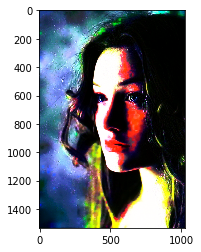

In [76]:
output = style_transfer(vgg, content, style, input_img, iters=1500, style_w=50000000, content_w=10)
output.save("UpdatedSets/"+set_folder+"/output_large4.png")